# Installing Packages

In [1]:
invisible(capture.output({
# options
knitr::opts_chunk$set(echo = TRUE)
knitr::opts_chunk$set(fig.align = "center")

# packages
packages <- c("ggplot2", "finalfit", "leaflet", "tidygeocoder", 
              "tidyr", "httr", "xml2", "qdapRegex", "knitr", "htmltools","dplyr")

invisible(
  lapply(packages, function(pkg) {
    suppressPackageStartupMessages(
      suppressWarnings(
        library(pkg, character.only = TRUE)
      )
    )
  })
)


}))


# Importing Data

In [2]:
#importing data
data <- readRDS("data_cleaned.rds")

In [3]:
# Set the path to your .lss file
file_path <- "limesurvey_survey_882875.lss"

# Read and strip namespaces for easier processing
doc <- read_xml(file_path)
doc_no_ns <- xml_ns_strip(doc)

# --- Extract Question Information from <questions> ---
q_rows <- xml_find_all(doc_no_ns, "//document/questions/rows/row")

question_info <- data.frame(
  qid = sapply(q_rows, function(row) xml_text(xml_find_first(row, "qid"))),
  gid = sapply(q_rows, function(row) xml_text(xml_find_first(row, "gid"))),
  title = sapply(q_rows, function(row) xml_text(xml_find_first(row, "title"))),
  question_order = sapply(q_rows, function(row) xml_text(xml_find_first(row, "question_order"))),
  relevance = sapply(q_rows, function(row) {
    node <- xml_find_first(row, "relevance")
    if (!is.na(node)) xml_text(node) else ""
  }),
  stringsAsFactors = FALSE
)

question_info$question_order <- as.numeric(question_info$question_order)

# --- Extract Group Information from <groups> ---
group_rows <- xml_find_all(doc_no_ns, "//document/groups/rows/row")

group_info <- data.frame(
  gid = sapply(group_rows, function(row) xml_text(xml_find_first(row, "gid"))),
  group_title = sapply(group_rows, function(row) xml_text(xml_find_first(row, "group_name"))),
  group_order = sapply(group_rows, function(row) xml_text(xml_find_first(row, "group_order"))),
  randomization_group = sapply(group_rows, function(row) {
    node <- xml_find_first(row, "randomization_group")
    if (!is.na(node)) xml_text(node) else ""
  }),
  stringsAsFactors = FALSE
)

group_info$group_order <- as.numeric(group_info$group_order)

#Merge Group Info into Question Info
question_info <- left_join(question_info, group_info %>% select(gid, group_order), by = "gid")
question_info <- question_info %>%
  mutate(global_order = group_order * 1000 + question_order) %>%
  arrange(global_order)

# Extract Question Texts from <question_l10ns>
# In LimeSurvey exports, the localized question texts are stored under <question_l10ns>
ql10n_rows <- xml_find_all(doc_no_ns, "//document/question_l10ns/rows/row")

question_text_df <- data.frame(
  qid = sapply(ql10n_rows, function(row) xml_text(xml_find_first(row, "qid"))),
  question_text = sapply(ql10n_rows, function(row) xml_text(xml_find_first(row, "question"))),
  stringsAsFactors = FALSE
)

#Merge the Question Texts into question_info
question_info <- left_join(question_info, question_text_df, by = "qid")

# Helper function to strip HTML tags from a string
clean_html <- function(html_str) {
  if (html_str == "") return("")
  # Wrap the HTML string in a container
  doc <- read_html(paste0("<div>", html_str, "</div>"))
  # Extract and return the plain text
  xml_text(xml_find_first(doc, "//div"))
}

# Apply the clean_html function to each question_text
question_info$question_text <- sapply(question_info$question_text, clean_html)


# Dataset Overview

In [4]:
invisible(capture.output({
summary(data)
}))

# Checking Missing Data

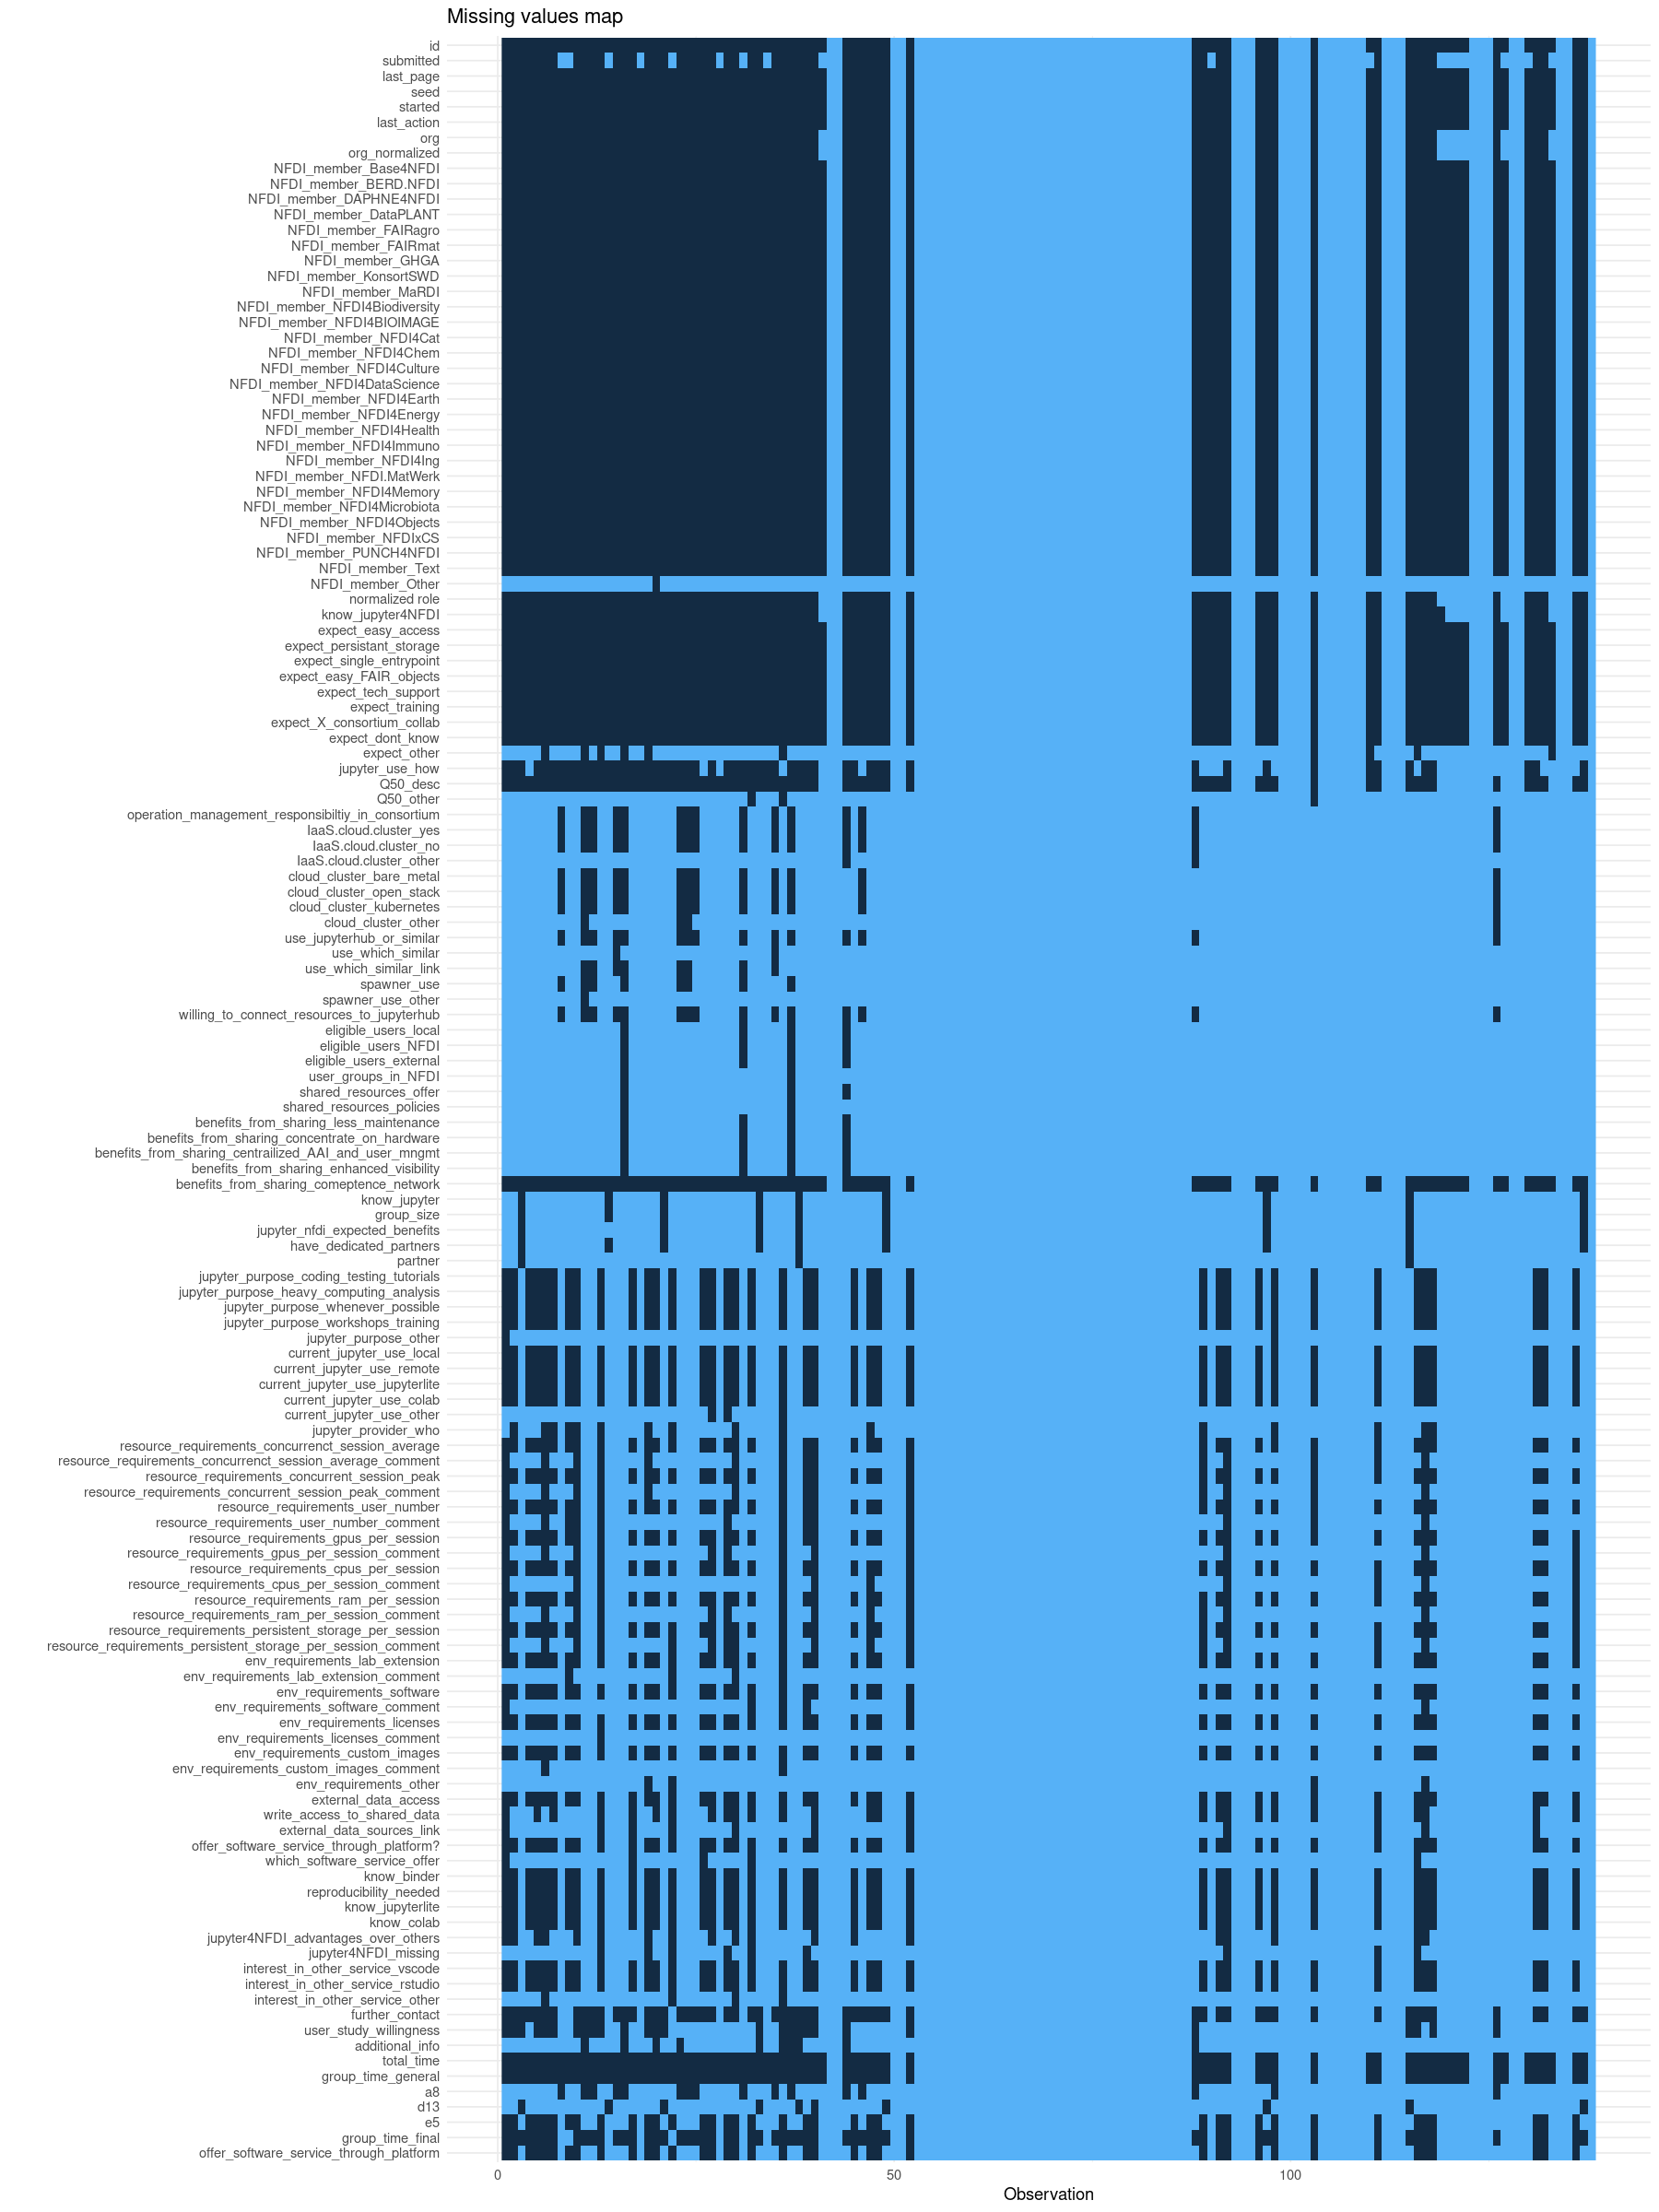

In [5]:
#| fig-align: center
options(repr.plot.width = 15)
options(repr.plot.height = 20)
data_ordered <- data[order(colSums(is.na(data))), ]
missing_plot(data_ordered)

In [6]:
# resetting plotting options
options(repr.plot.width = 15)
options(repr.plot.height = 12)
options(repr.plot.align = 'center')

# Survey Submission Timeline

## Survey Duration

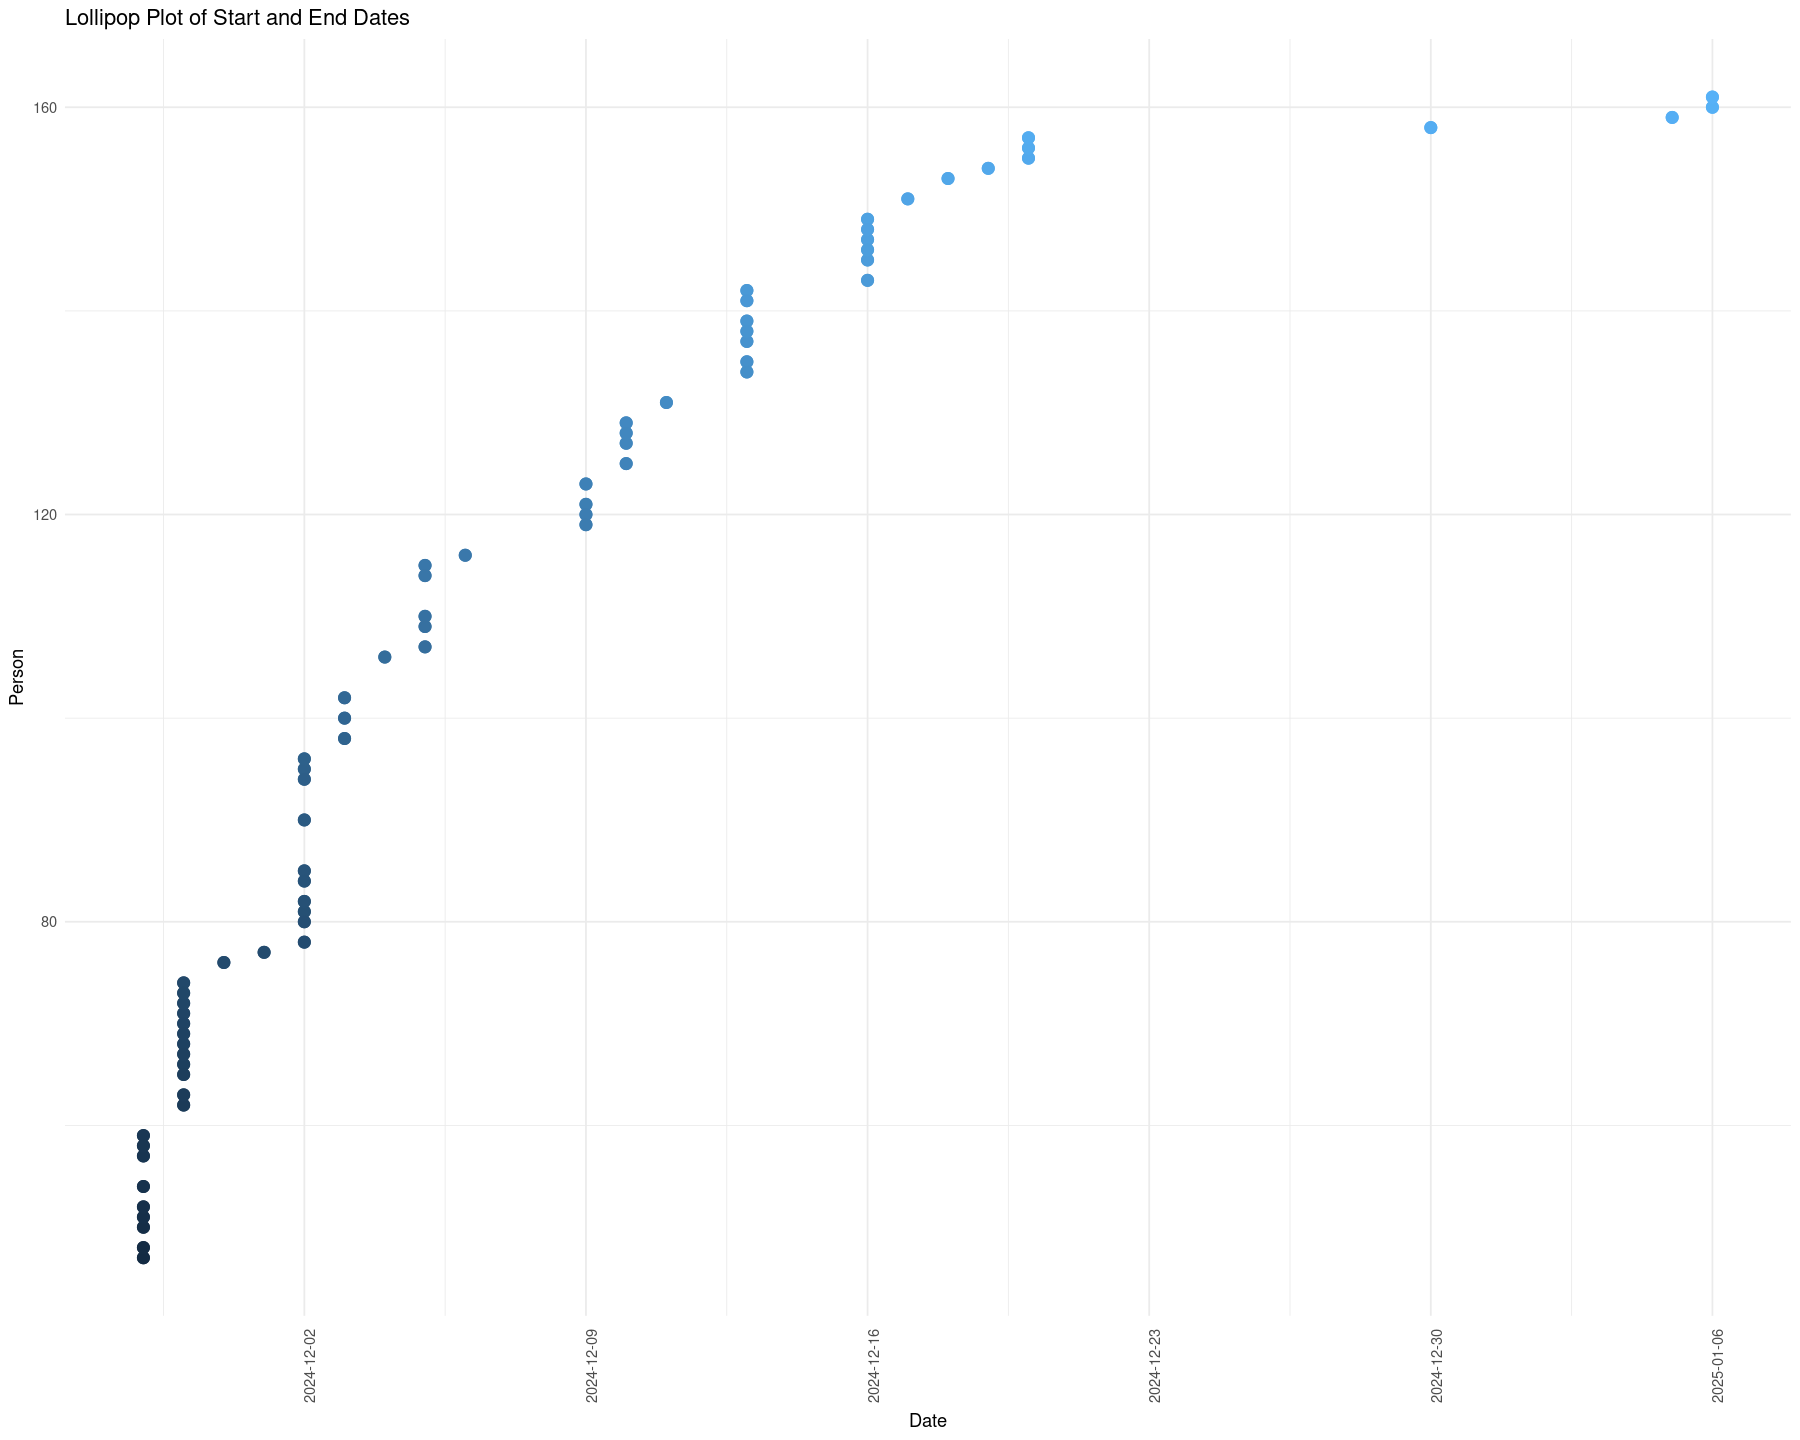

In [7]:
#| fig-align: center

# Reshape data for lollipop plot
data_long <- data %>%
  tidyr::pivot_longer(cols = c("started", "last_action"), 
                      names_to = "DateType", 
                      values_to = "Date")

# Create the lollipop plot
ggplot(data_long, aes(x = as.Date(Date), y = id, group = id)) +
  geom_line(aes(color = id), linewidth = 1) + # Line connecting start and end
  geom_point(aes(color = id), size = 3) + # Dots at start and end
  labs(
    title = "Lollipop Plot of Start and End Dates",
    x = "Date",
    y = "Person"
  ) +
  theme_minimal() +
  scale_x_date(date_breaks = "1 week", date_labels = "%Y-%m-%d") +
  theme(
    legend.position = "none", 
    axis.text.x = element_text(angle = 90, hjust = 0.5) # Vertical y-axis labels
  )


## Survey Duration

In [8]:
# Calculate summary statistics
summary_stats <- summary(data$total_time)

# Convert the summary vector into a data frame
summary_df <- data.frame(
  Statistic = names(summary_stats),
  Value = as.numeric(summary_stats)
)

summary_df


Statistic,Value
<chr>,<dbl>
Min.,2.9100
1st Qu.,216.9400
Median,412.3300
Mean,630.2869
3rd Qu.,699.3450
Max.,6947.1200


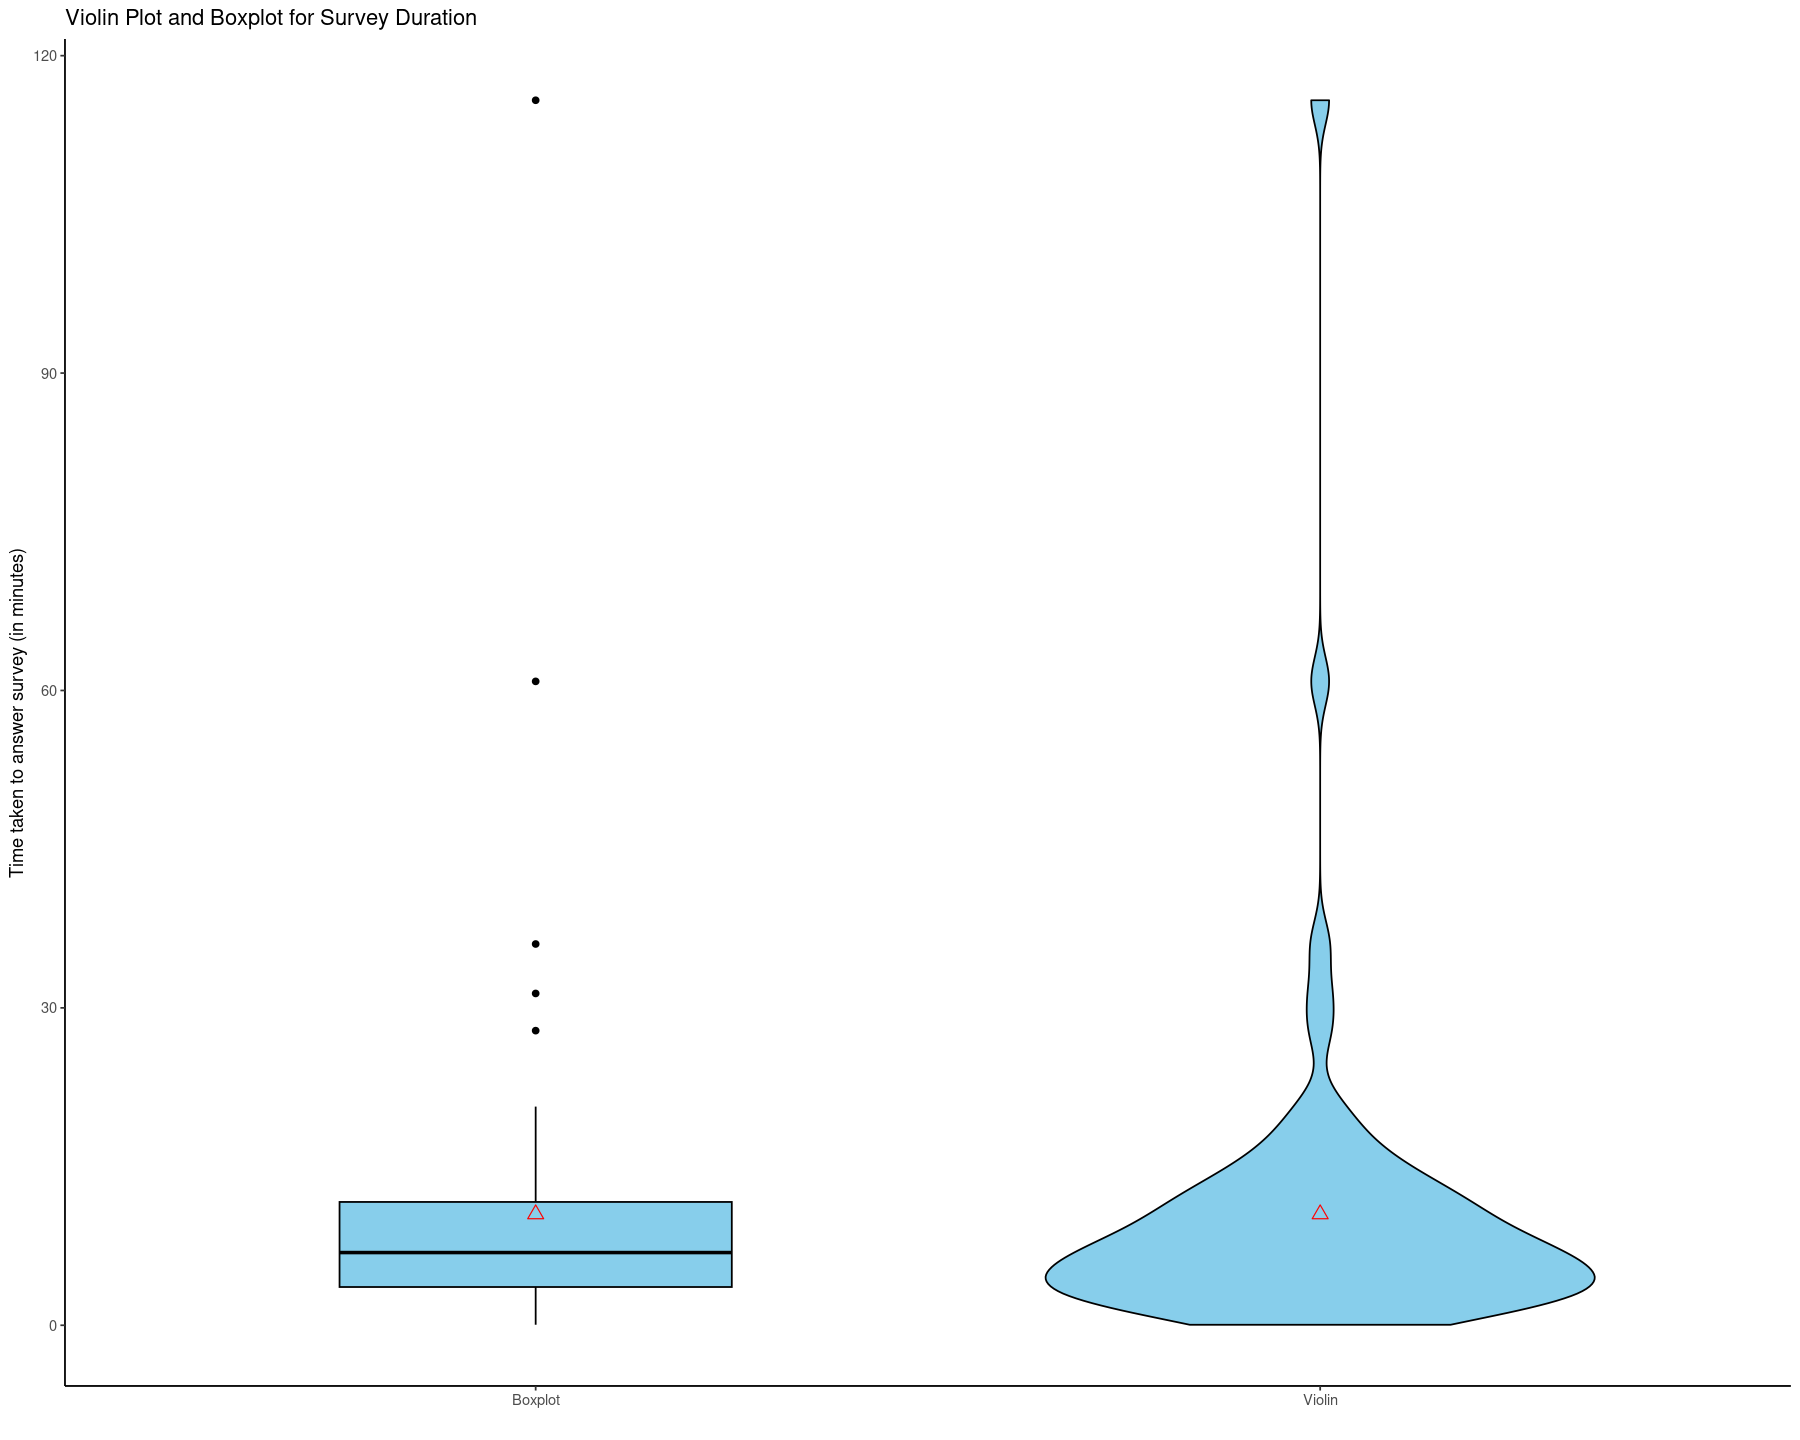

In [9]:
#| fig-align: center
# plot
ggplot(data, aes(x = "Violin", y = (total_time/60))) +
  geom_violin(aes(x = "Violin"), fill = "skyblue", color = "black", width = 0.7) + # Violin
  geom_boxplot(aes(x = "Boxplot"), fill = "skyblue", color = "black", width = 0.5) + # Boxplot
  labs(
    title = "Violin Plot and Boxplot for Survey Duration",
    x = "",
    y = "Time taken to answer survey (in minutes)"
  ) +
  stat_summary(
    aes(x = "Violin"), fun = "mean", geom = "point", 
    shape = 2, size = 3, color = "red"
  ) +
  stat_summary(
    aes(x = "Boxplot"), fun = "mean", geom = "point", 
    shape = 2, size = 3, color = "red"
  ) +# Mean point for violin
  theme_classic()


# Respondent Locations

In [10]:
invisible(capture.output({
locations <- cbind.data.frame(
  Location = data$org_normalized
)

orgs_with_coords <- locations %>%
  geocode(address = Location, method = "osm")

# annotating rest manually
orgs_with_coords[is.na(orgs_with_coords$lat),]
# 1: 51.3828129,7.0210535
# 2: 51.2245443,6.8787735
# 3: 49.4095924,8.6874174
# 4: 51.6615575,7.3115184
# 5: 50.4550671,7.1179205
# 6: 51.7737587,11.1448831
# 7: 51.3432367,10.5987757
# 8: 51.3530789,10.7609292
# 9: NA
# 10: 49.7462132,9.9532957
# 11: 51.3530789,10.7609292
# 12: NA
# 13: 49.4242064,7.4497604

orgs_with_coords[is.na(orgs_with_coords$lat),]$lat <- c(51.3828129,
                                                        51.2245443,
                                                        49.4095924,
                                                        51.6615575,
                                                        50.4550671,
                                                        51.7737587,
                                                        51.3432367,
                                                        51.3530789,
                                                        NA,
                                                        49.7462132,
                                                        51.3530789,
                                                        NA,
                                                        49.4242064,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA
                                                        )

orgs_with_coords[is.na(orgs_with_coords$long),]$long <- c(7.0210535,
                                                        6.8787735,
                                                        8.6874174,
                                                        7.3115184,
                                                        7.1179205,
                                                        11.1448831,
                                                        10.5987757,
                                                        10.7609292,
                                                        NA,
                                                        9.9532957,
                                                        10.7609292,
                                                        NA,
                                                        7.4497604,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA,
                                                        NA
)

# removing empties
orgs_with_coords <- orgs_with_coords[!is.na(orgs_with_coords$lat),]

# fixing wrong ones manually
# 12: Kassel
# 23: EMBL Hamburg
# 35: FLI Institute
# 42: Leibniz Institut for Astrophicsis Potsdam
orgs_with_coords[12,2:3] <- list(51.3147254,9.479618)
orgs_with_coords[23,2:3] <- list(53.578086,9.8802713)
orgs_with_coords[35,2:3] <- list(52.5195955,8.7884747)
orgs_with_coords[42,2:3] <- list(52.4044516,13.1014999)

}))

Passing 53 addresses to the Nominatim single address geocoder

Query completed in: 53.2 seconds



In [11]:
#| fig-align: center
# making interactive map
inst_map <- leaflet(orgs_with_coords) %>%
  addTiles() %>%
  addCircles(
    ~long, ~lat,
    popup = ~Location,
    radius = 10,
    color = "red", fill = TRUE, fillOpacity = 0.5
  )


In [12]:

htmltools::div(
  style = "width: 90%; margin: 0 auto; padding-right: 20px;",
  inst_map
)


Shiny tags cannot be represented in plain text (need html)

# NFDI Consortia

In [13]:
invisible(capture.output({
# Transform data to right format
binary_columns <- data[,9:35]
sapply(binary_columns, class)
for (i in 1:dim(binary_columns)[2]) {
  binary_columns[,i] <- as.factor(binary_columns[,i])
}
binary_columns <- sapply(binary_columns,as.numeric)
binary_columns <- (binary_columns - 1)
sums <- as.data.frame(colSums(binary_columns, na.rm = TRUE))
colnames(sums) <- "Value"
sums$Name <- rownames(sums)
}))

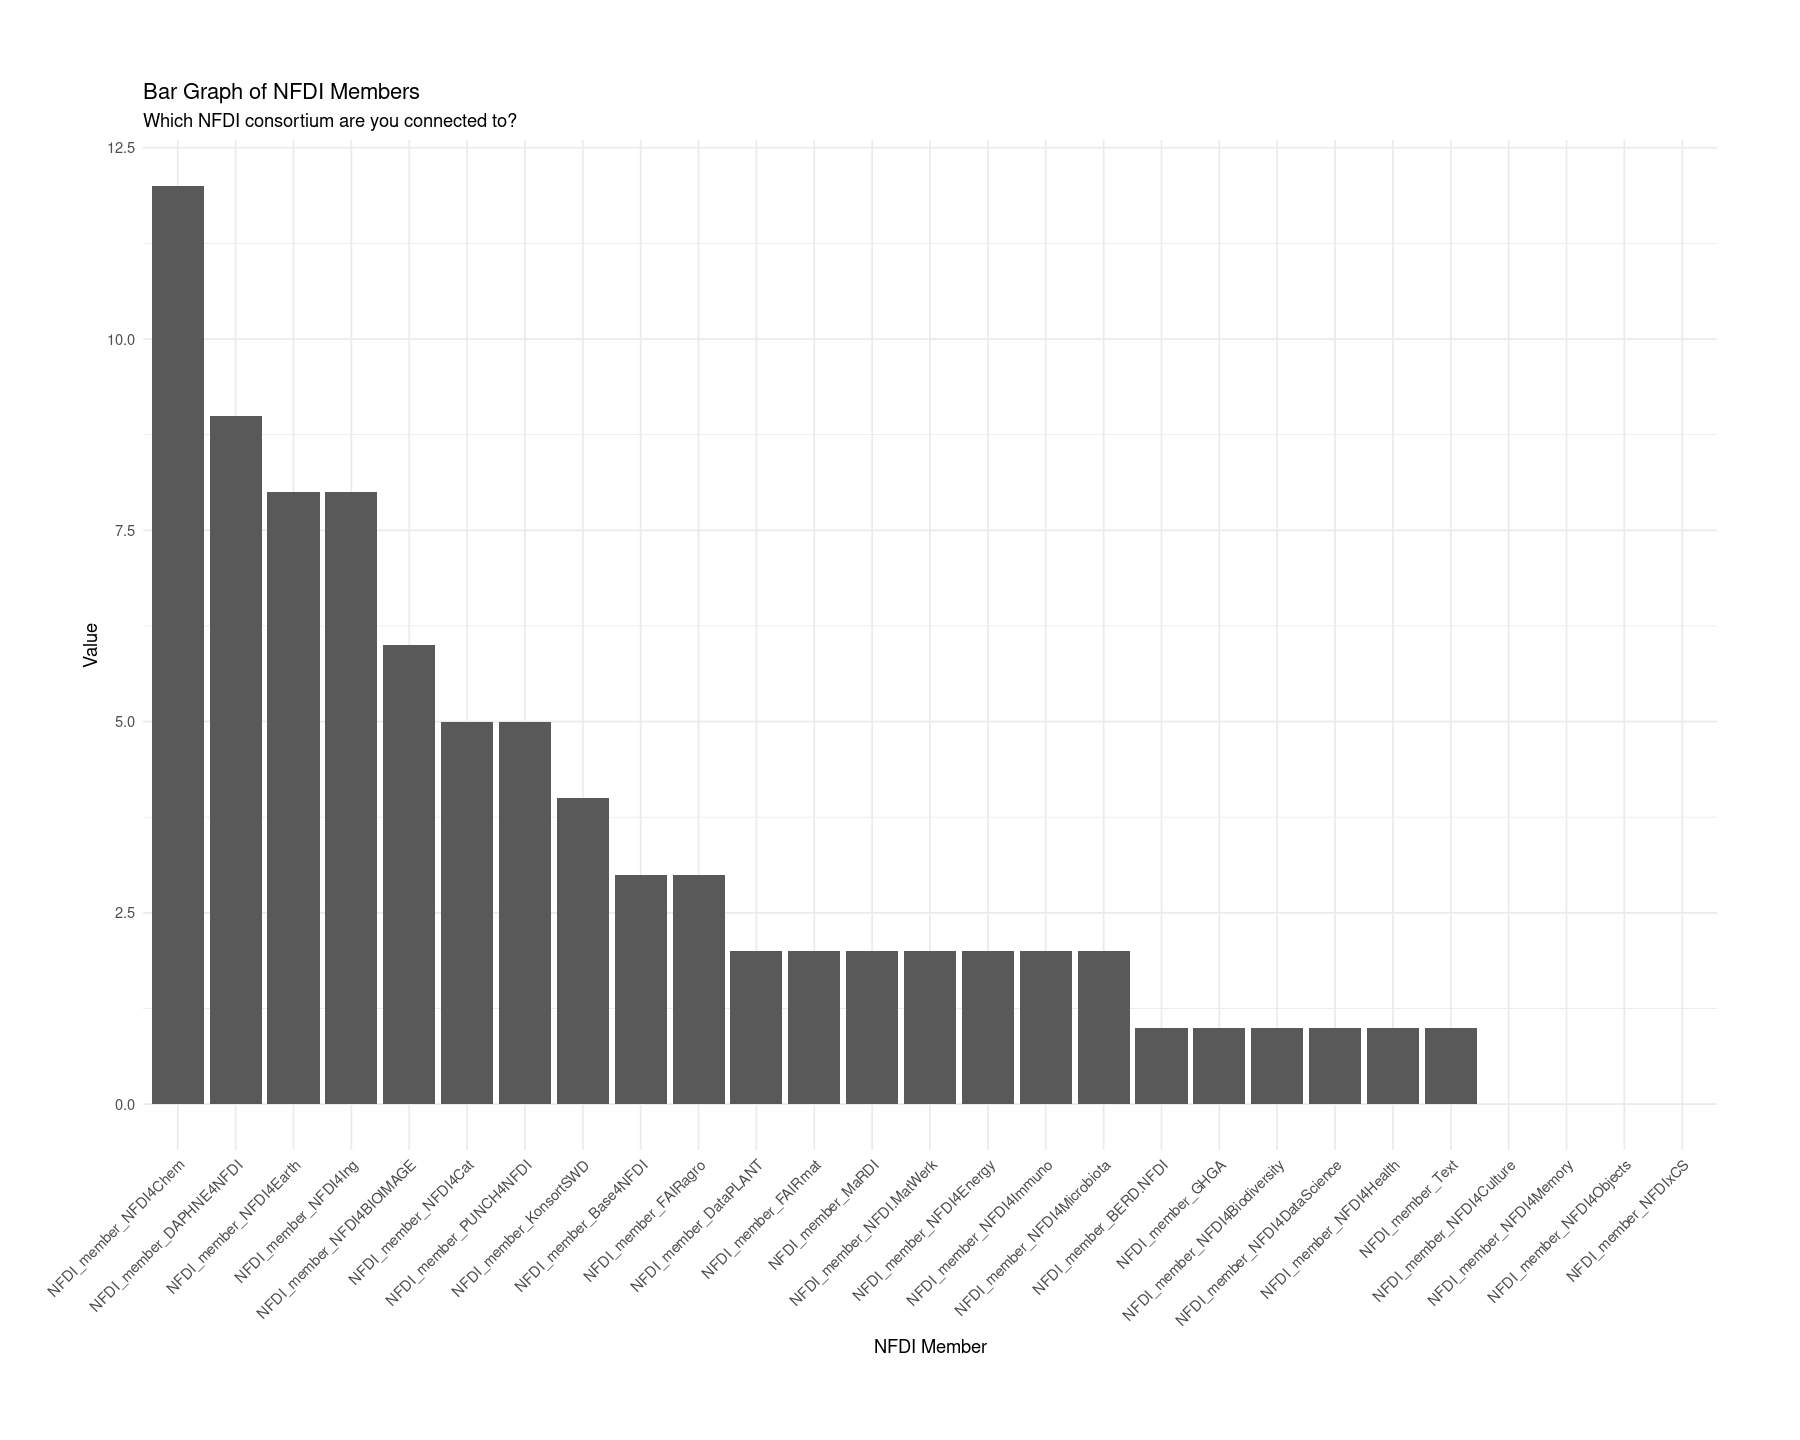

In [14]:
#| fig-align: center

ggplot(sums, aes(x = reorder(Name, -Value), y = Value)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "Bar Graph of NFDI Members",
    subtitle = question_info$question_text[2],
    x = "NFDI Member",
    y = "Value"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.margin = margin(50, 50, 50, 50)
  ) +
  coord_cartesian(clip = "off")


## Other Consortia

In [15]:
# other NFDI
data$NFDI_member_Other[!is.na(data$NFDI_member_Other)]


[1] "de.KCD"

# Role of survey respondents

In [16]:
invisible(capture.output({
data$`normalized role`[data$`normalized role` == FALSE] <- NA
table(data$`normalized role`,useNA = "always")
role_frame <- as.data.frame(table(data$`normalized role`,useNA = "always"))
colnames(role_frame) <- c("Role","Count")
role_frame <- role_frame[order(role_frame$Count,decreasing = T),]
role_frame$Role <- factor(role_frame$Role, levels = role_frame$Role) 
}))

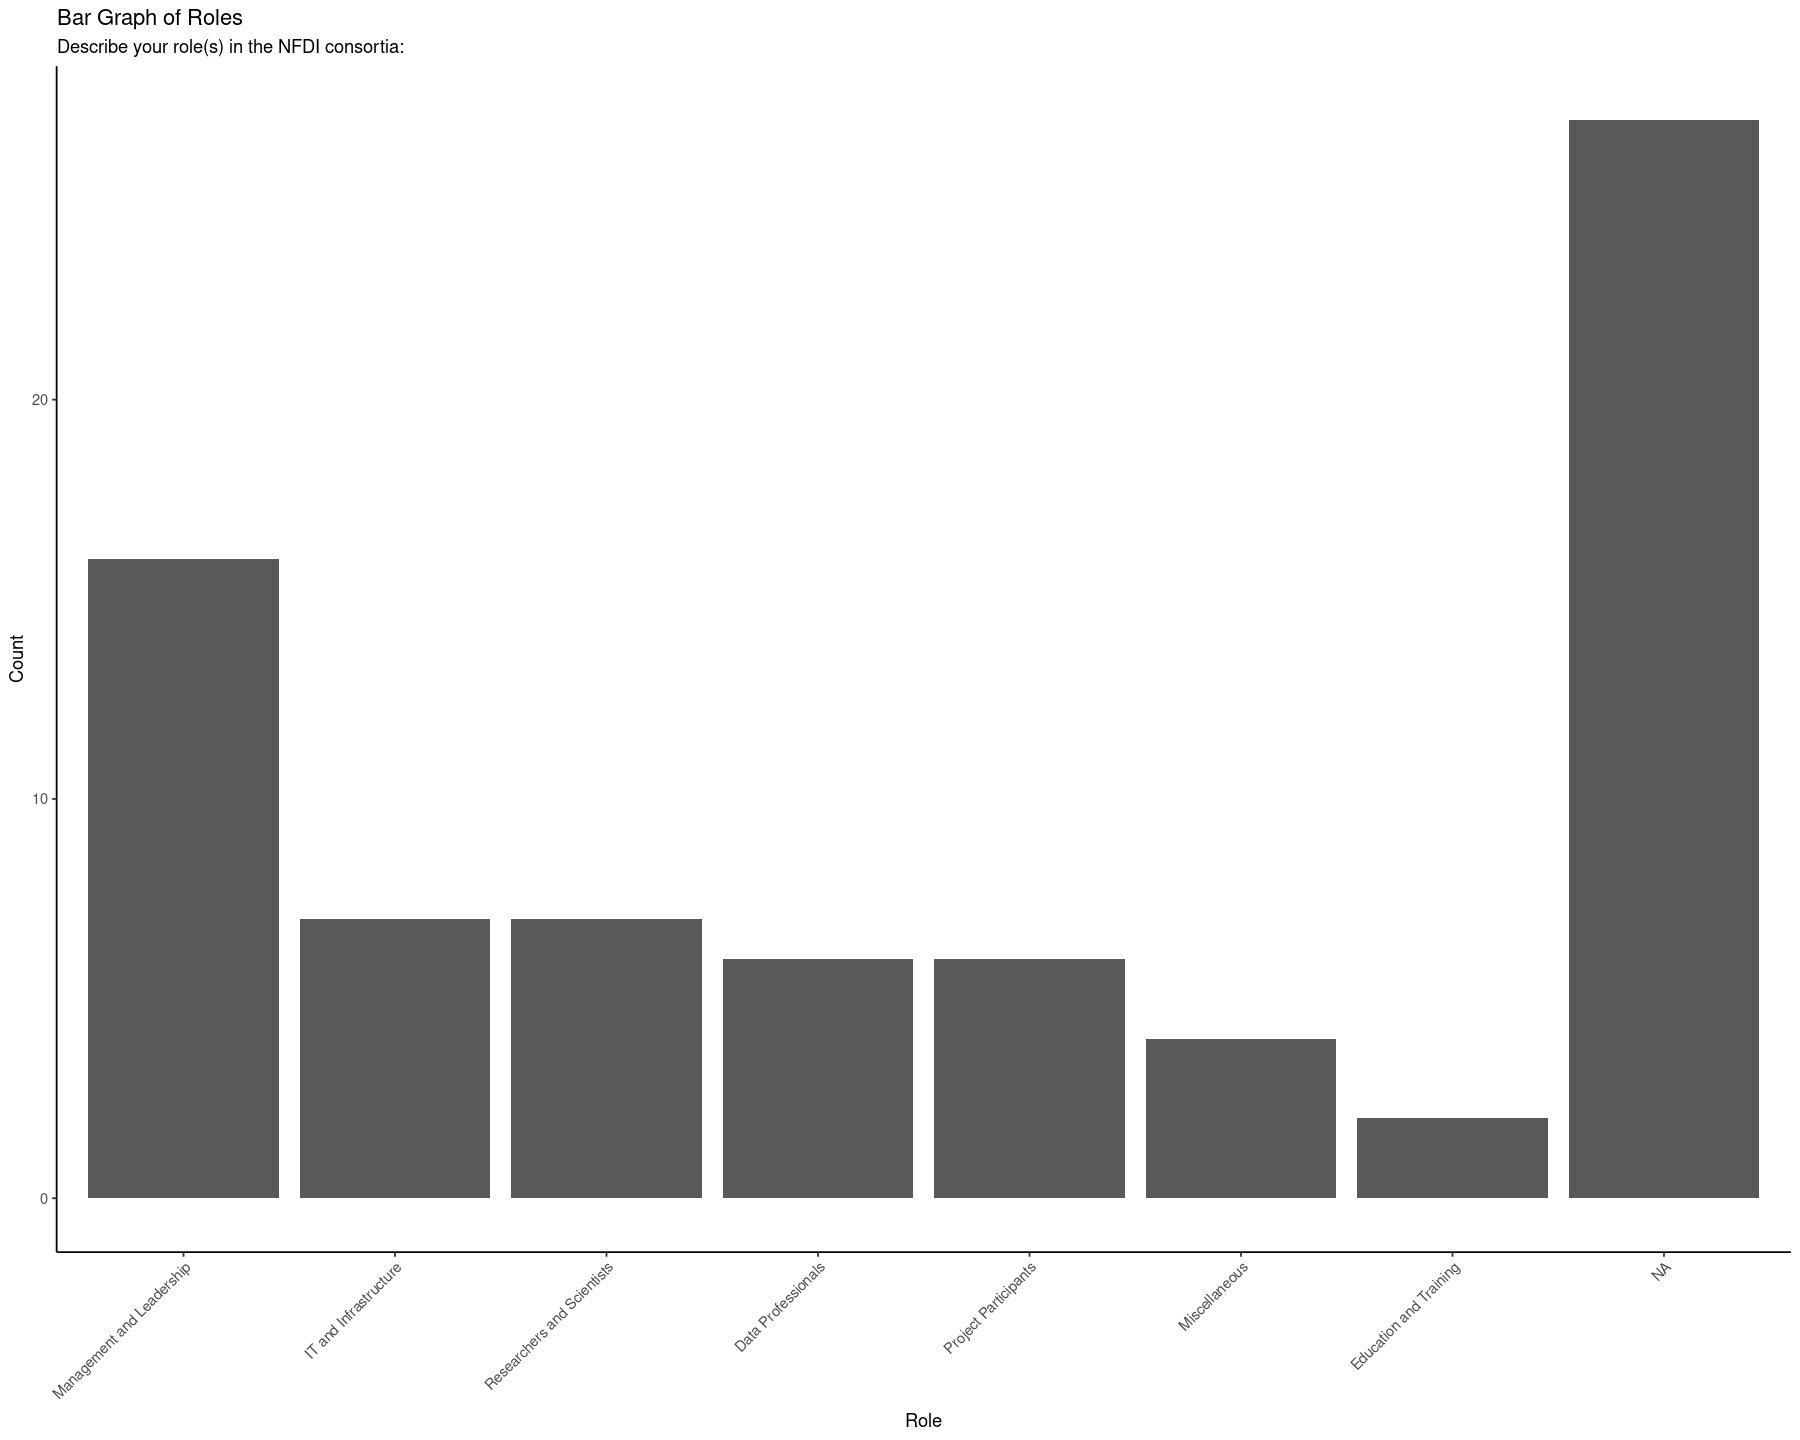

In [17]:
#| fig-align: center
# Barplot
ggplot(role_frame, aes(x = Role, y = Count)) + 
  geom_bar(stat = "identity") +
  theme_classic() +
  labs(
    title = "Bar Graph of Roles",
    subtitle = question_info$question_text[3],
    x = "Role",
    y = "Count"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Knowing Jupyter

In [18]:
table(data$know_jupyter4NFDI,useNA = "always")
prop.table(table(data$know_jupyter4NFDI,useNA = "always"))
know_jupyter4NFDI_frame <- as.data.frame(table(data$know_jupyter4NFDI,useNA = "always"))
colnames(know_jupyter4NFDI_frame) <- c("Knows","Count")
know_jupyter4NFDI_frame <- know_jupyter4NFDI_frame[order(know_jupyter4NFDI_frame$Count,decreasing = T),]
know_jupyter4NFDI_frame$Knows <- factor(know_jupyter4NFDI_frame$Knows, levels = know_jupyter4NFDI_frame$Knows)


  No  Yes <NA> 
  33   36    6 


  No  Yes <NA> 
0.44 0.48 0.08 

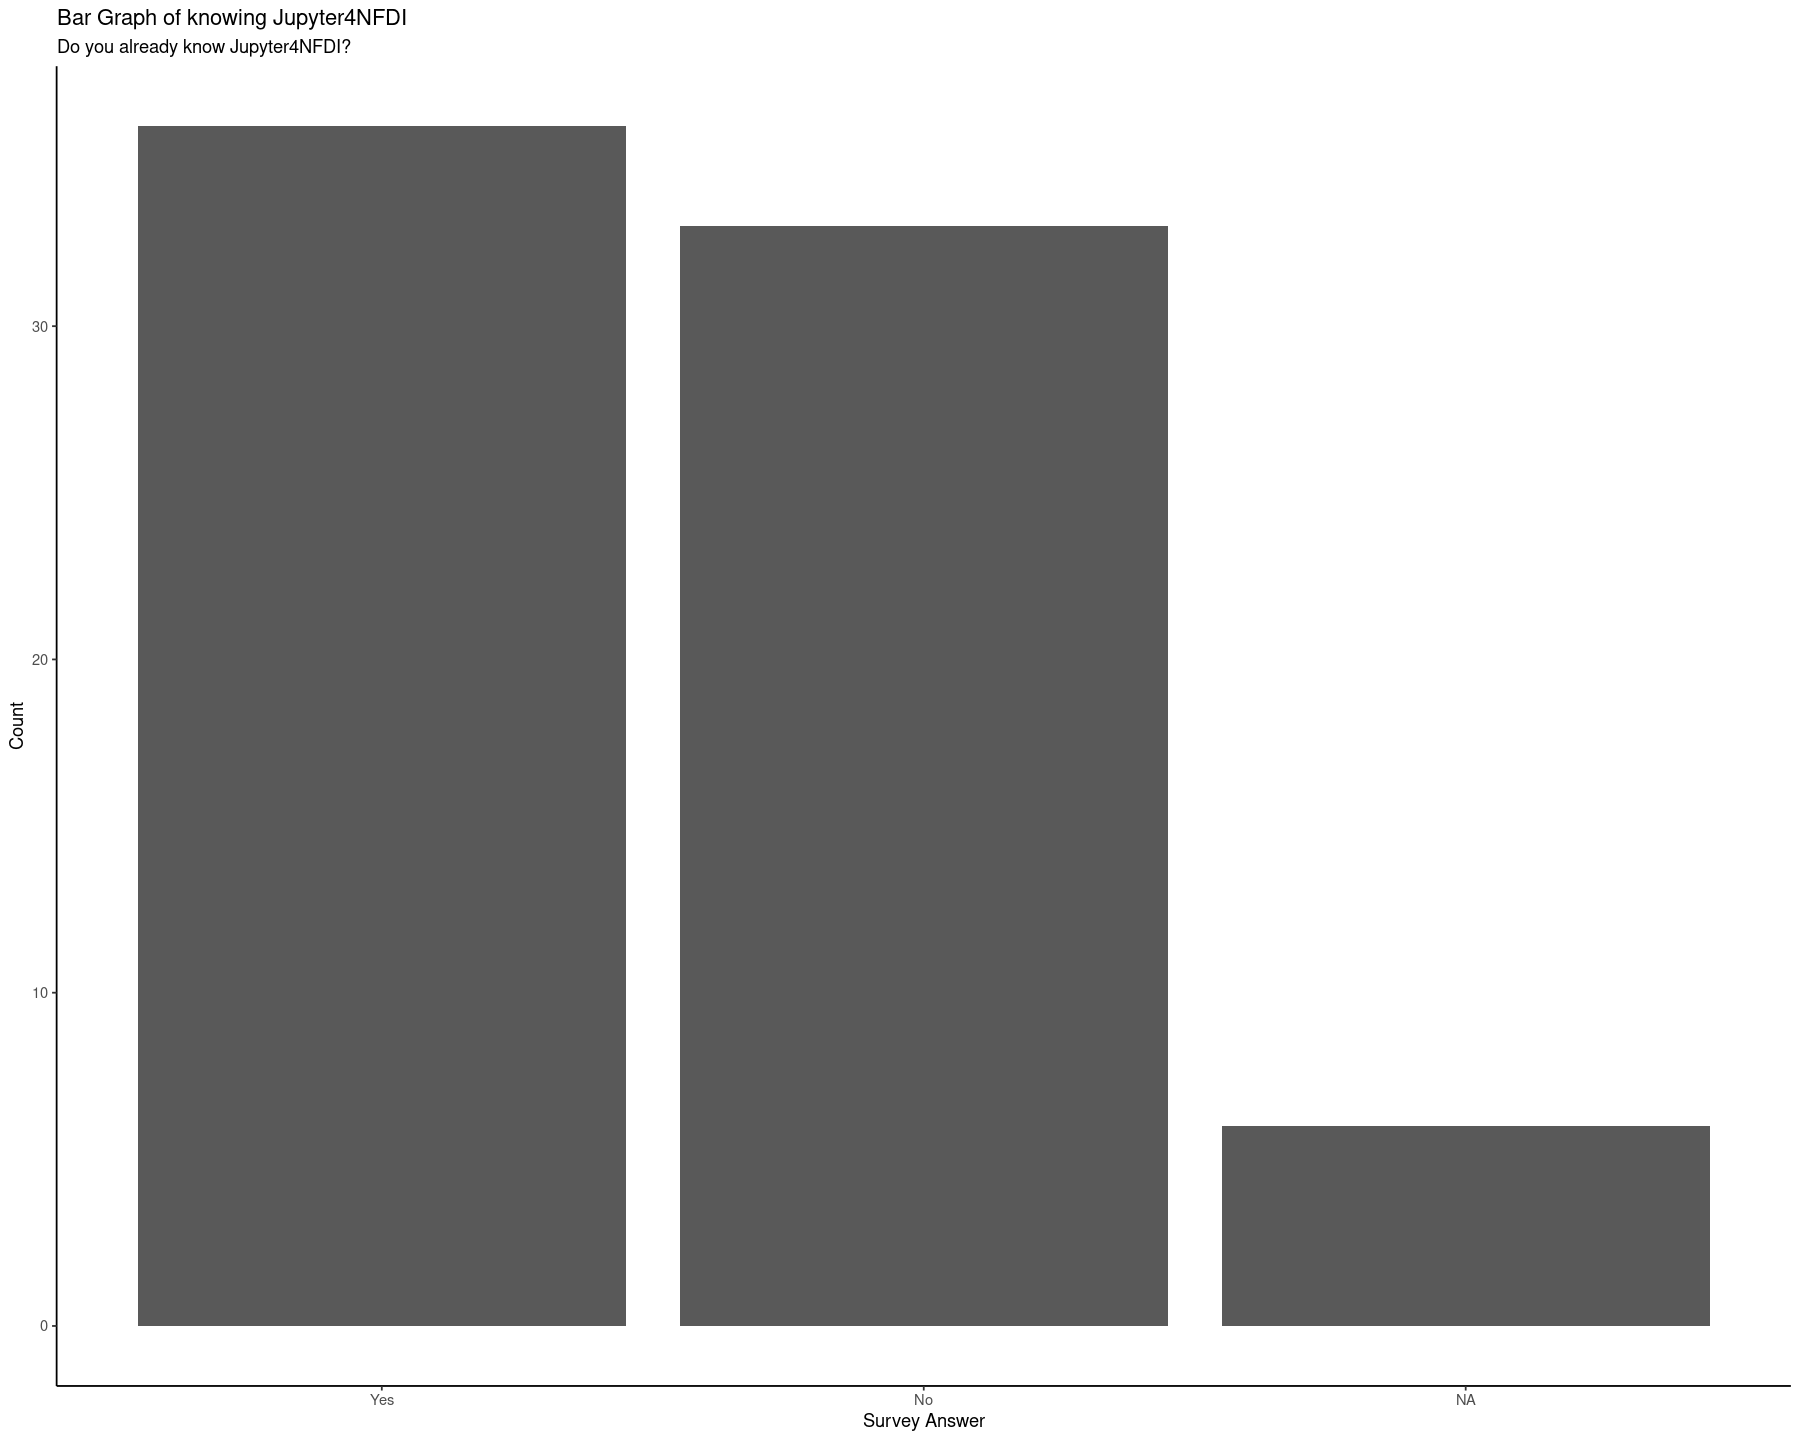

In [19]:
#| fig-align: center
# Barplot
ggplot(know_jupyter4NFDI_frame, aes(x = Knows, y = Count)) + 
  geom_bar(stat = "identity") +
  theme_classic() +
  labs(
    title = "Bar Graph of knowing Jupyter4NFDI",
    subtitle = question_info$question_text[4],
    x = "Survey Answer",
    y = "Count"
  )


# Knowing Jupyter by Role

In [20]:
invisible(capture.output({
# Create a contingency table and transform it to a data frame
know_jupyter4NFDI_role_frame <- as.data.frame(table(data$`normalized role`, data$know_jupyter4NFDI, useNA = "always"))

# Pivot the table to a wide format
know_jupyter4NFDI_role_frame_wide <- suppressWarnings(reshape(know_jupyter4NFDI_role_frame,
                                            idvar = "Var1", 
                                            timevar = "Var2", 
                                            direction = "wide"))

# Clean up the column names
colnames(know_jupyter4NFDI_role_frame_wide) <- c("Role", "No", "Yes", "NA")

# Optionally, create a nice table
know_jupyter4NFDI_role_frame_wide

}))

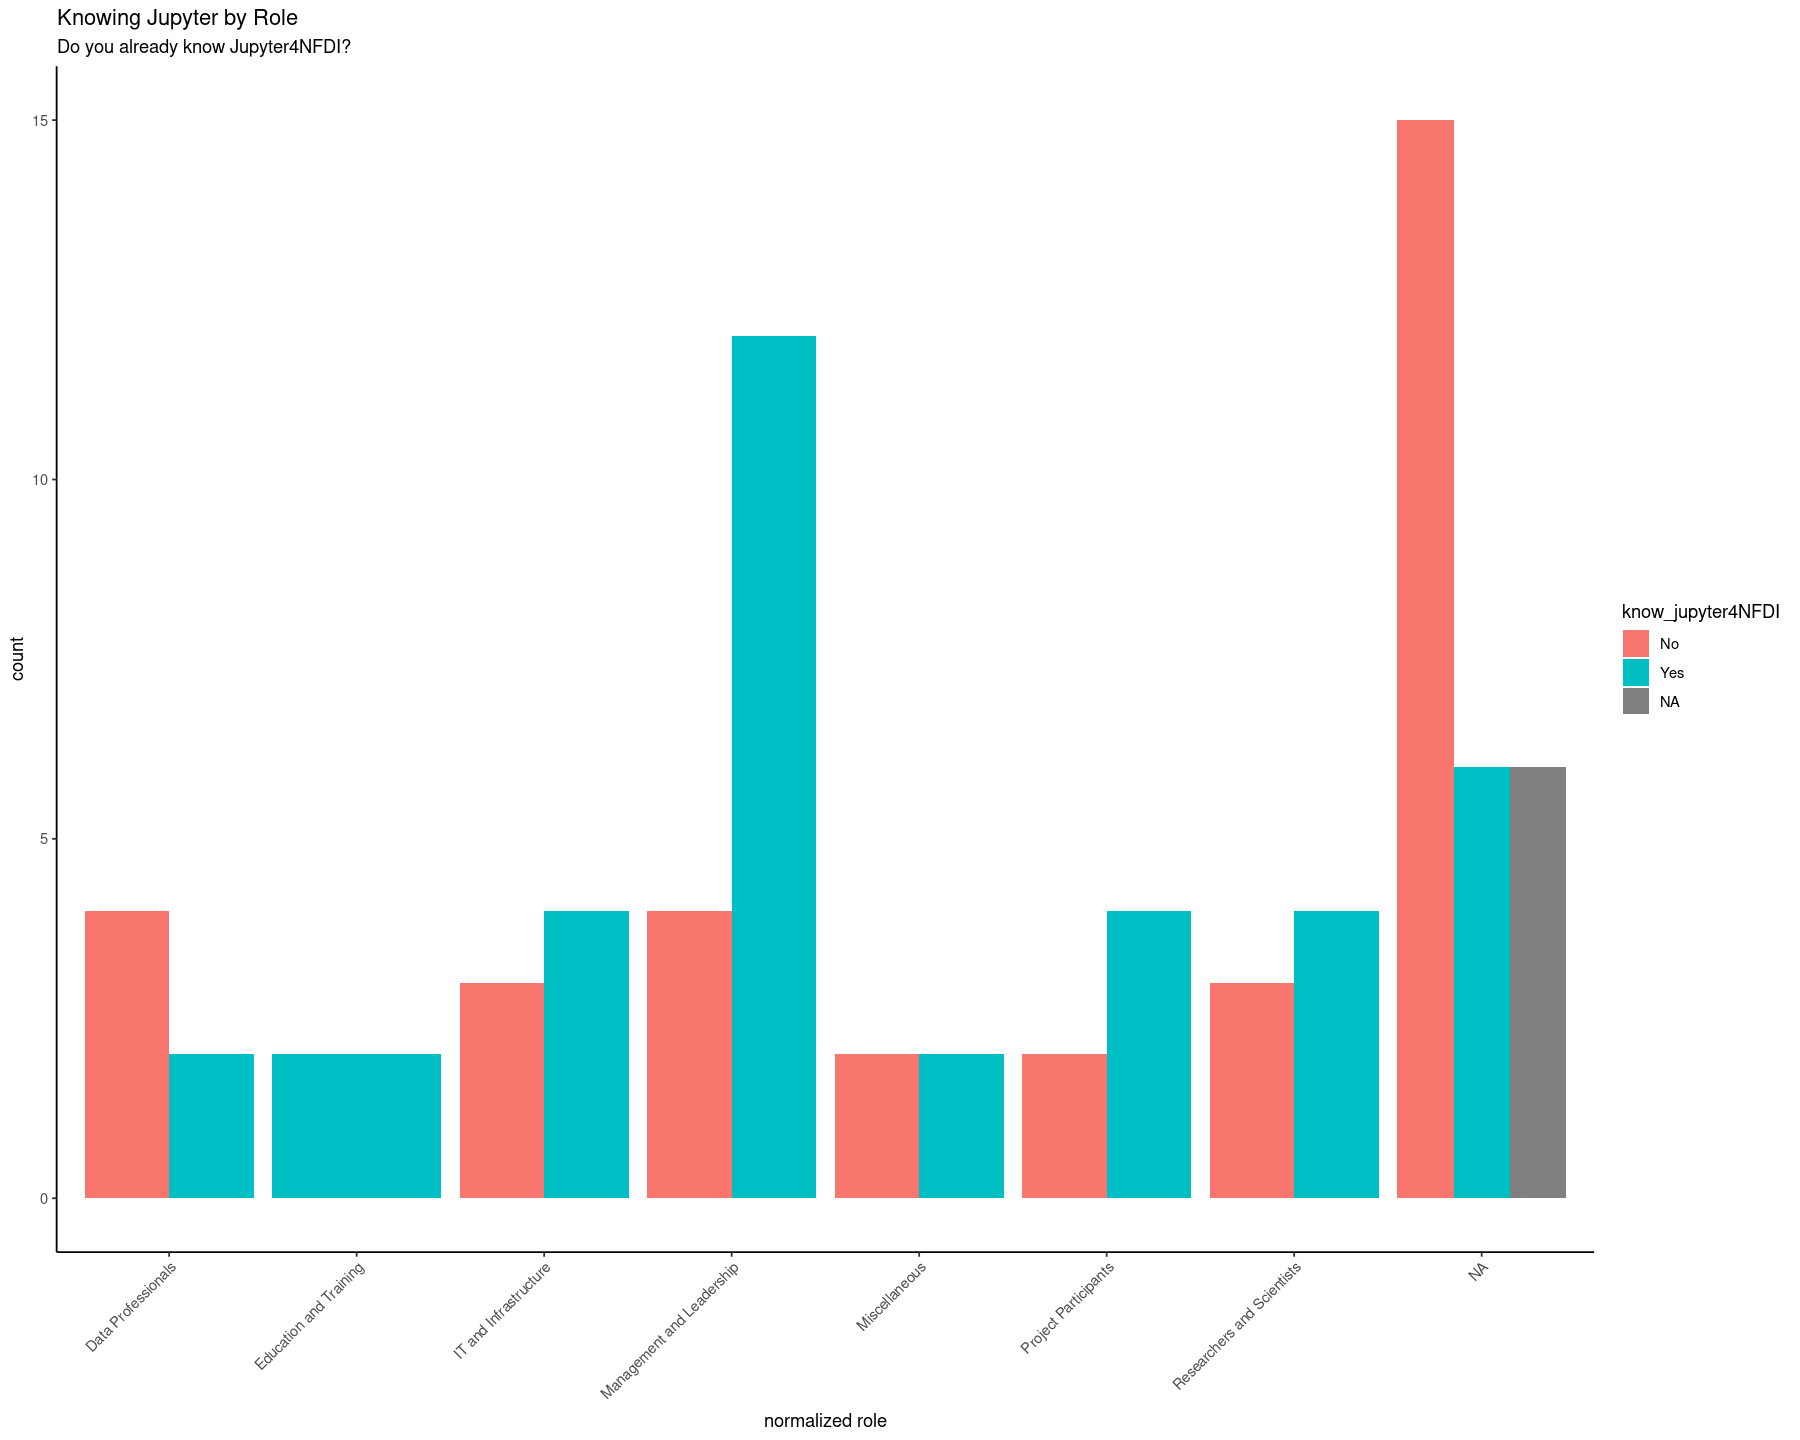

In [21]:
#| fig-align: center
# stacked bar chart
ggplot(data, aes(x = `normalized role`, fill = know_jupyter4NFDI)) + 
  geom_bar(position = "dodge") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Knowing Jupyter by Role", subtitle = question_info$question_text[4],)


# Knowing Jupyter by Consortium

In [22]:
binary_columns_mat <- as.matrix(binary_columns)
column_indices <- apply(binary_columns_mat, 1, which.max)
consortium_factor <- as.factor(column_indices)
levels(consortium_factor) <- substr(colnames(binary_columns),13,100)[as.numeric((levels(consortium_factor)))]
data$consortium <- consortium_factor


In [23]:
# Create a contingency table and transform it to a data frame
know_jupyter4NFDI_consortium_frame <- as.data.frame(table(data$consortium, data$know_jupyter4NFDI, useNA = "always"))

# Pivot the table to a wide format
know_jupyter4NFDI_consortium_frame_wide <- reshape(know_jupyter4NFDI_consortium_frame,
                                            idvar = "Var1", 
                                            timevar = "Var2", 
                                            direction = "wide")

# Clean up the column names
colnames(know_jupyter4NFDI_consortium_frame_wide) <- c("Role", "No", "Yes", "NA")

# Optionally, create a nice table 
know_jupyter4NFDI_consortium_frame_wide

Warning message in reshapeWide(data, idvar = idvar, timevar = timevar, varying = varying, :
“there are records with missing times, which will be dropped.”


,Role,No,Yes,NA
,<fct>,<int>,<int>,<int>
1,Base4NFDI,0,5,6
2,BERD.NFDI,1,0,0
3,DAPHNE4NFDI,7,2,0
4,DataPLANT,0,1,0
5,FAIRagro,1,2,0
6,FAIRmat,2,0,0
7,GHGA,0,1,0
8,KonsortSWD,3,1,0
9,MaRDI,0,1,0


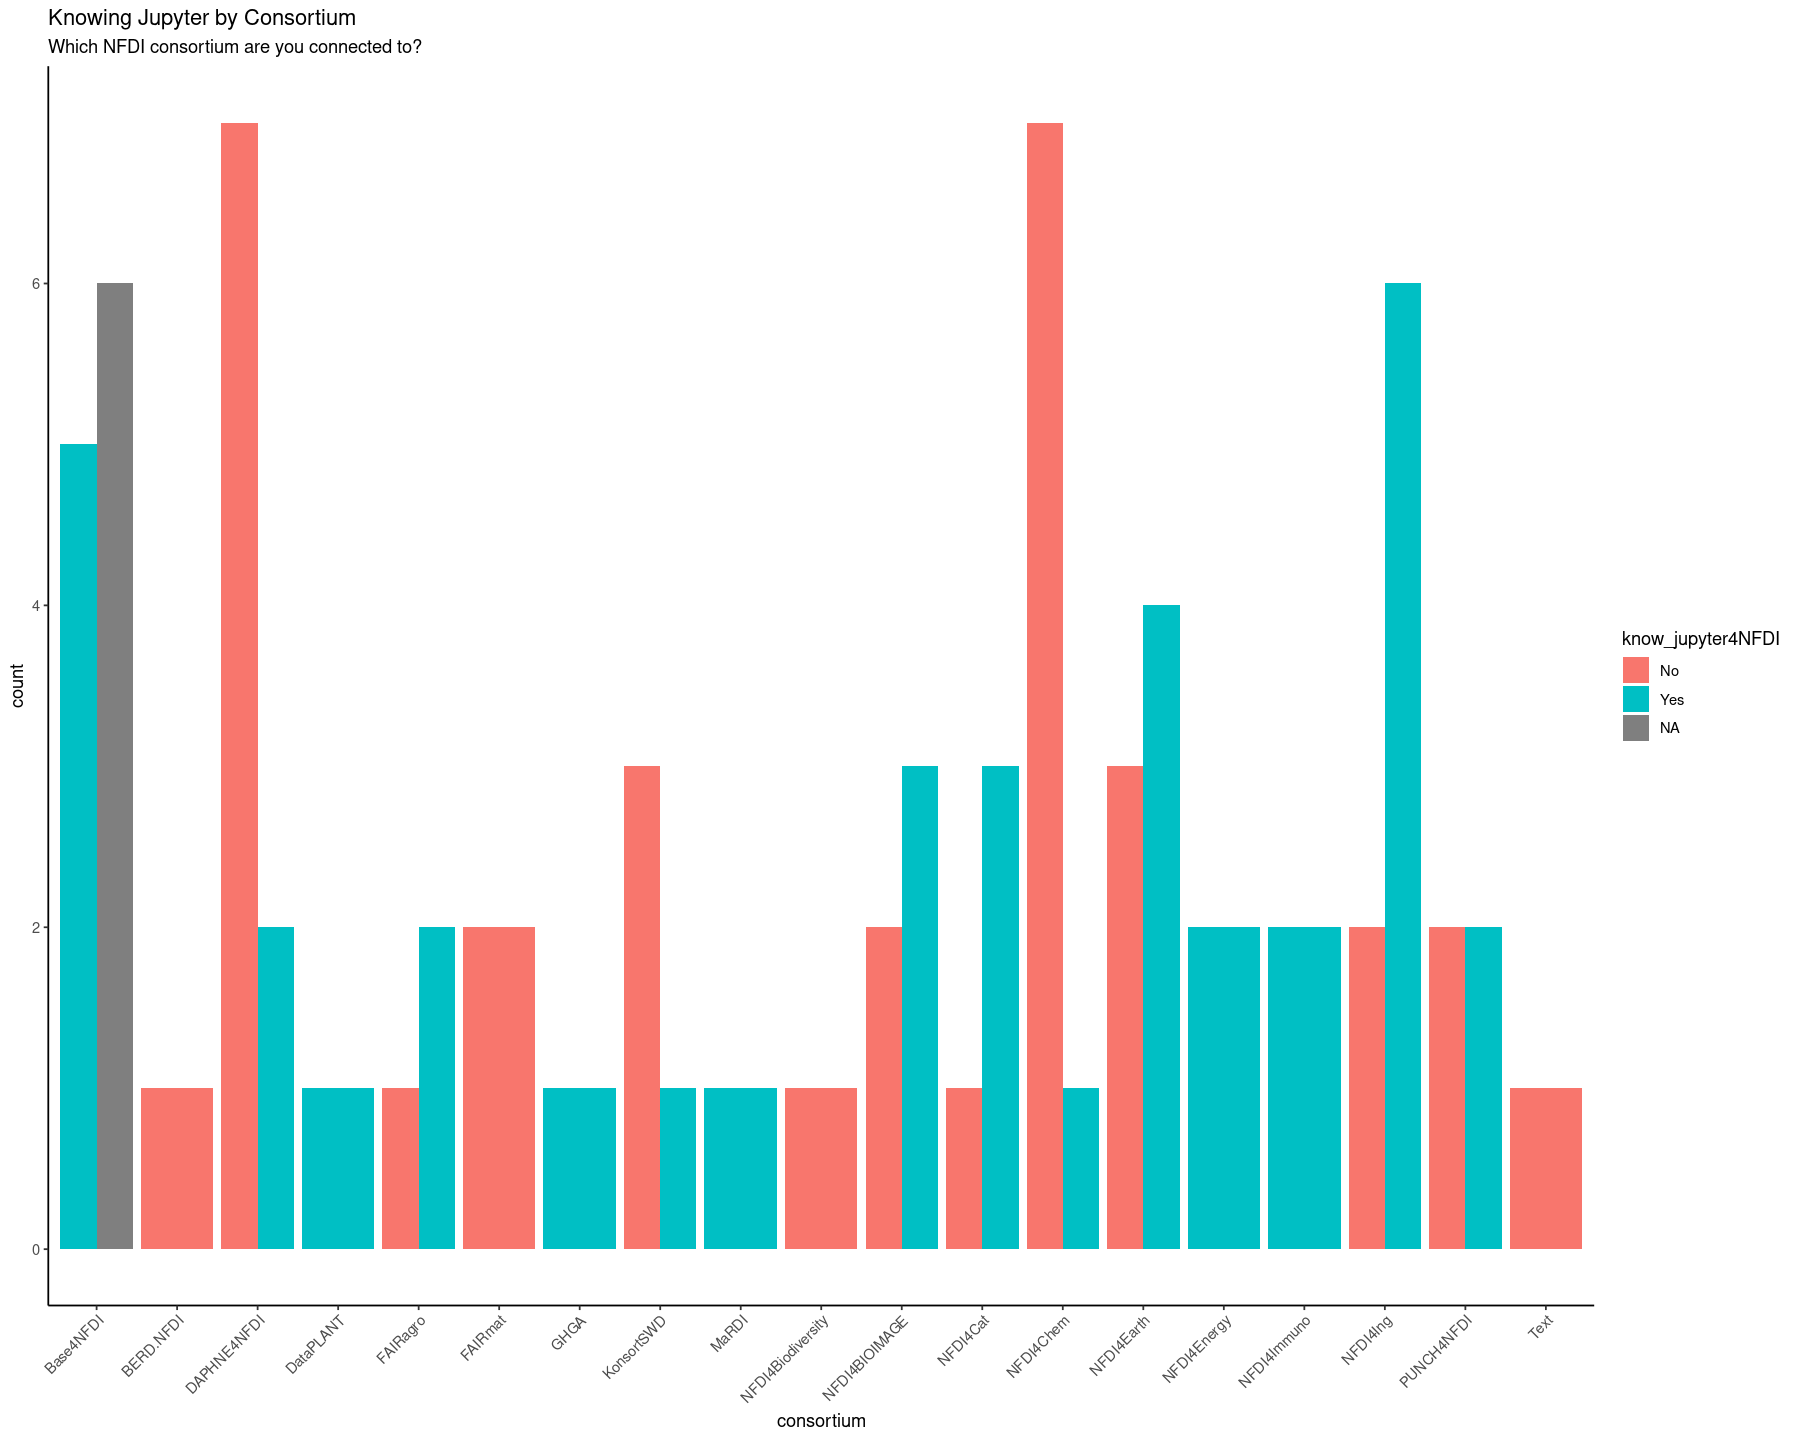

In [24]:
#| fig-align: center
# stacked bar chart
ggplot(data, aes(x = consortium, fill = know_jupyter4NFDI)) + 
  geom_bar(position = "dodge") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  +
  labs(title = "Knowing Jupyter by Consortium", subtitle = question_info$question_text[2],)

# Expectations

In [25]:
invisible(capture.output({
expect_frame <- data[,39:46]
sapply(expect_frame, class)
for (i in 1:dim(expect_frame)[2]) {
  expect_frame[,i] <- as.factor(expect_frame[,i])
}
expect_frame <- sapply(expect_frame,as.numeric)
expect_frame <- (expect_frame - 1)
sums <- as.data.frame(colSums(expect_frame, na.rm = TRUE))
colnames(sums) <- "Value"
sums$Name <- rownames(sums)
}))

In [26]:
# Pivot the table to a wide format (to prevent long format)
sums2 <- reshape(sums,
                 idvar = "Value",
                 timevar = "Name",
                 direction = "wide")

# Optionally, create a nice table 
sums2


,Value
,<dbl>
expect_easy_access,53
expect_persistant_storage,27
expect_single_entrypoint,40
expect_easy_FAIR_objects,26
expect_tech_support,24
expect_training,28
expect_X_consortium_collab,22
expect_dont_know,9


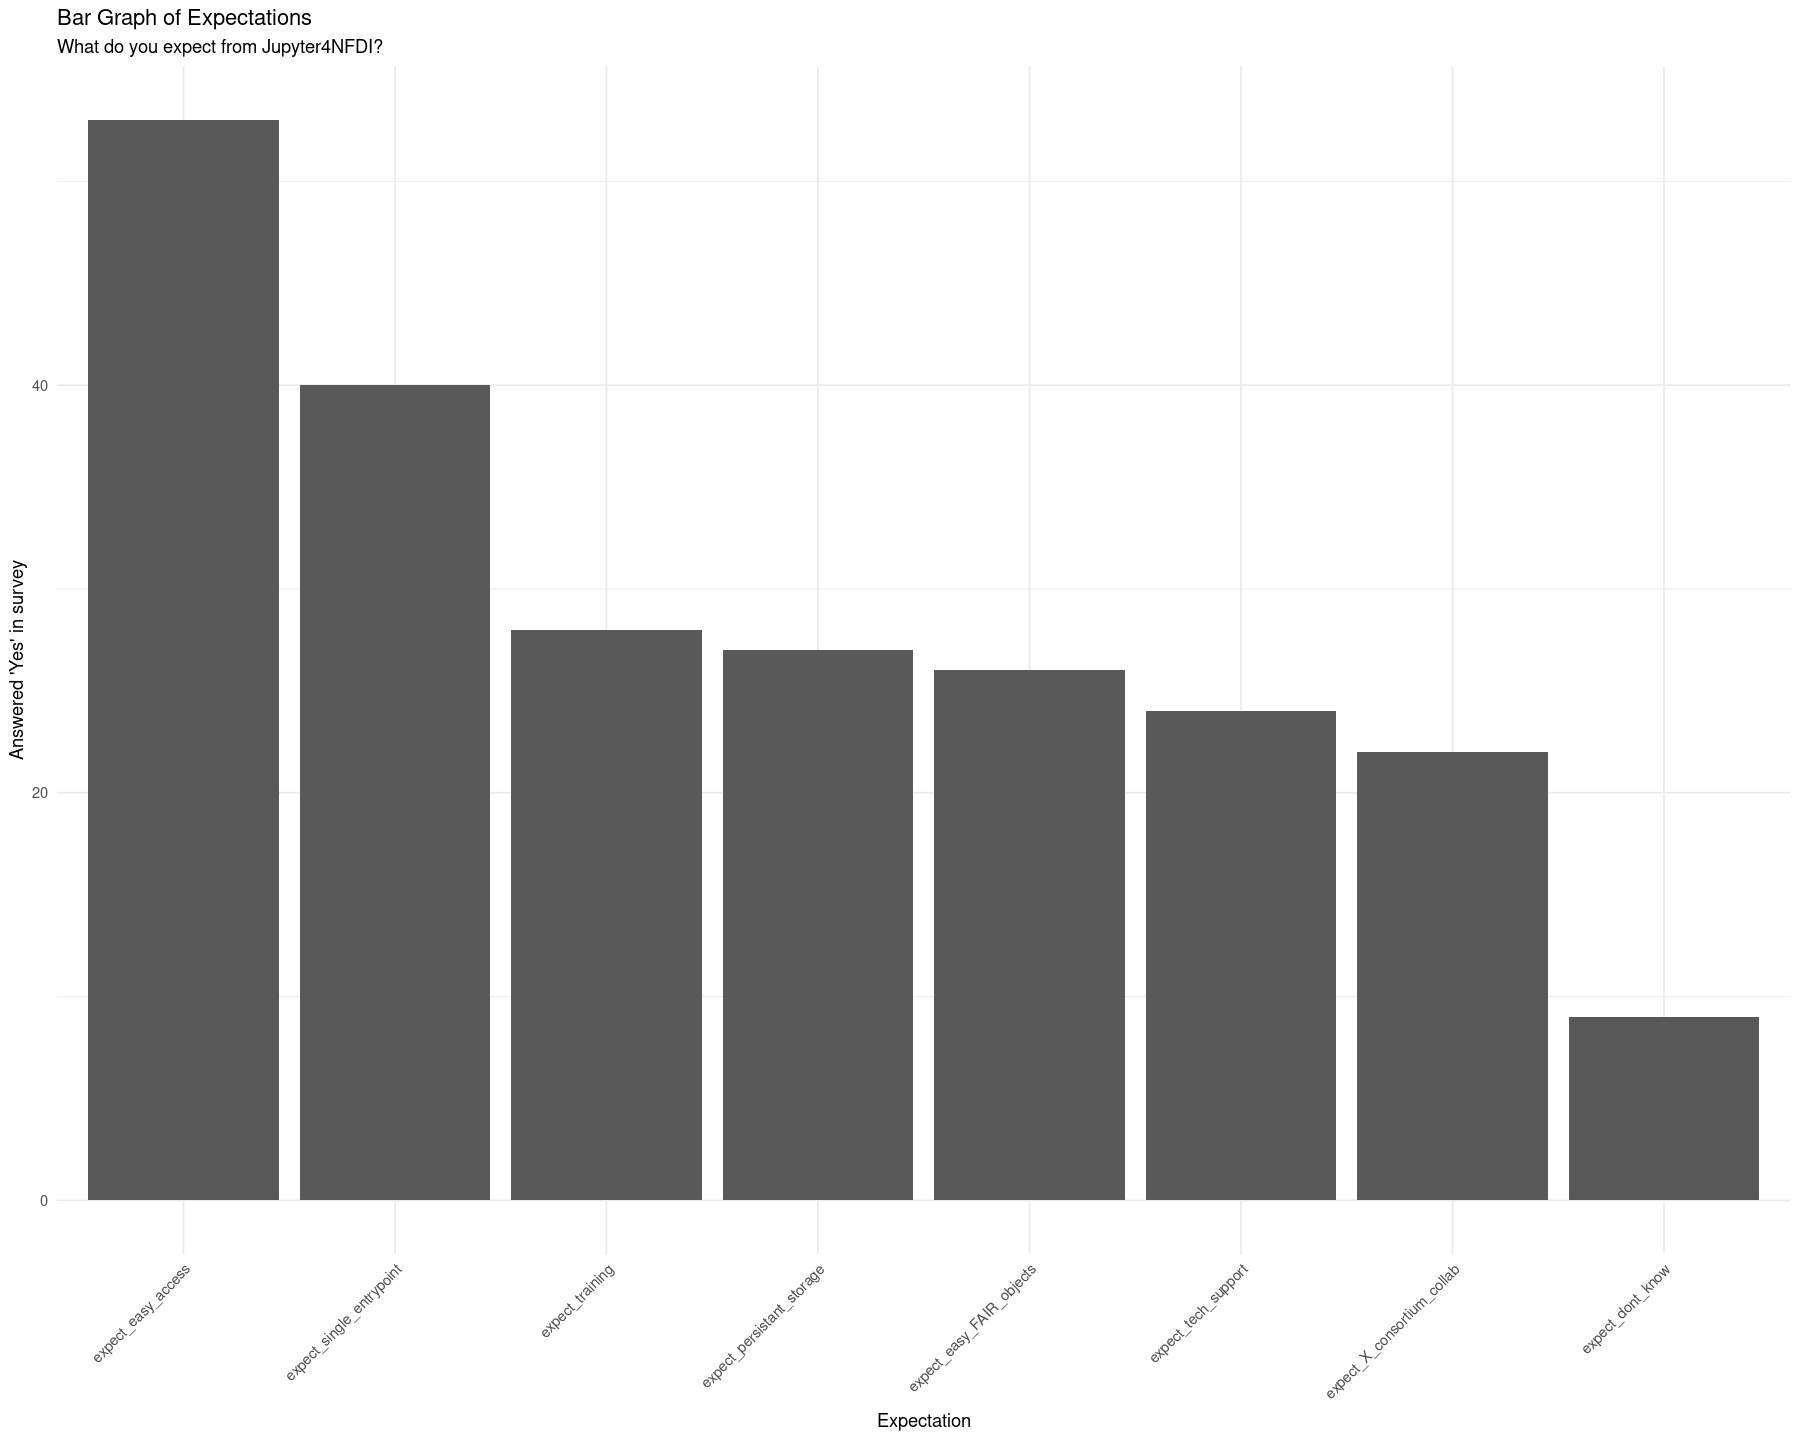

In [27]:
#| fig-align: center
# Create bar graph
ggplot(sums, aes(x = reorder(Name, -Value), y = Value)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "Bar Graph of Expectations",
    subtitle = question_info$question_text[5],
    x = "Expectation",
    y = "Answered 'Yes' in survey"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

### Other Expectations

In [28]:
# other NFDI
data$expect_other[!is.na(data$expect_other)]

[1] "possibility to create/use custom images"                                                                                                                                                                      
 [2] "A frontend to select which JupyterHub resource to use. "                                                                                                                                                      
 [3] "enhanced reproducibility"                                                                                                                                                                                     
 [4] "Federation across different institutes (e.g. federated storage)"                                                                                                                                              
 [5] "A teaching instance."                                                                                                                                                                                         
 [6] "gpus tests for prototyping large ml/llm projects"                                                                                                                                                             
 [7] "Code contributions to Jupyter"                                                                                                                                                                                
 [8] "I clicked on \"Persisten storage\" but would rather expect the data to be stored for a limited time only; or during which the analyses run. I would also expect tutorial on how to get the data into the Hub."
 [9] "provide computing env for NFDI training materials"                                                                                                                                                            
[10] "Nothing useful. "

# Consortium Role

In [29]:
# Survey taker consortium role
data$Q50_desc[data$Q50_desc == "User (single-person or, for example, teacher/trainer)"] <- "User"
data$Q50_desc[data$Q50_desc == "Community or Research Alliance Representative / Consortium Manager"] <- "Representative/Manager"

#table(data$Q50_desc, useNA = "always")
#prop.table(table(data$Q50_desc, useNA = "always"))*100
cons_role_frame <- as.data.frame(table(data$Q50_desc, useNA = "always"))

# Optionally, create a nice table
cons_role_frame



Var1,Freq
<fct>,<int>
Other,3
Representative/Manager,10
Resource Provider,17
User,38
NA,7


[1] "Select the appropriate branch that describes your activity. The scope and content of the following questions depend on this selection. If you say you fit for more than one option, please decide on one option. Please only select “Other” if  none of the other options applies as well."

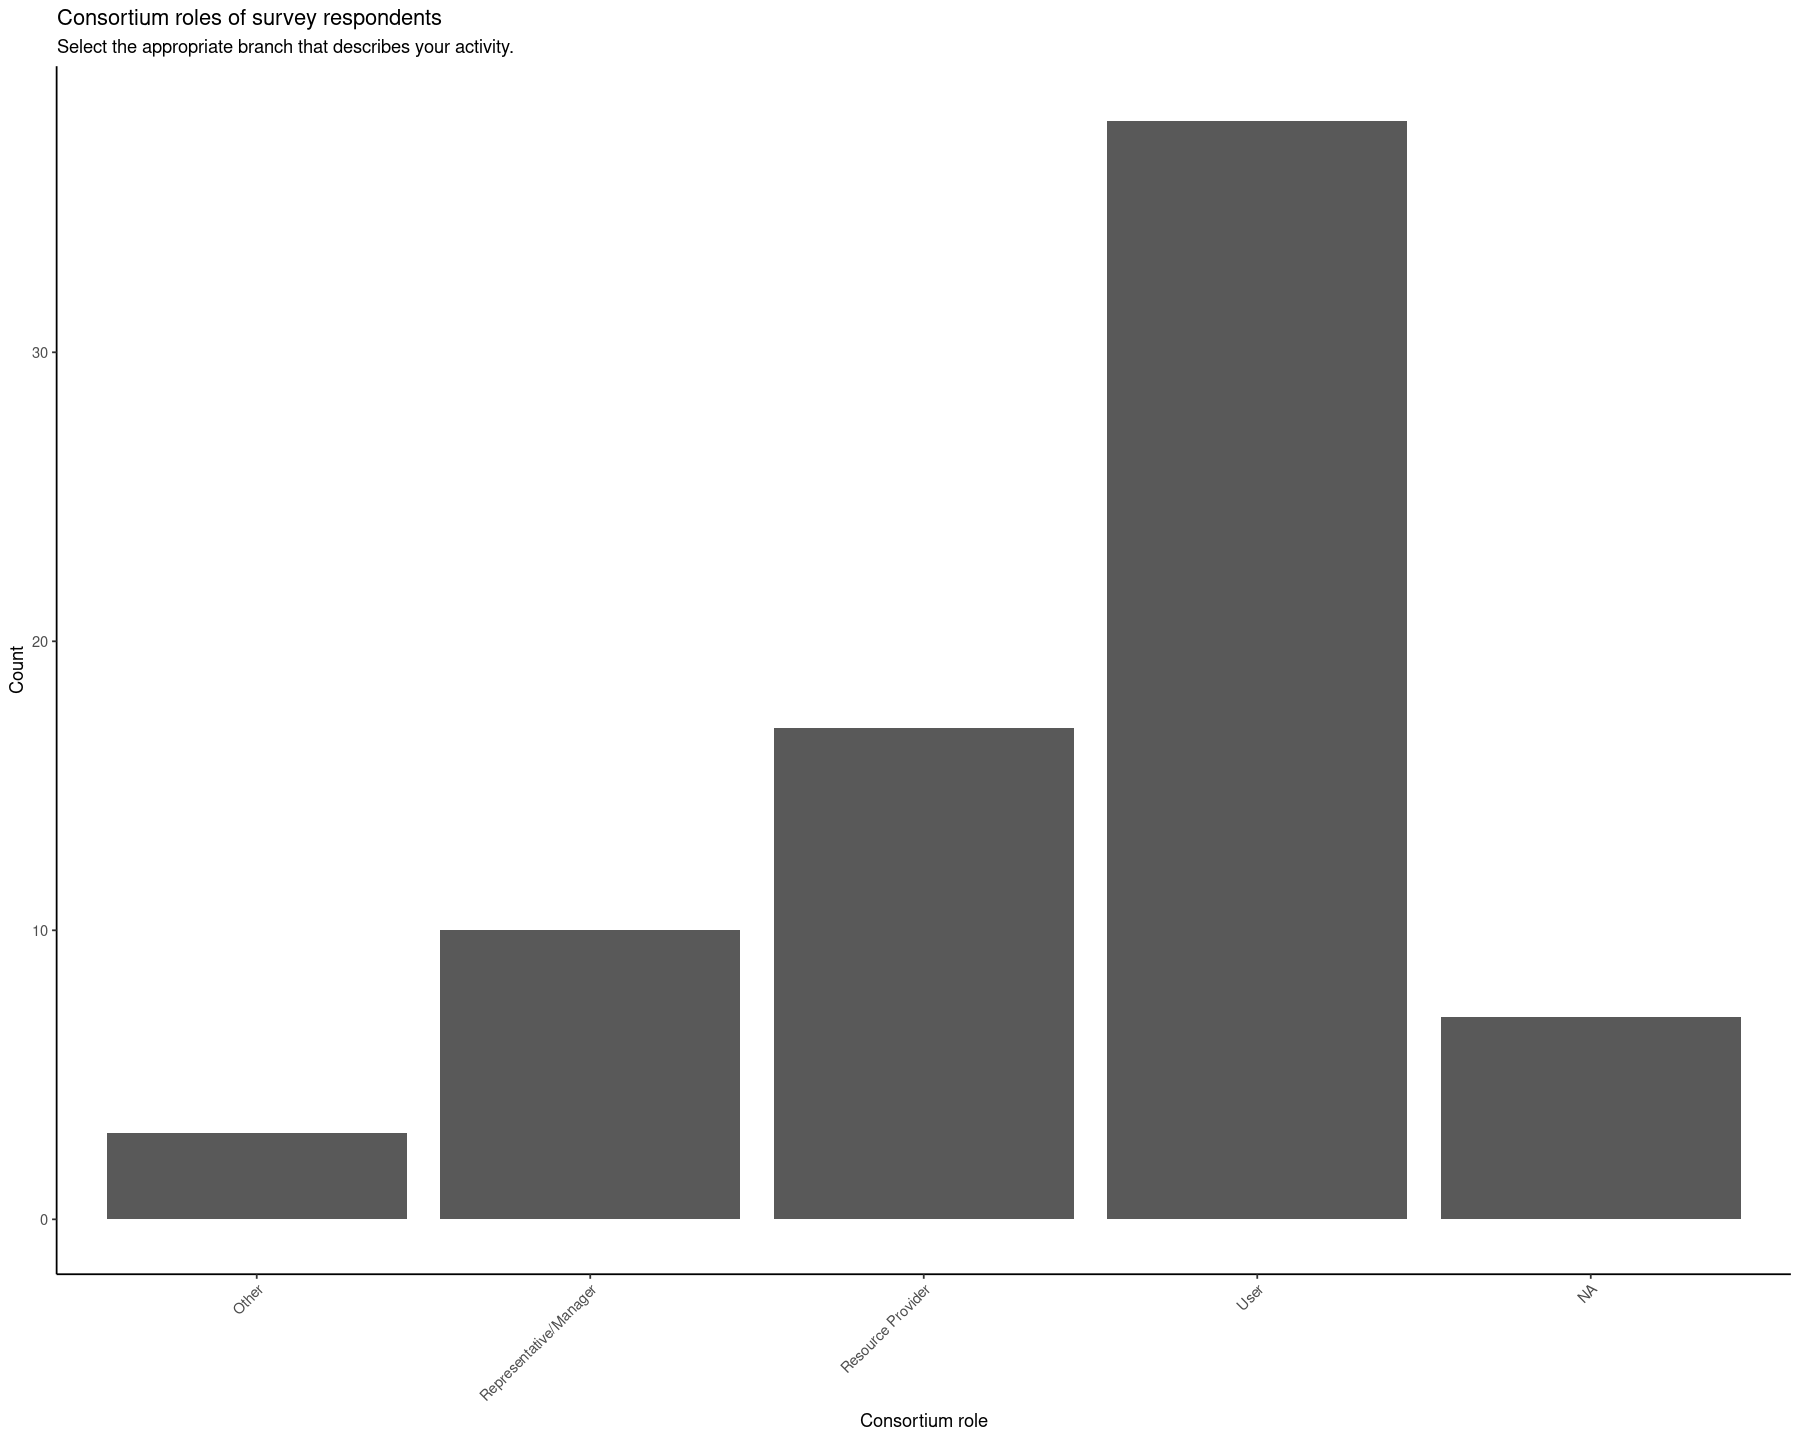

In [30]:
#| fig-align: center
# stacked bar chart
question_info$question_text[7]
q_text <- "Select the appropriate branch that describes your activity."

ggplot(data, aes(x = Q50_desc)) + 
  geom_bar() +
  labs(title = "Consortium roles of survey respondents",
       subtitle = q_text,
       x = "Consortium role",
       y = "Count") +
  theme_classic() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


## Knowing Jupyter by Consortium role

In [31]:
# know jupyter by role
#table(data$Q50_desc,data$know_jupyter4NFDI,useNA = "always")
#prop.table(table(data$Q50_desc,data$know_jupyter4NFDI,useNA = "always"))*100

know_jupy_by_cons_role_frame <- table(data$Q50_desc,data$know_jupyter4NFDI,useNA = "always")

# Optionally, create a nice table
know_jupy_by_cons_role_frame


                        
                         No Yes <NA>
  Other                   0   3    0
  Representative/Manager  6   4    0
  Resource Provider       6  11    0
  User                   21  17    0
  <NA>                    0   1    6

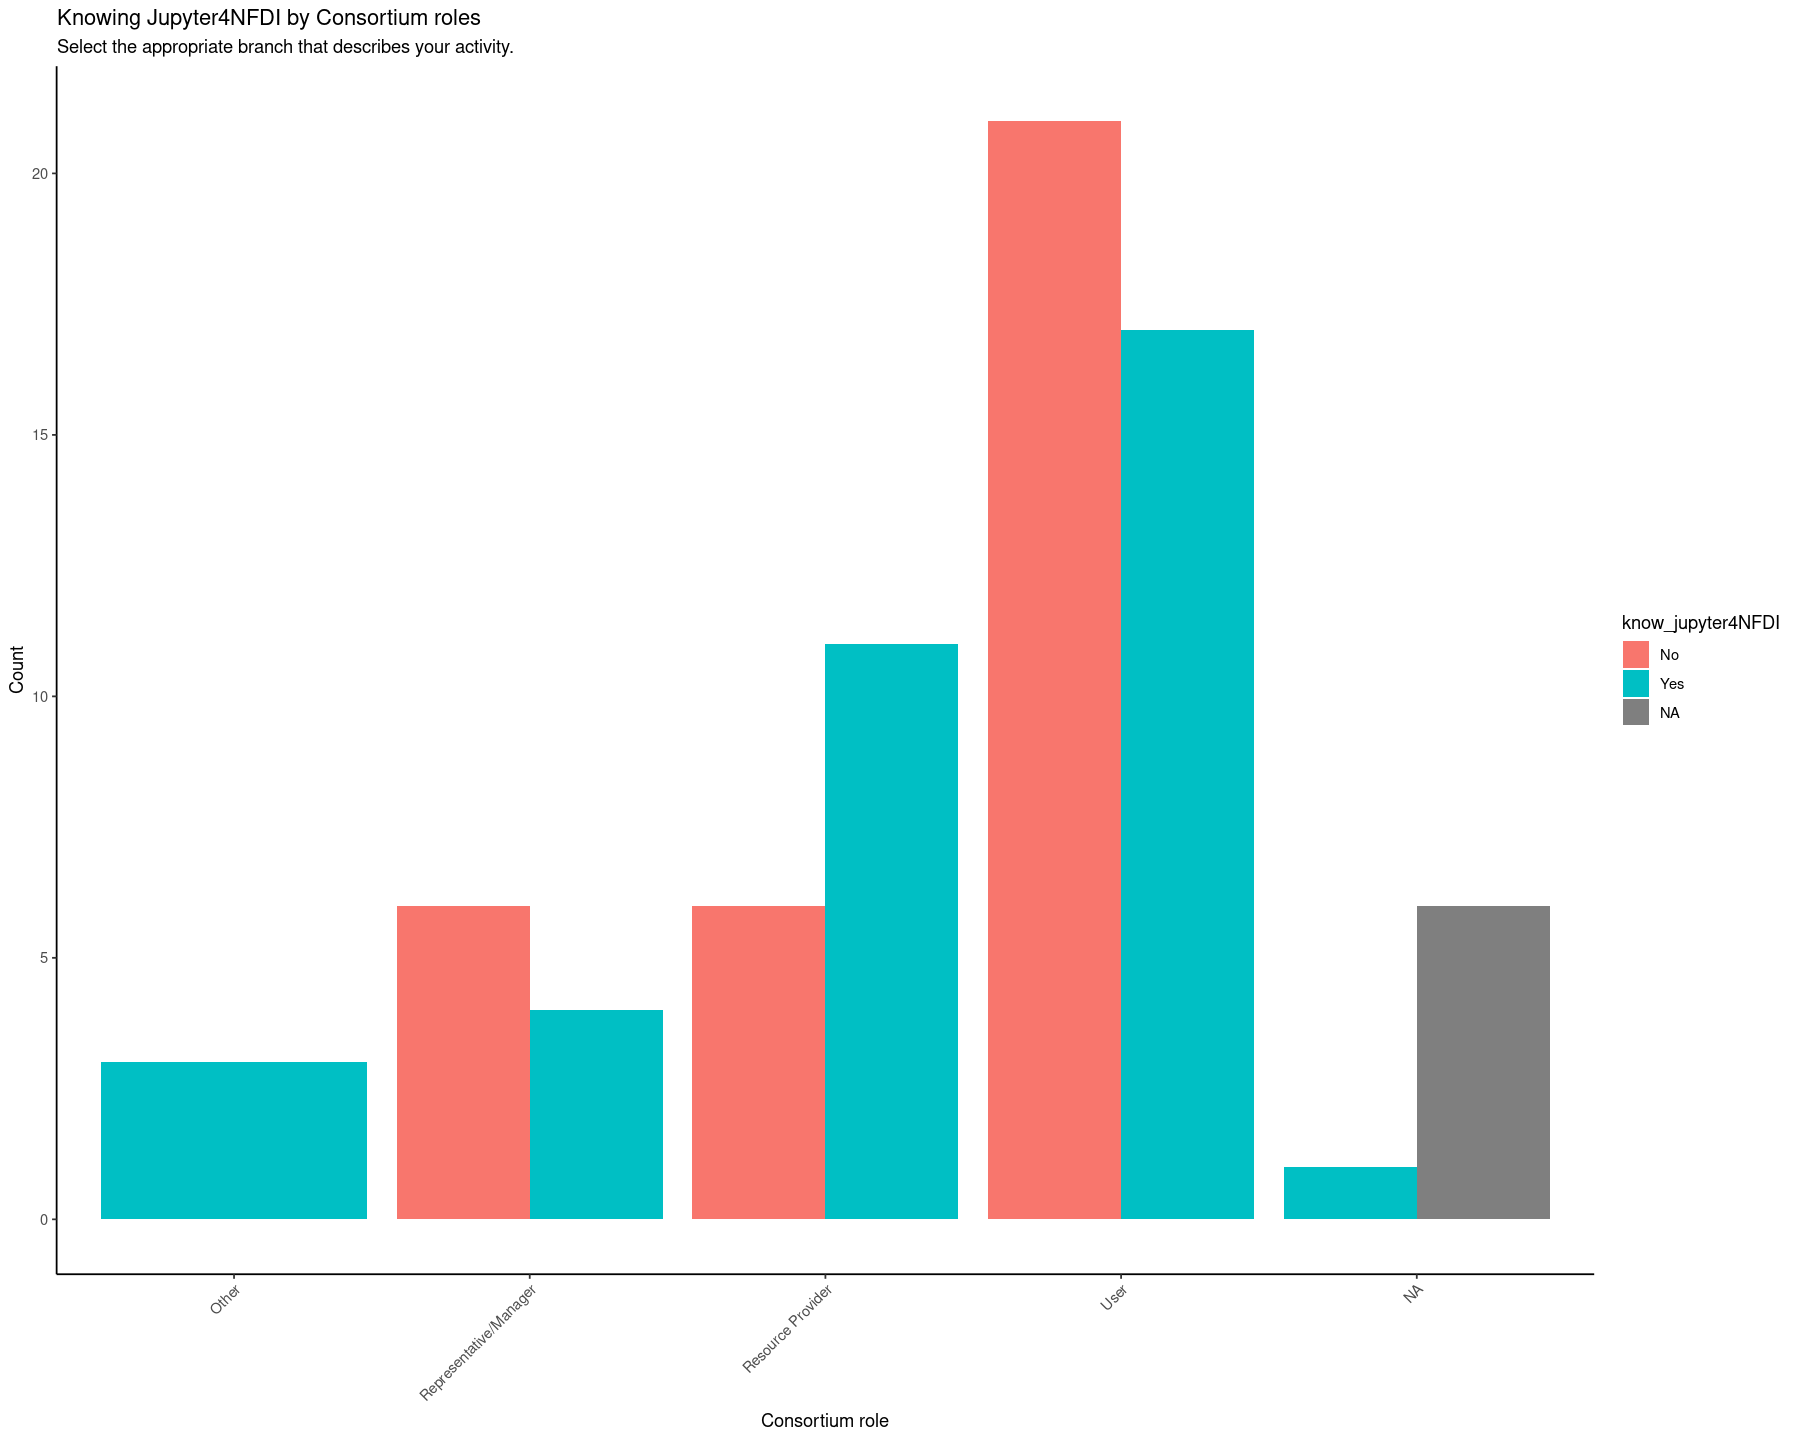

In [32]:
#| fig-align: center
# stacked bar chart
ggplot(data, aes(x = Q50_desc, fill = know_jupyter4NFDI)) + 
  geom_bar(position = "dodge") +
  labs(title = "Knowing Jupyter4NFDI by Consortium roles",
       subtitle = q_text,
       x = "Consortium role",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))




# Operating Management Responsibility

In [33]:
#data$operation_management_responsibiltiy_in_consortium[!is.na(data$operation_management_responsibiltiy_in_consortium)]
#table(data$operation_management_responsibiltiy_in_consortium,useNA = "always")
#prop.table(table(data$operation_management_responsibiltiy_in_consortium,useNA = "always"))*100

op_resp_frame <- as.data.frame(table(data$operation_management_responsibiltiy_in_consortium,useNA = "always"))

# Optionally, create a nice table
op_resp_frame

Var1,Freq
<fct>,<int>
No.,8
"Yes, I’m responsible for at least one infrastructure and one service.",4
"Yes, I’m responsible for at least one infrastructure.",1
"Yes, I’m responsible for at least one service.",2
NA,60


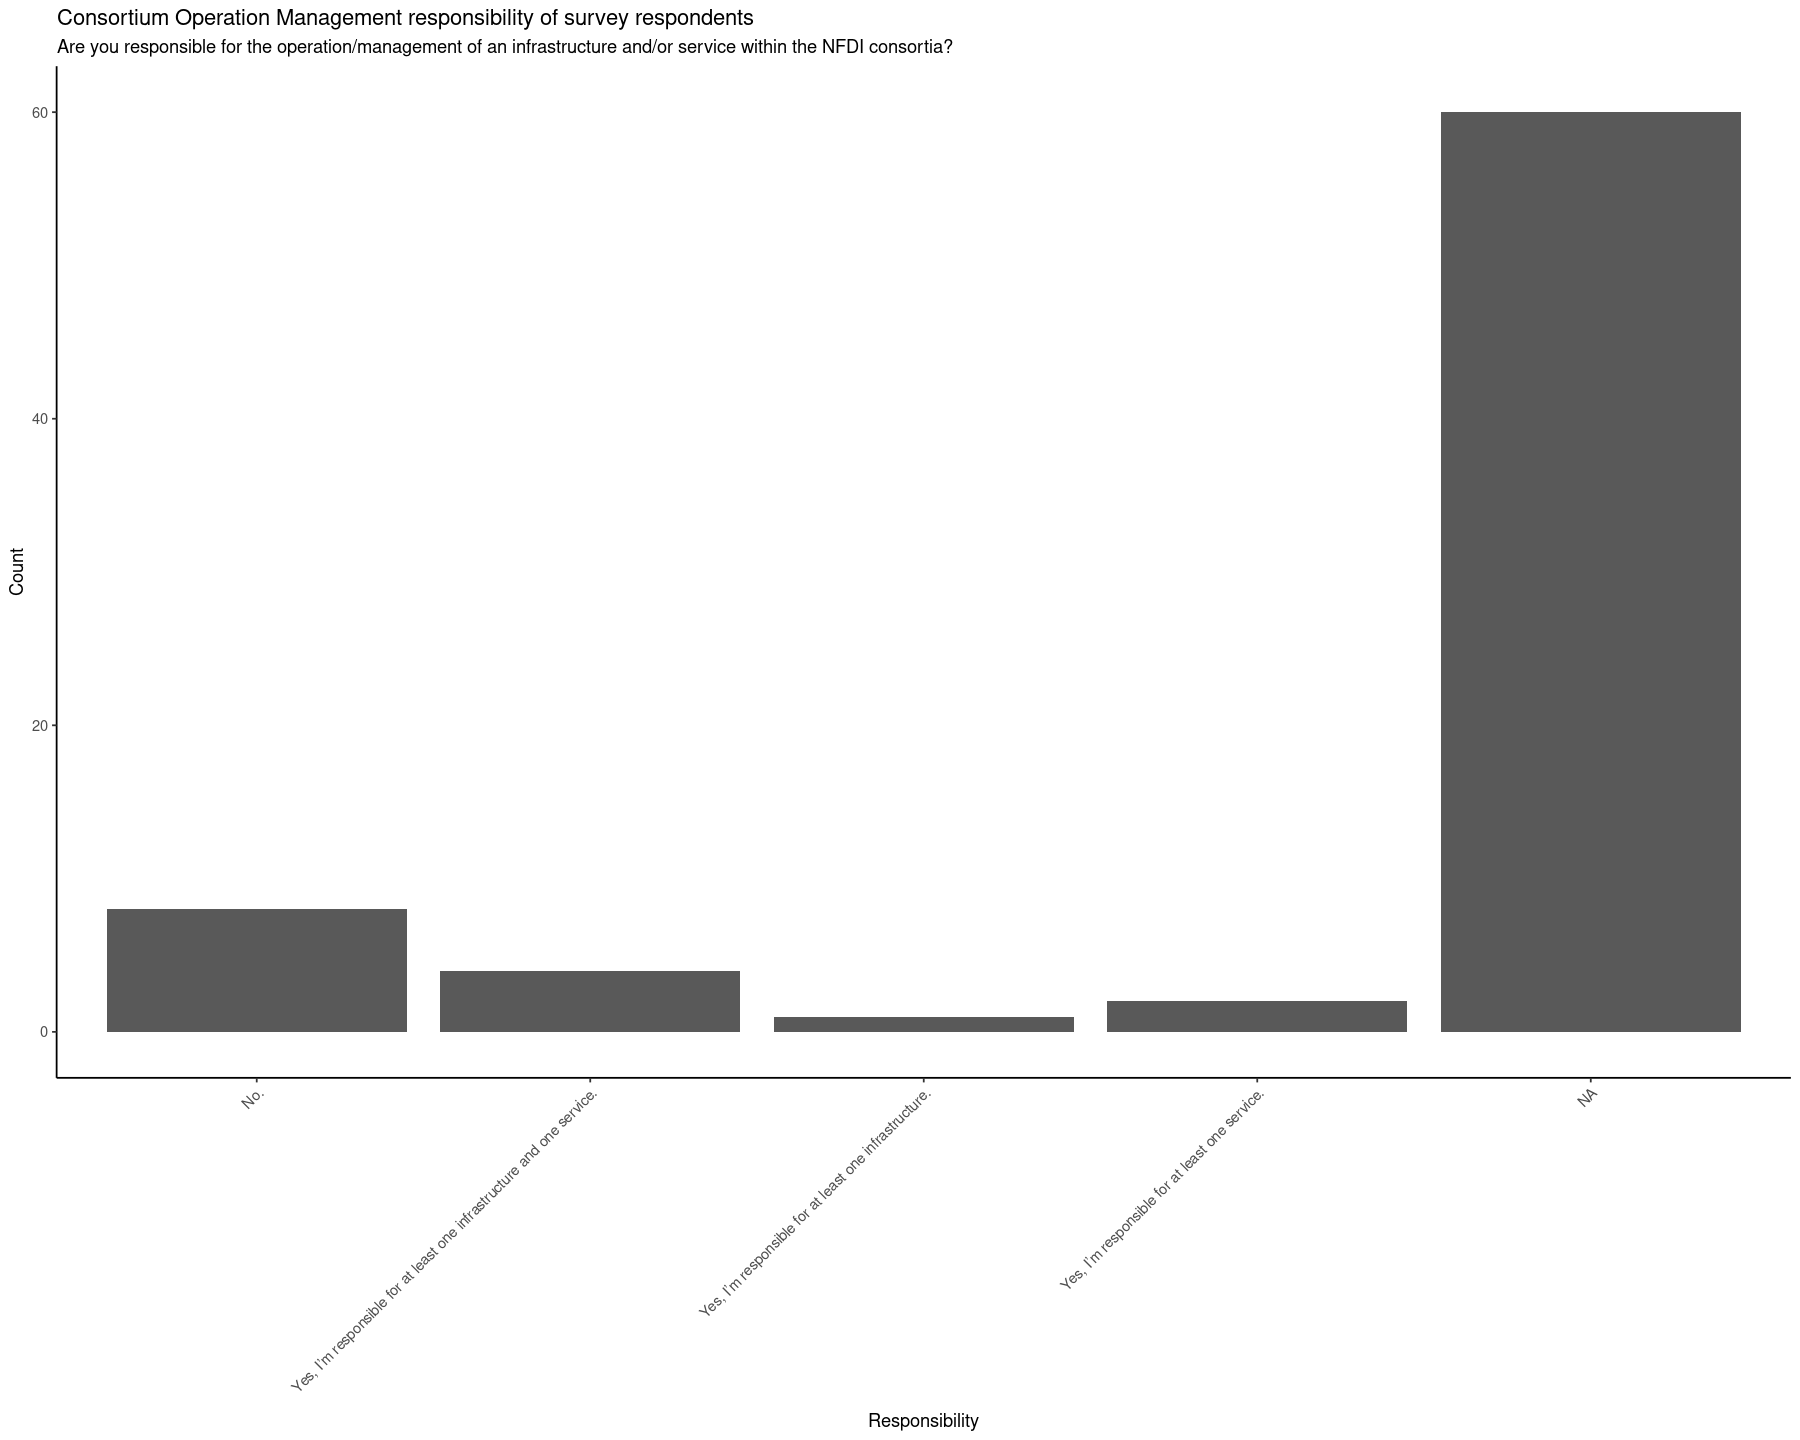

In [34]:
#| fig-align: center
# stacked bar chart
ggplot(data, aes(x = operation_management_responsibiltiy_in_consortium)) + 
  geom_bar() +
  labs(title = "Consortium Operation Management responsibility of survey respondents",
       subtitle = question_info$question_text[8],
       x = "Responsibility",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Op Management Responsibility by knowing Jupyter

In [35]:
# know jupyter by responsibility
#table(data$operation_management_responsibiltiy_in_consortium,data$know_jupyter4NFDI,useNA = "always")
#prop.table(table(data$operation_management_responsibiltiy_in_consortium,data$know_jupyter4NFDI,useNA = "always"))*100

op_resp_by_jup_frame <- as.data.frame(table(data$operation_management_responsibiltiy_in_consortium,data$know_jupyter4NFDI,useNA = "always"))


# Pivot the table to a wide format (to prevent long format)
op_resp_by_jup_frame2 <- reshape(op_resp_by_jup_frame,
                 idvar = "Var1",
                 timevar = "Var2",
                 direction = "wide")

# Optionally, create a nice table
op_resp_by_jup_frame2

Warning message in reshapeWide(data, idvar = idvar, timevar = timevar, varying = varying, :
“there are records with missing times, which will be dropped.”


,Var1,Freq.No,Freq.Yes,Freq.NA
,<fct>,<int>,<int>,<int>
1,No.,3,5,0
2,"Yes, I’m responsible for at least one infrastructure and one service.",1,3,0
3,"Yes, I’m responsible for at least one infrastructure.",1,0,0
4,"Yes, I’m responsible for at least one service.",1,1,0
5,NA,27,27,6


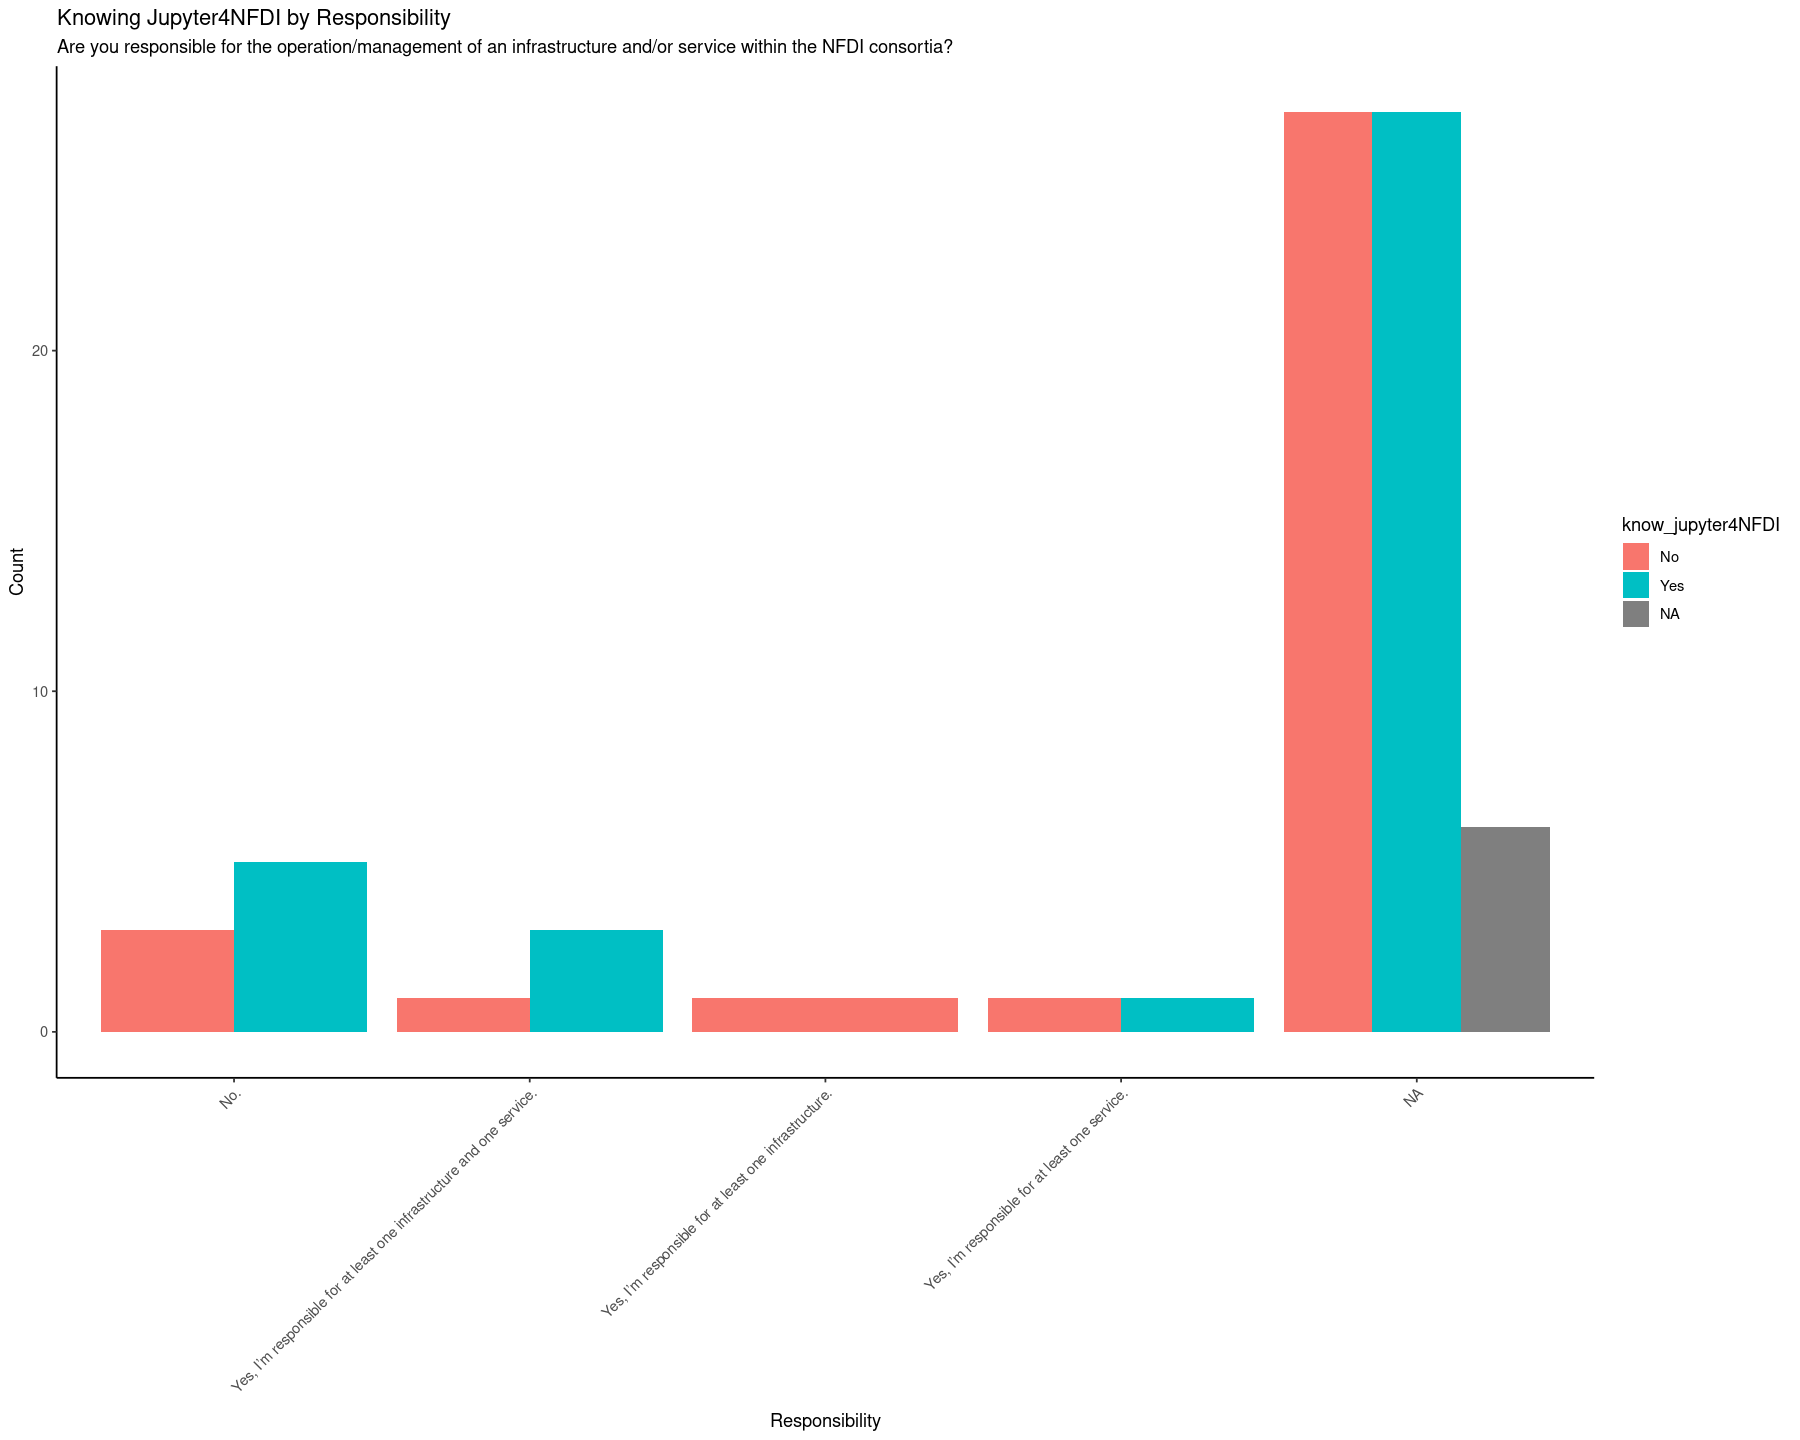

In [36]:
#| fig-align: center
# stacked bar chart
ggplot(data, aes(x = operation_management_responsibiltiy_in_consortium, fill = know_jupyter4NFDI)) + 
  geom_bar(position = "dodge") +
  labs(title = "Knowing Jupyter4NFDI by Responsibility",
       subtitle = question_info$question_text[8],
       x = "Responsibility",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# IaaS Cloud Cluster

Var1,Freq
<fct>,<int>
No,8
Yes,7
NA,60


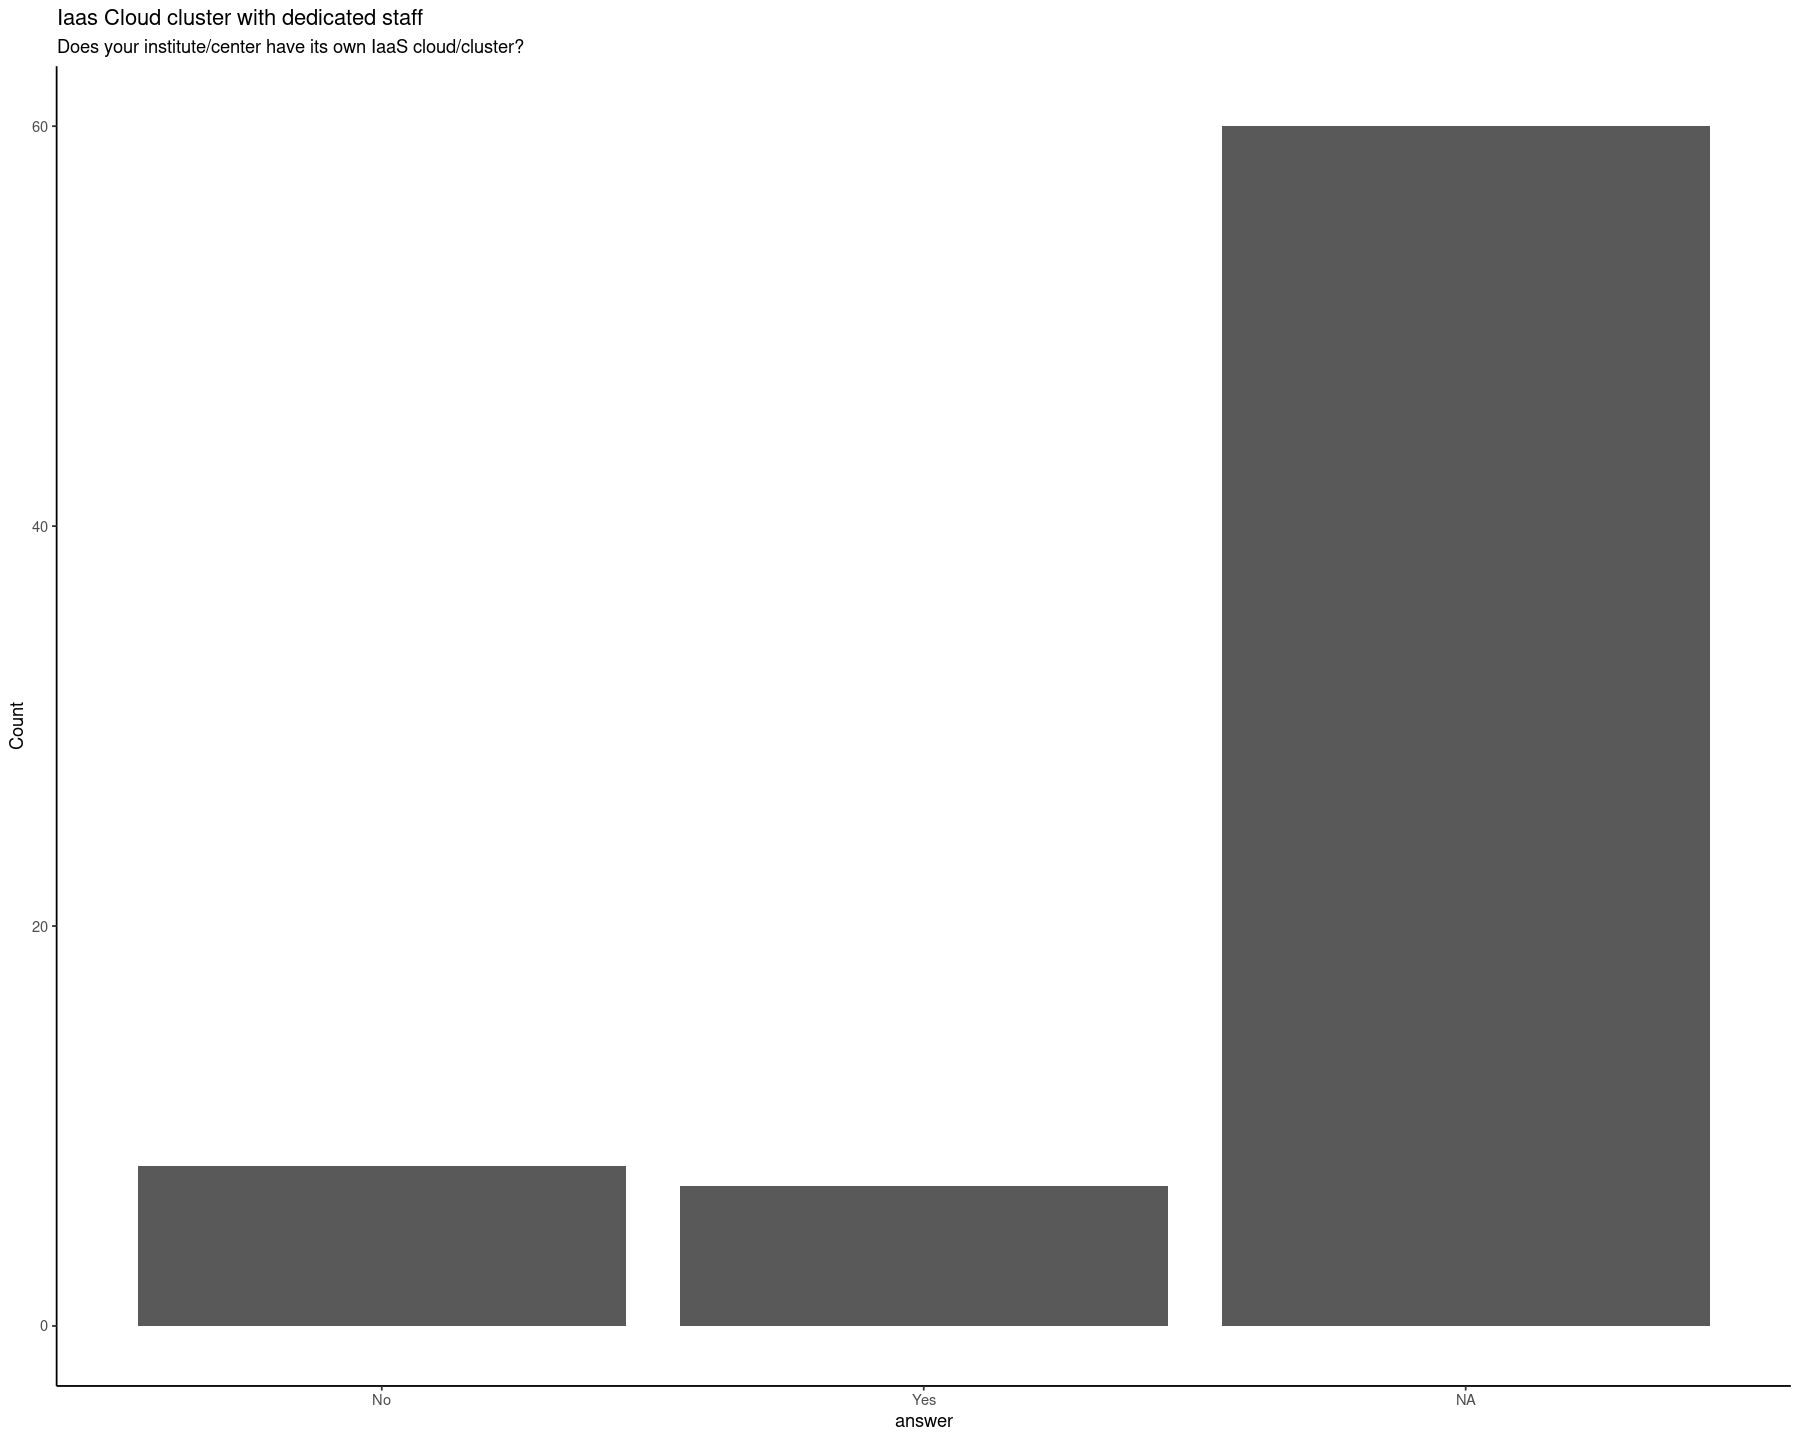

In [37]:
#| fig-align: center

data.frame(table(data$IaaS.cloud.cluster_yes, useNA = "always"))
#prop.table(table(data$IaaS.cloud.cluster_yes, useNA = "always"))*100

# stacked bar chart
ggplot(data, aes(x = IaaS.cloud.cluster_yes)) + 
  geom_bar() +
  labs(title = "Iaas Cloud cluster with dedicated staff",
       subtitle = question_info$question_text[9],
       x = "answer",
       y = "Count") +
  theme_classic()



Var1,Freq
<fct>,<int>
No,8
Yes,7
NA,60


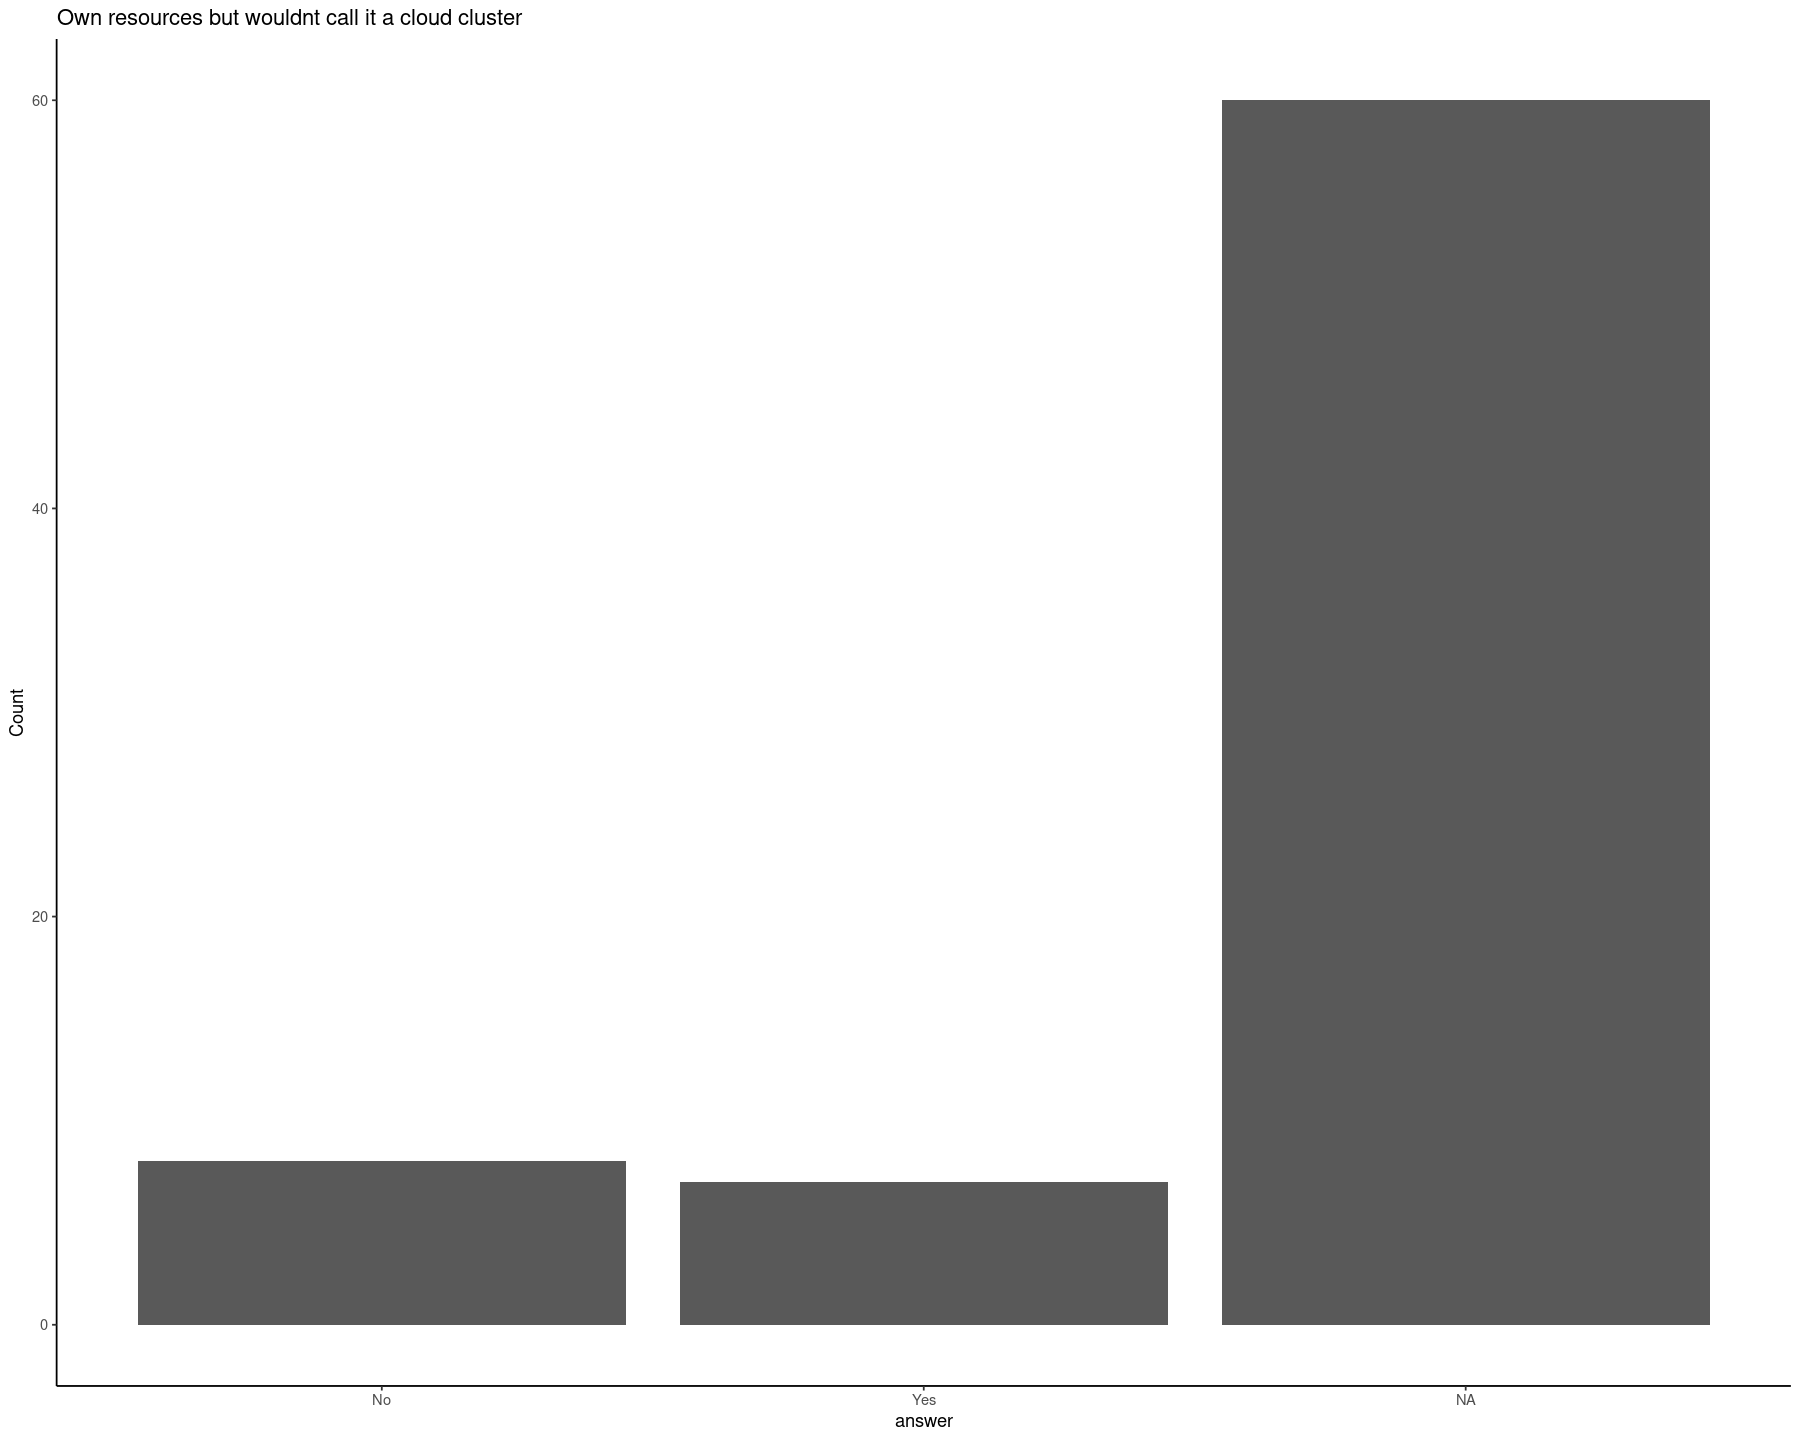

In [38]:
#| fig-align: center

data.frame(table(data$IaaS.cloud.cluster_no, useNA = "always"))

# stacked bar chart
ggplot(data, aes(x = IaaS.cloud.cluster_no)) + 
  geom_bar() +
  labs(title = "Own resources but wouldnt call it a cloud cluster",
       x = "answer",
       y = "Count") +
  theme_classic()


## IaaS Cloud Cluster other

In [39]:
# Other cloud cluster responses
data$IaaS.cloud.cluster_other[!is.na(data$IaaS.cloud.cluster_other)]

[1] "I am not sure" "no"

# Cloud Cluster

In [40]:
invisible(capture.output({
cloud_cluster_frame <- data[,55:57]
sapply(cloud_cluster_frame, class)
for (i in 1:dim(cloud_cluster_frame)[2]) {
  cloud_cluster_frame[,i] <- as.factor(cloud_cluster_frame[,i])
}
cloud_cluster_frame <- sapply(cloud_cluster_frame,as.numeric)
cloud_cluster_frame <- (cloud_cluster_frame - 1)
sums <- as.data.frame(colSums(cloud_cluster_frame, na.rm = TRUE))
colnames(sums) <- "Value"
sums$Name <- rownames(sums)

}))

In [41]:
row.names(sums) <- NULL
sums[,c(2,1)]


Name,Value
<chr>,<dbl>
cloud_cluster_bare_metal,9
cloud_cluster_open_stack,3
cloud_cluster_kubernetes,6


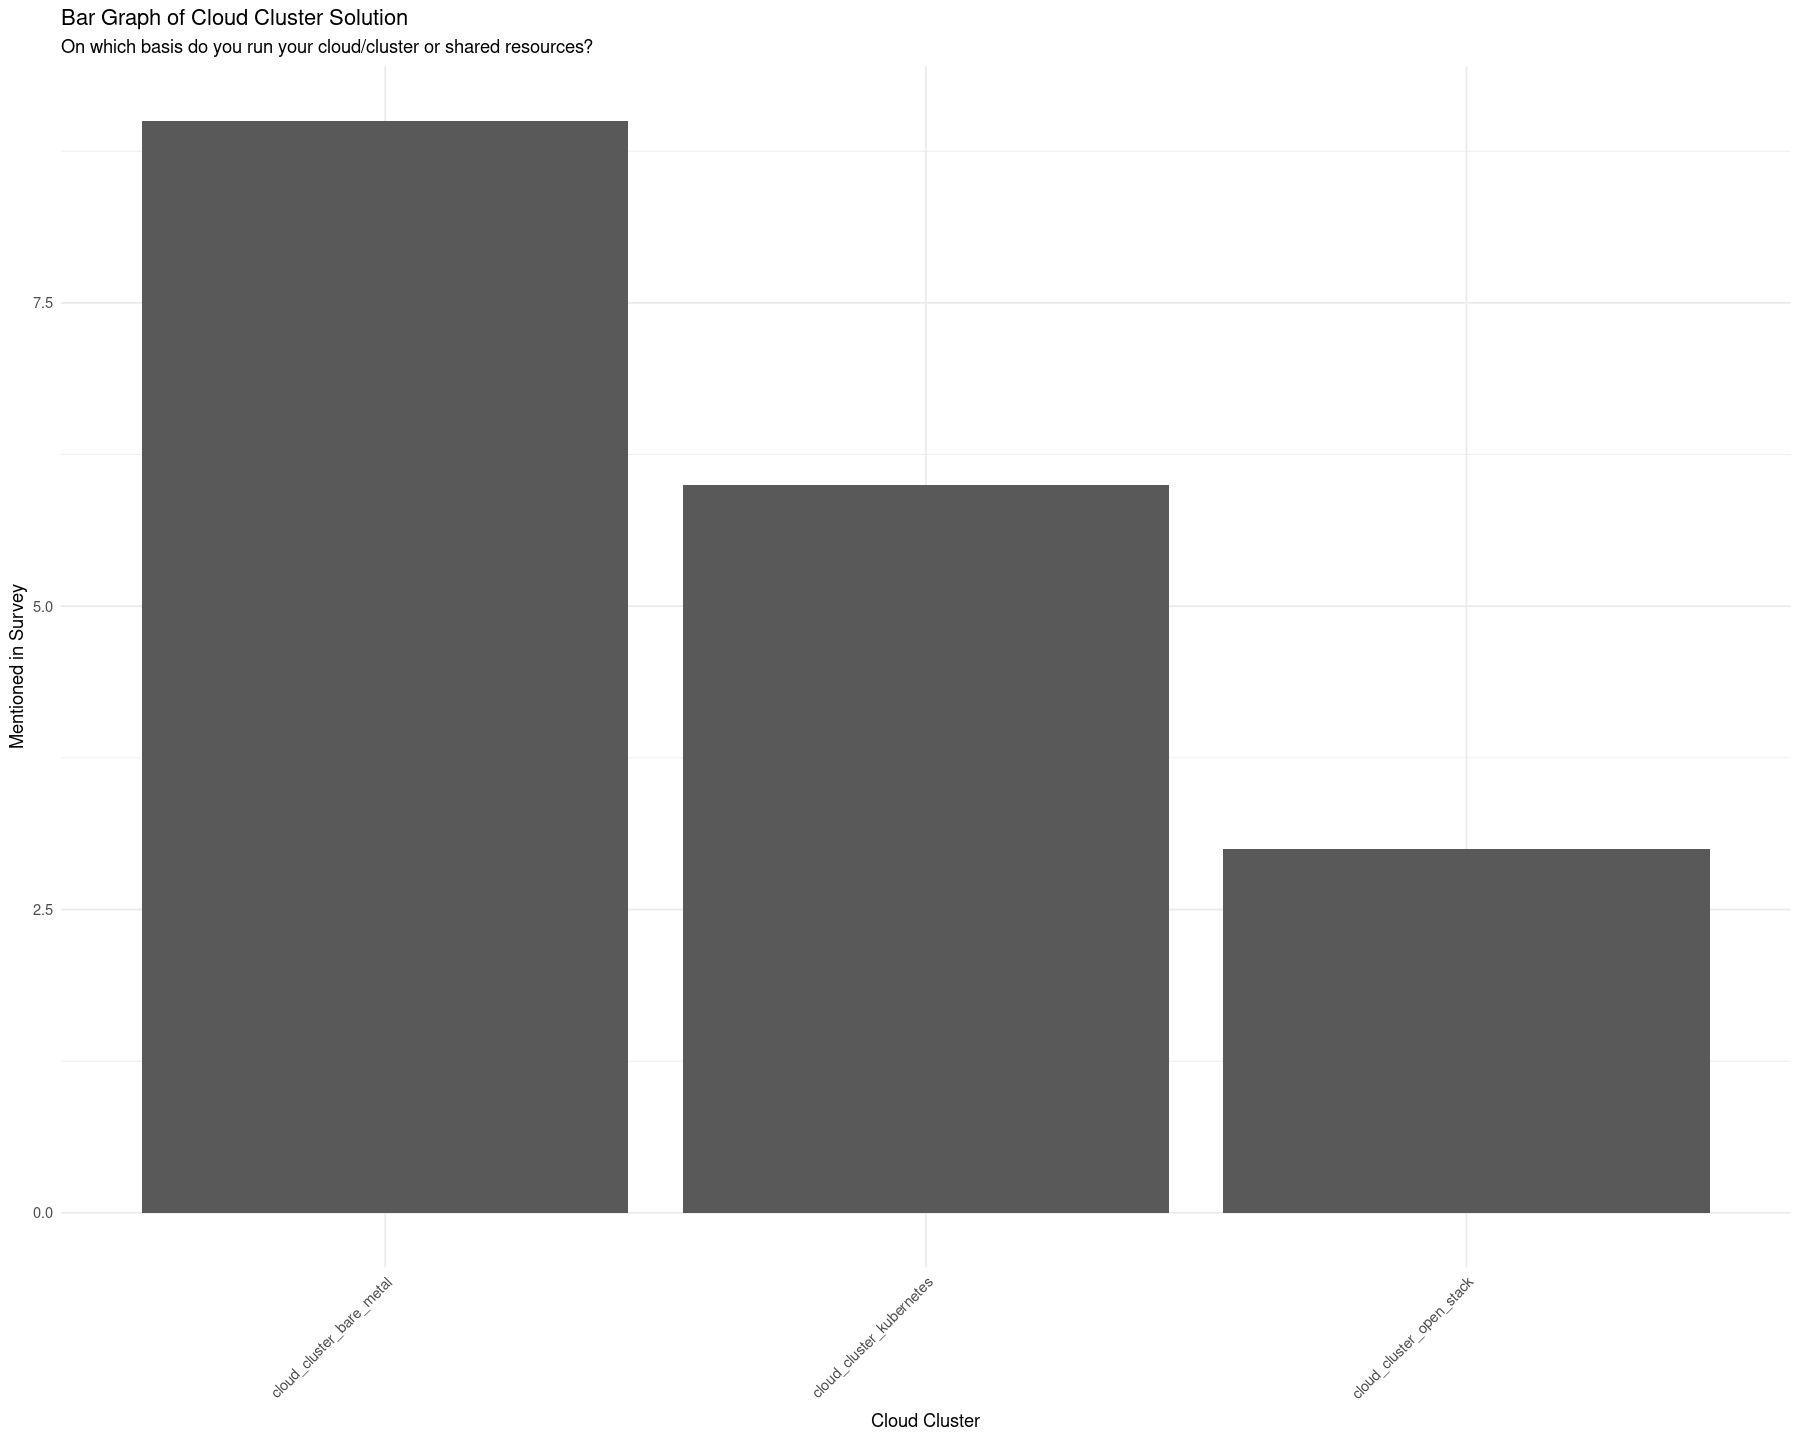

In [42]:
#| fig-align: center

# Create bar graph
ggplot(sums, aes(x = reorder(Name, -Value), y = Value)) + 
  geom_bar(stat = "identity") +
  labs(
    title = "Bar Graph of Cloud Cluster Solution",
    subtitle = question_info$question_text[10],
    x = "Cloud Cluster",
    y = "Mentioned in Survey"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Cloud Cluster other

In [43]:
# other NFDI
data$cloud_cluster_other[!is.na(data$cloud_cluster_other)]

[1] "libvirt / KVM, HTCondor with containers"
[2] "VMware"                                 
[3] "Docker, VM"                             
[4] "BinderHub"

# Using JupyterHub (or similar)

In [44]:
# table(data$use_jupyterhub_or_similar, useNA = "always")
# prop.table(table(data$use_jupyterhub_or_similar, useNA = "always"))*100
jupyter_hub_frame <- data.frame(table(data$use_jupyterhub_or_similar, useNA = "always"))
jupyter_hub_frame

Var1,Freq
<fct>,<int>
JupyterHub,8
No,5
Similar service,2
NA,60


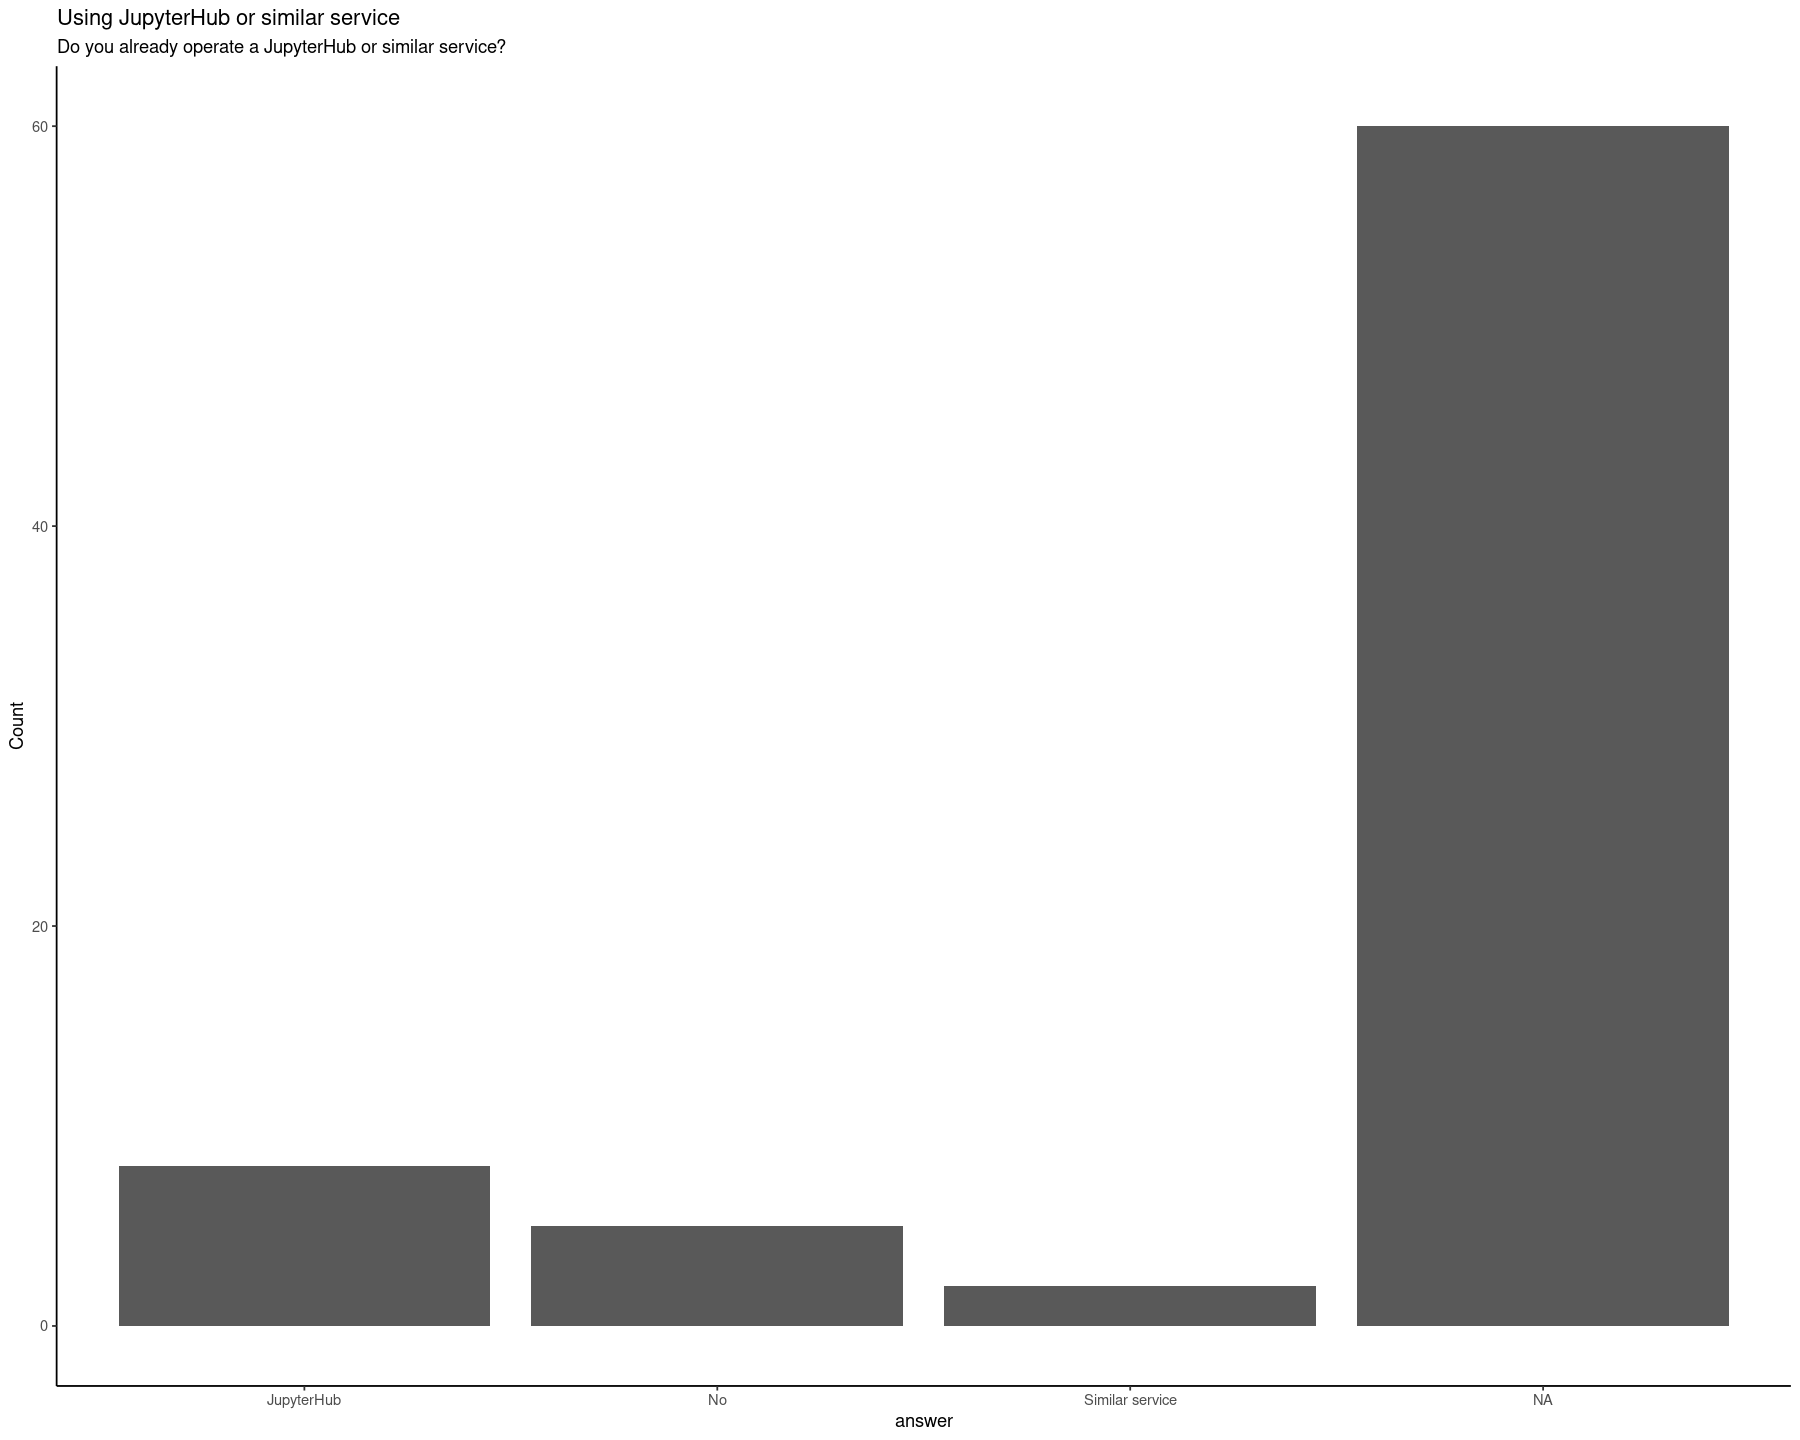

In [45]:
#| fig-align: center

# stacked bar chart
ggplot(data, aes(x = use_jupyterhub_or_similar)) + 
  geom_bar() +
  labs(title = "Using JupyterHub or similar service",
       subtitle = question_info$question_text[11],
       x = "answer",
       y = "Count") +
  theme_classic()


## Other Services

In [46]:
# which similar
data$use_which_similar[!is.na(data$use_which_similar)]

[1] "ArcGIS Notebookserver" "Galaxy"

In [47]:
# links
data$use_which_similar_link[!is.na(data$use_which_similar_link)]
links <- rm_url(data$use_which_similar_link[!is.na(data$use_which_similar_link)], extract = T)
links <- unlist(links)
links <- links[!is.na(links)]
links


[1] "No: in development / internal"      "https://jupyterhub.uni-muenster.de"
[3] "No, it is for internal use only."   "currently internal"                
[5] "No, internal-only"                  "not available publicly"            
[7] "https://jhub.photonicdata.science"  "https://usegalaxy.eu"

[1] "https://jupyterhub.uni-muenster.de" "https://jhub.photonicdata.science" 
[3] "https://usegalaxy.eu"

# Spawner Use

In [48]:
#table(data$spawner_use, useNA = "always")
#prop.table(table(data$spawner_use, useNA = "always"))*100
spawner_frame <- data.frame(table(data$spawner_use, useNA = "always"))
spawner_frame

Var1,Freq
<fct>,<int>
DockerSpawner,1
KubeSpawner,4
LocalSpawner,1
Other,2
NA,67


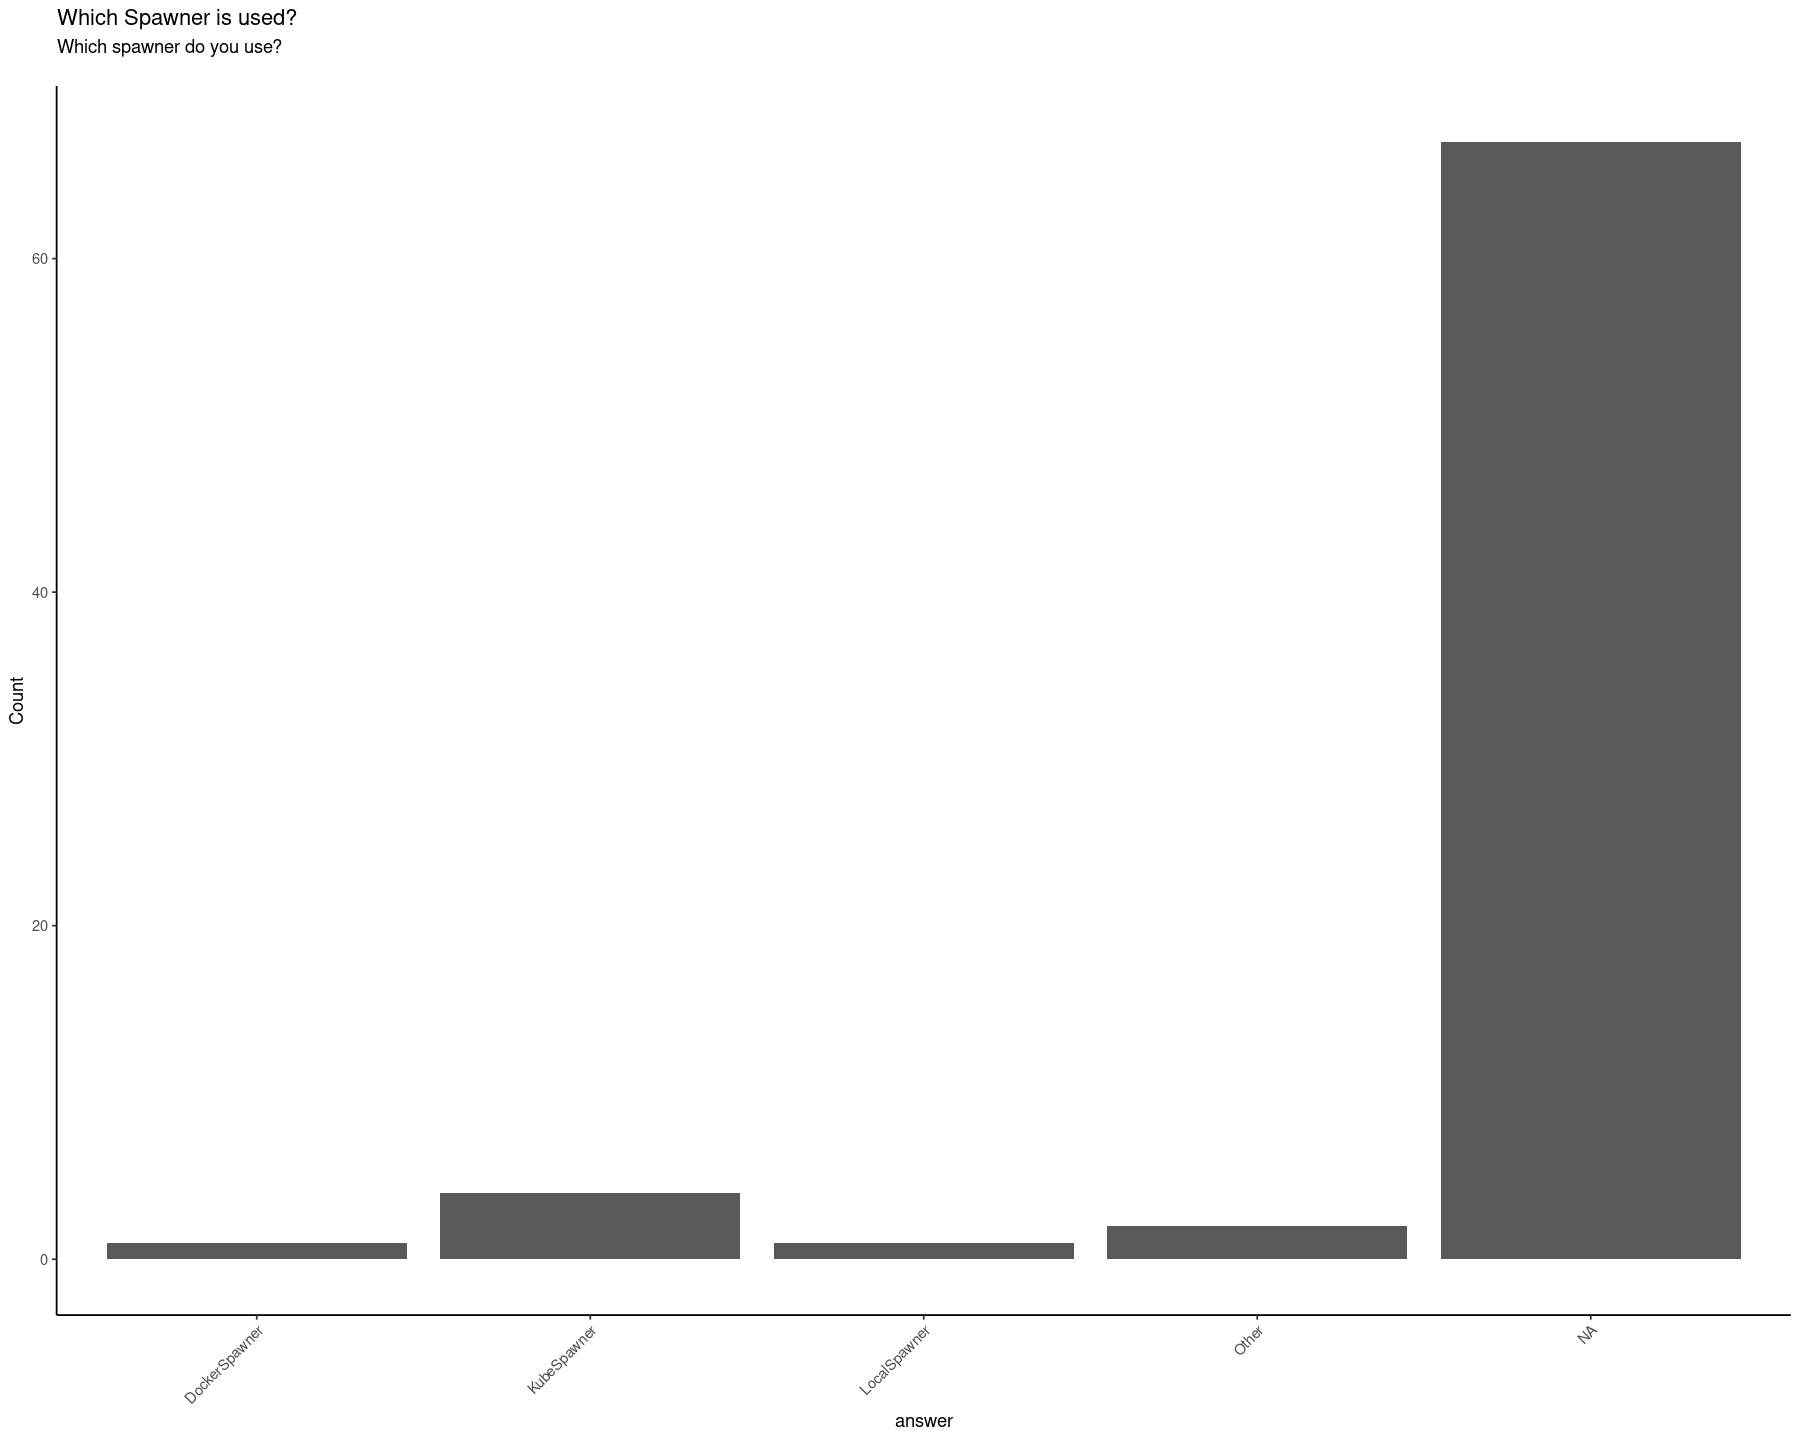

In [49]:
#| fig-align: center
# stacked bar chart
ggplot(data, aes(x = spawner_use)) + 
  geom_bar() +
  labs(title = "Which Spawner is used?",
       subtitle = question_info$question_text[14],
       x = "answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Other Spawners

In [50]:

# which similar
data$spawner_use_other[!is.na(data$spawner_use_other)]



[1] "BatchSpawner extended with public code for safe use with federated computing infrastructures. "

# Willingness to connect to JupyterHub

In [51]:
# Willingness to connect own resources to central JupyterHub
#table(data$spawner_use, useNA = "always")
#prop.table(table(data$spawner_use, useNA = "always"))*100
willingness_frame <- data.frame(table(data$willing_to_connect_resources_to_jupyterhub, useNA = "always"))
willingness_frame


Var1,Freq
<fct>,<int>
No,11
"Yes, but only for a specified group of users",4
NA,60


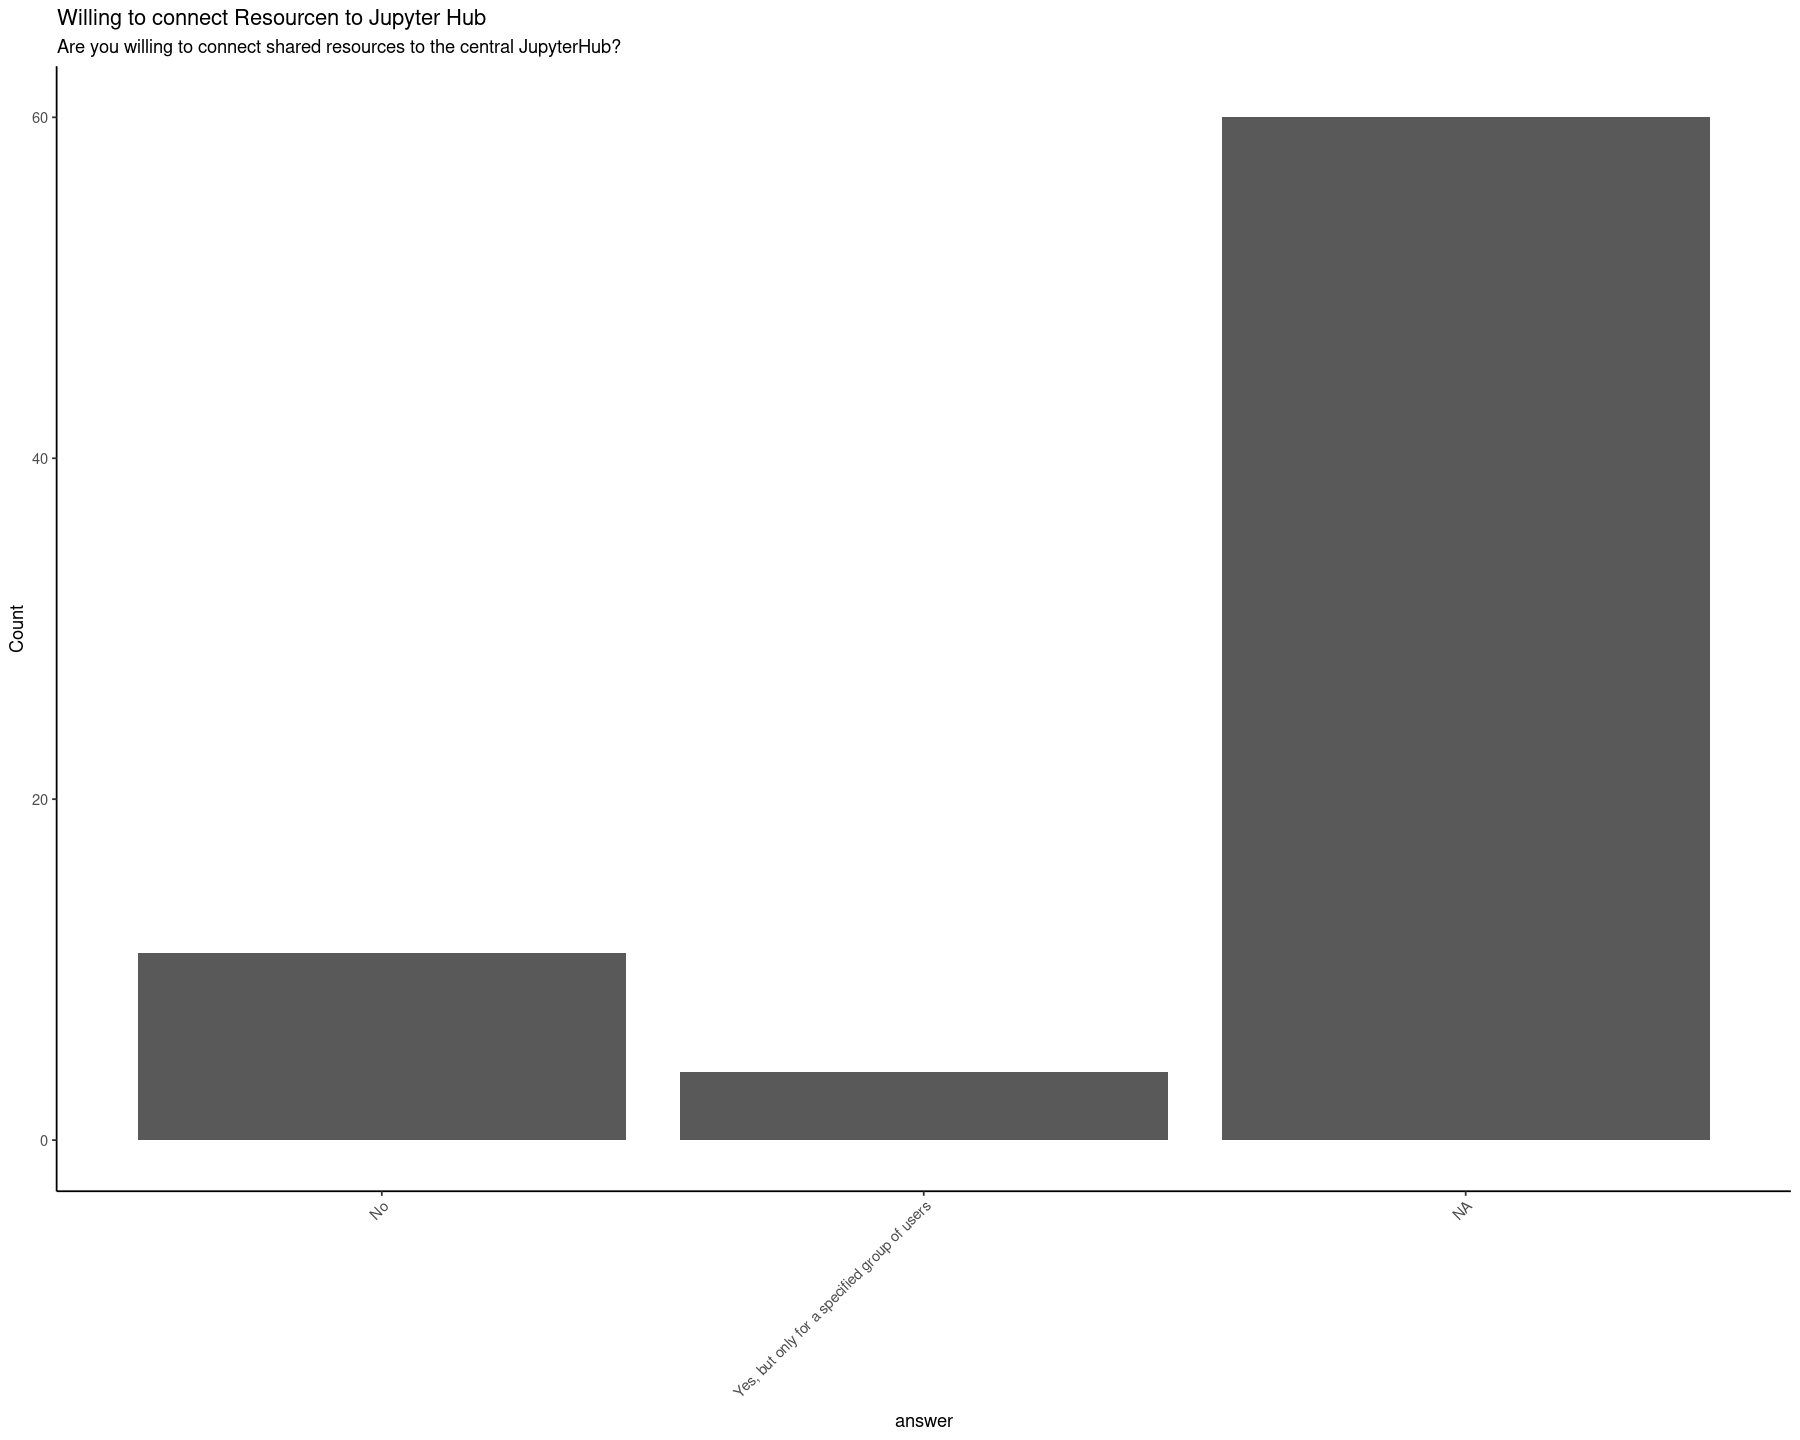

In [52]:
#| fig-align: center
# stacked bar chart
ggplot(data, aes(x = willing_to_connect_resources_to_jupyterhub)) + 
  geom_bar() +
  labs(title = "Willing to connect Resourcen to Jupyter Hub",
       subtitle = question_info$question_text[15],
       x = "answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))




# Eligible User Groups for shared Resources

In [53]:
invisible(capture.output({
data$eligible_users_local  <- as.factor(data$eligible_users_local)
data$eligible_users_local <- factor(data$eligible_users_local, levels = c(levels(data$eligible_users_local), "No"))
table(data$eligible_users_local,useNA = "always")
prop.table(table(data$eligible_users_local,useNA = "always"))*100

table(data$eligible_users_NFDI,useNA = "always")
prop.table(table(data$eligible_users_NFDI,useNA = "always"))*100

table(data$eligible_users_external,useNA = "always")
prop.table(table(data$eligible_users_external,useNA = "always"))*100

eligible_frame <- rbind.data.frame(table(data$eligible_users_local,useNA = "always"),
                                   table(data$eligible_users_NFDI,useNA = "always"),
                                   table(data$eligible_users_external,useNA = "always"))
eligible_frame <- cbind.data.frame(User = c("local","NFDI","external"),eligible_frame)
colnames(eligible_frame) <- c("User","Yes","No","NA")

eligible_frame_long <- tidyr::pivot_longer(
  eligible_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)

}))

In [54]:
eligible_frame_long

User,Response,Count
<chr>,<chr>,<int>
local,Yes,4
local,No,0
local,NA,71
NFDI,Yes,2
NFDI,No,2
NFDI,NA,71
external,Yes,2
external,No,2
external,NA,71


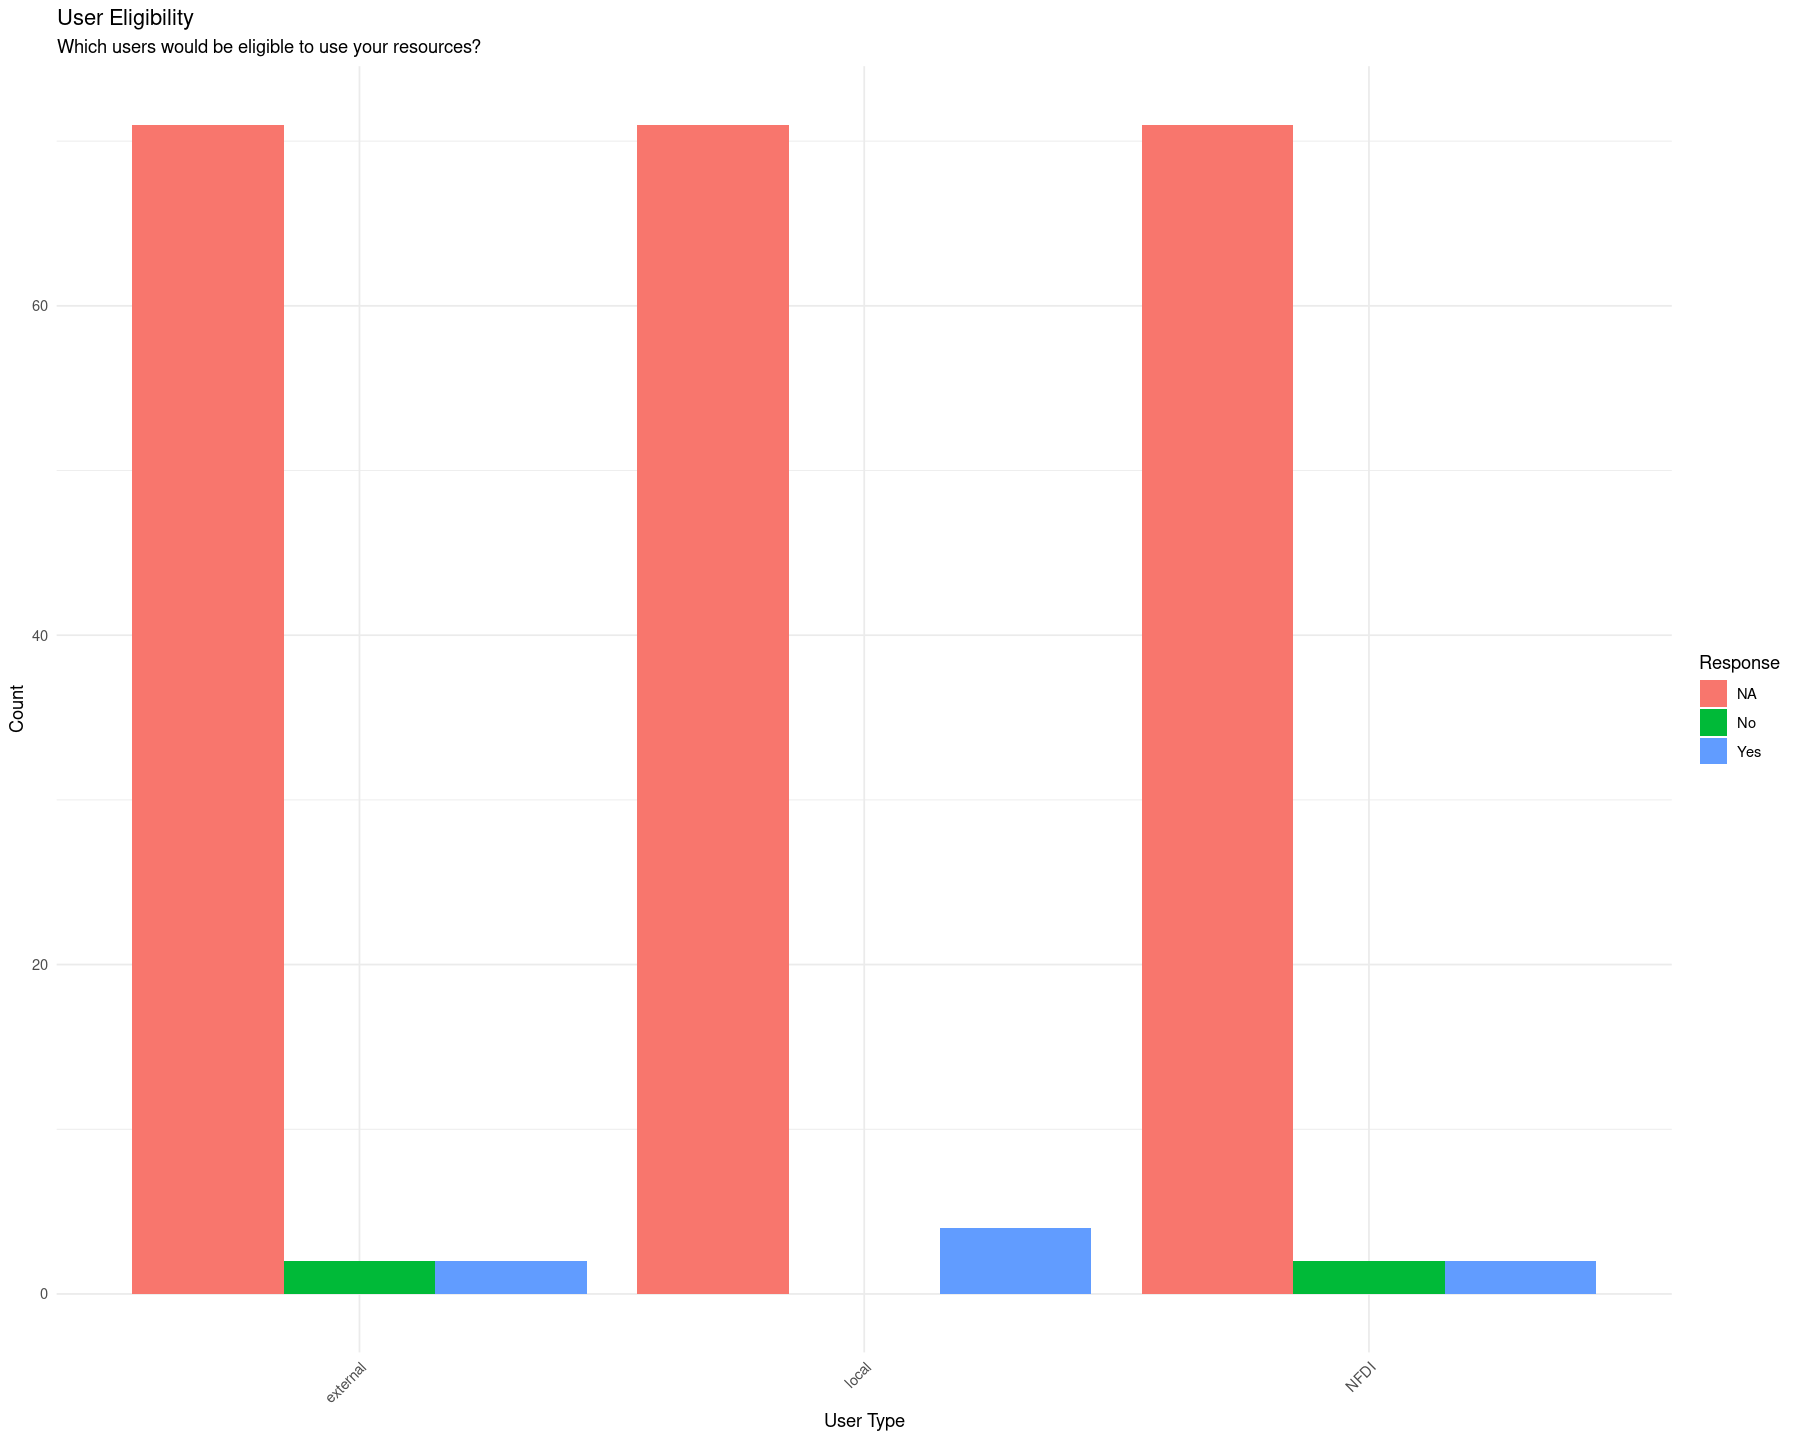

In [55]:
#| fig-align: center
# Create the dodged bar graph
ggplot(eligible_frame_long, aes(x = User, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "User Eligibility",
    subtitle = question_info$question_text[16],
    x = "User Type",
    y = "Count",
    fill = "Response"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# User Groups in NFDI

In [56]:
# User groups in NFDI
data$user_groups_in_NFDI[!is.na(data$user_groups_in_NFDI)]


[1] "Photon and Neutron community"  "Primarily PAN community users"

# Shared Resources Offer

In [57]:

# Shared resources offer
data$shared_resources_offer[!is.na(data$shared_resources_offer)]


[1] "tbd."     "not suer" "TDB"

# Shared Resources Policies

In [58]:
# shared resources policies
data$shared_resources_policies[!is.na(data$shared_resources_policies)]




[1] "https://mlz-garching.de/englisch/user-office/terms-of-reference.html"
[2] "TDB"

# Expected Benefits from sharing

In [59]:
invisible(capture.output({
table(data$benefits_from_sharing_less_maintenance,useNA = "always")
prop.table(table(data$benefits_from_sharing_less_maintenance,useNA = "always"))*100

table(data$benefits_from_sharing_concentrate_on_hardware,useNA = "always")
prop.table(table(data$benefits_from_sharing_concentrate_on_hardware,useNA = "always"))*100

table(data$benefits_from_sharing_centrailized_AAI_and_user_mngmt,useNA = "always")
prop.table(table(data$benefits_from_sharing_centrailized_AAI_and_user_mngmt,useNA = "always"))*100

table(data$benefits_from_sharing_enhanced_visibility,useNA = "always")
prop.table(table(data$benefits_from_sharing_enhanced_visibility,useNA = "always"))*100

benefits_frame <- rbind.data.frame(table(data$benefits_from_sharing_less_maintenance,useNA = "always"),
                                   table(data$benefits_from_sharing_concentrate_on_hardware,useNA = "always"),
                                   table(data$benefits_from_sharing_centrailized_AAI_and_user_mngmt,useNA = "always"),
                                   table(data$benefits_from_sharing_enhanced_visibility,useNA = "always"))


benefits_frame <- cbind.data.frame(User = c("less_maintenance","focus_on_hardware","centrailized_AAI_user_mngmt","enhanced_visibility"), benefits_frame)
colnames(benefits_frame) <- c("Benefit","Yes","No","NA")

benefits_frame_long <- tidyr::pivot_longer(
  benefits_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)

}))

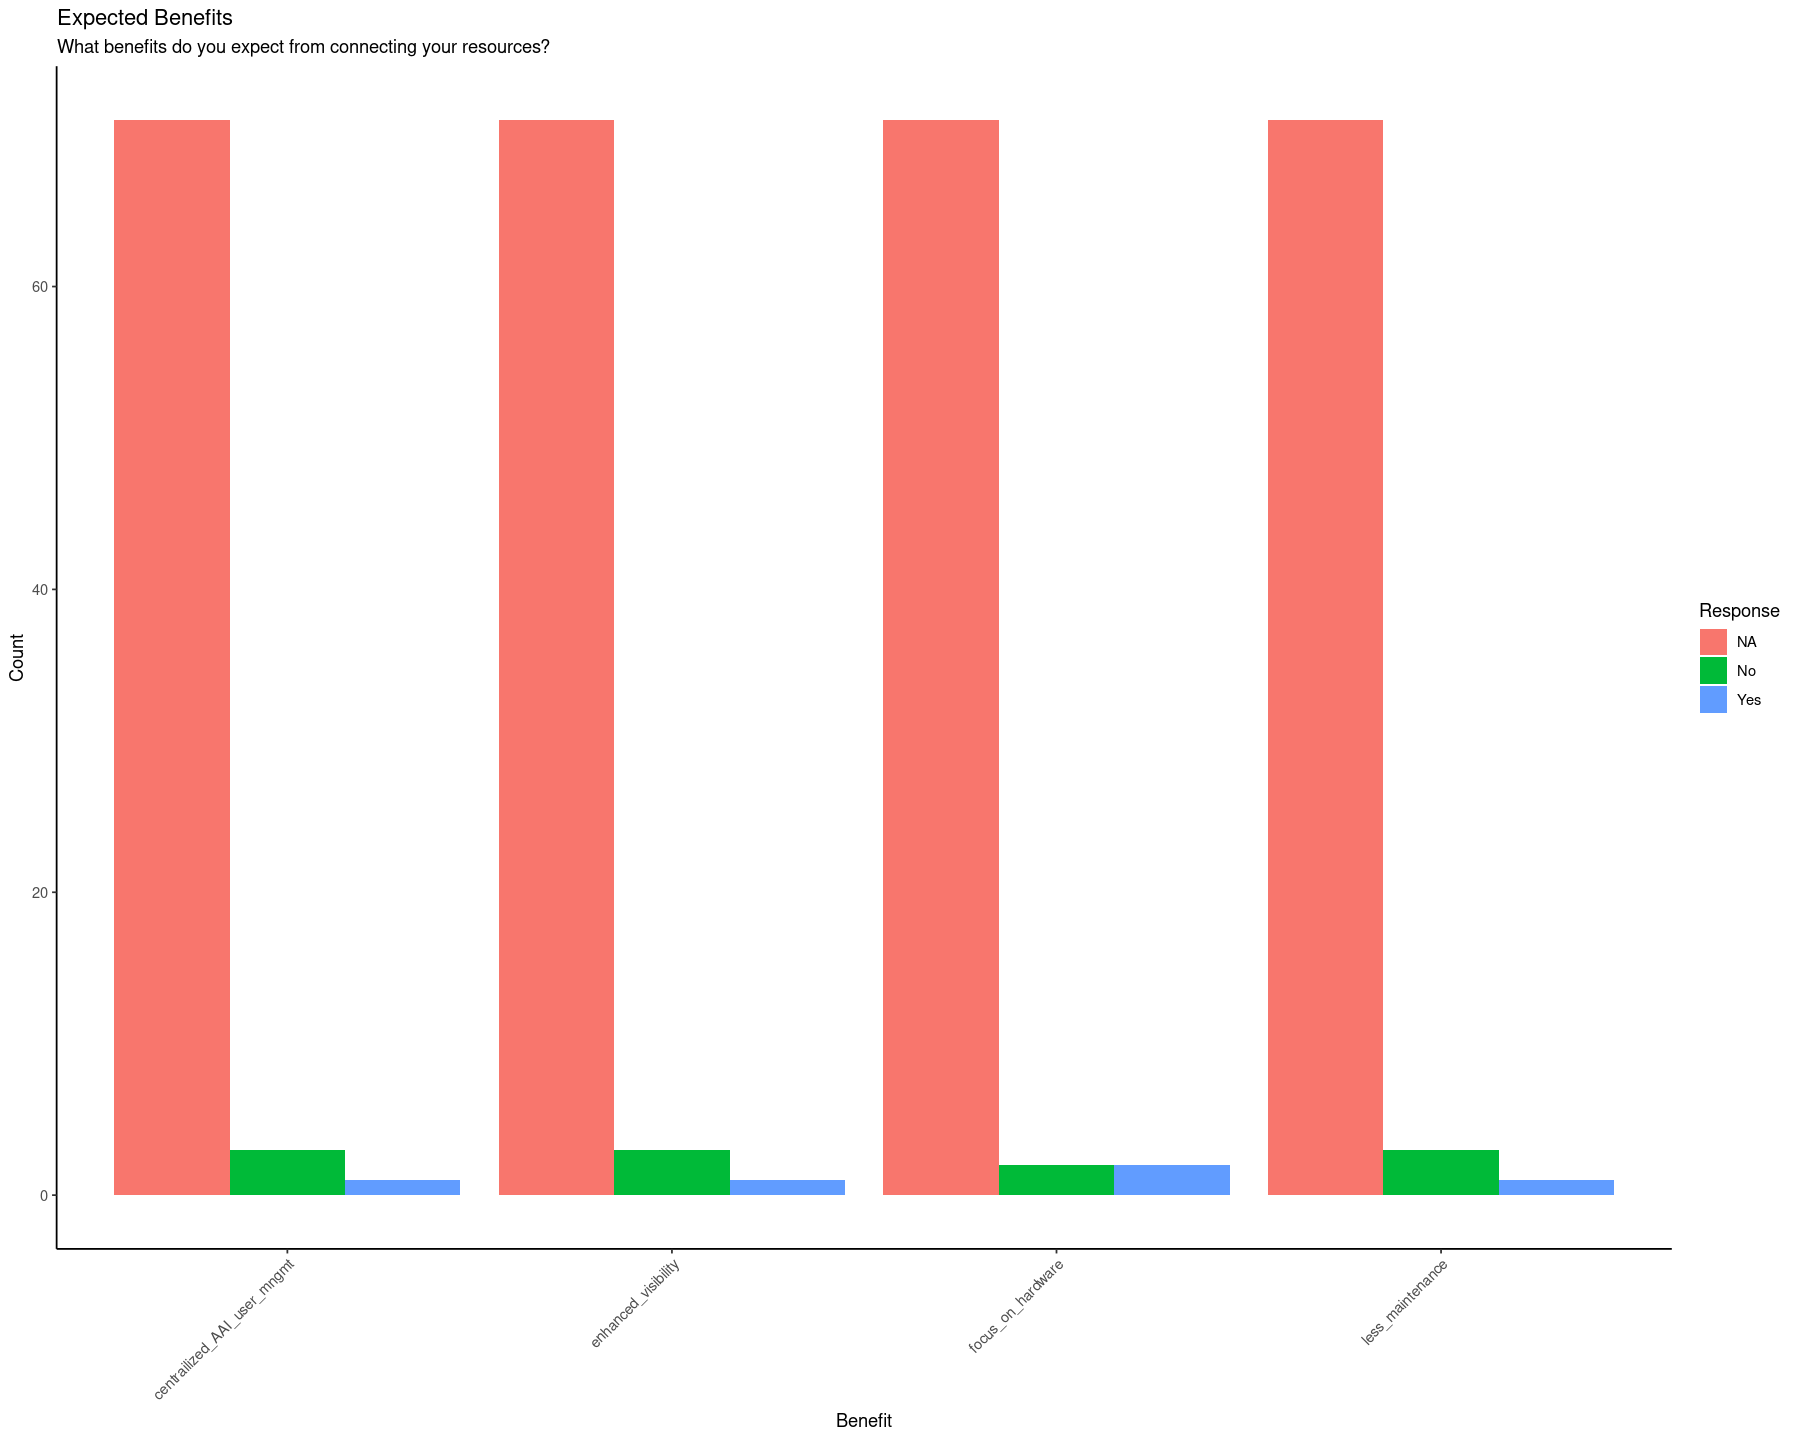

In [60]:
#| fig-align: center
# Create the dodged bar graph
ggplot(benefits_frame_long, aes(x = Benefit, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Expected Benefits",
    subtitle = question_info$question_text[20],
    x = "Benefit",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Knowing Jupyter

In [61]:
# knowing jupyter
#data$know_jupyter[!is.na(data$know_jupyter)]
#table(data$know_jupyter, useNA = "always")
#prop.table(table(data$know_jupyter, useNA = "always"))*100#

know_jup_frame <- data.frame(table(data$know_jupyter, useNA = "always"))
know_jup_frame


Var1,Freq
<fct>,<int>
Yes,9
NA,66


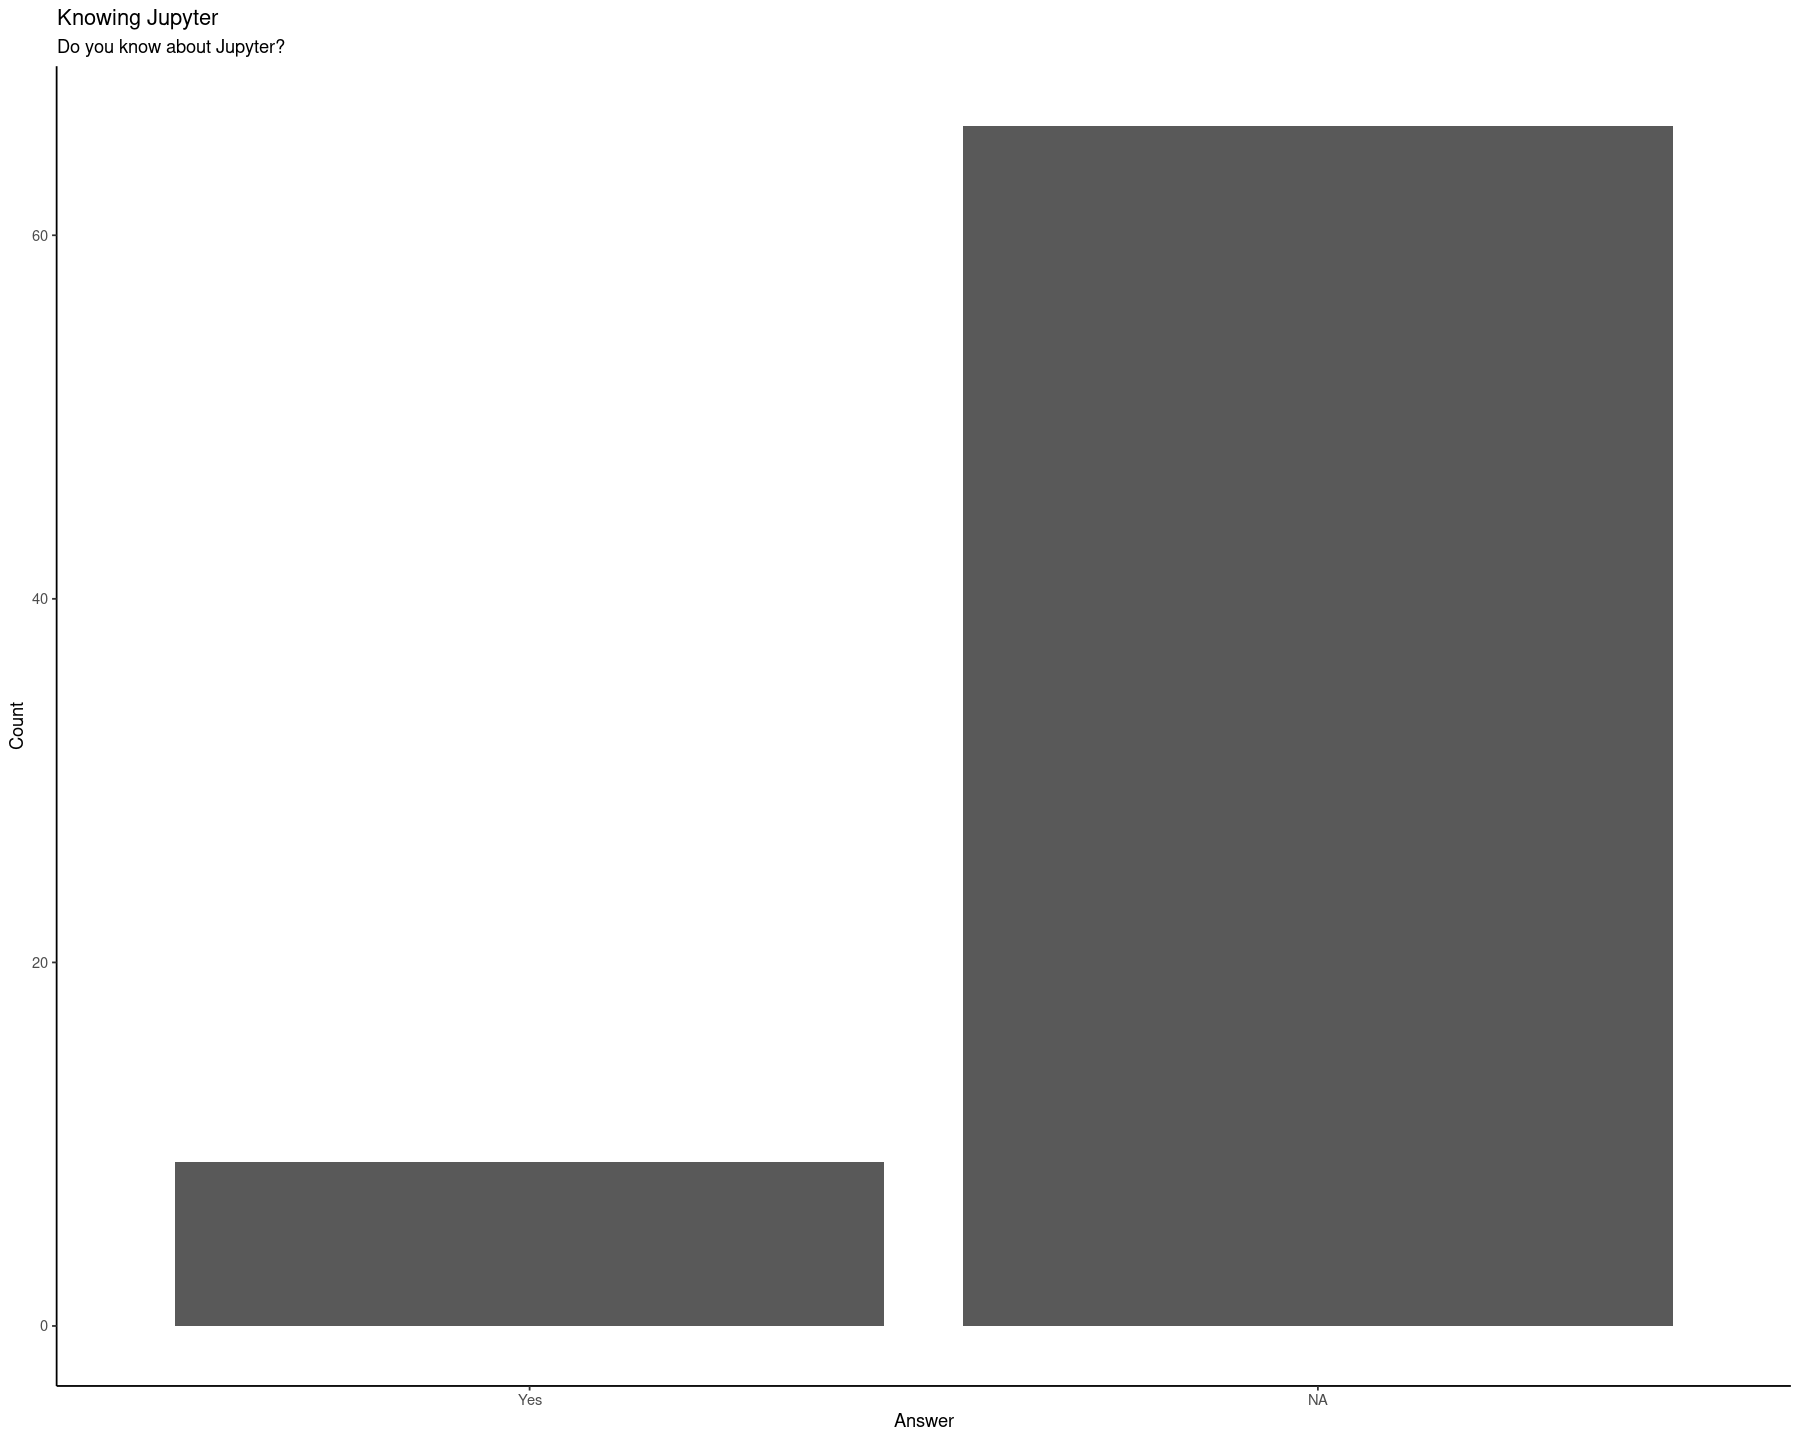

In [62]:
#| fig-align: center
# stacked bar chart
ggplot(data, aes(x = know_jupyter)) + 
  geom_bar() +
  labs(title = "Knowing Jupyter",
       subtitle = question_info$question_text[21],
       x = "Answer",
       y = "Count") +
  theme_classic()



# Group Size

In [63]:
# group size
data$group_size <- as.numeric(data$group_size)
#fivenum(data$group_size)
summary(data$group_size)


Warning message:
“NAs introduced by coercion”


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   6.00    8.50   30.00   44.71   30.00  200.00      68 

Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 68 rows containing non-finite outside the scale range
(`stat_summary()`).”


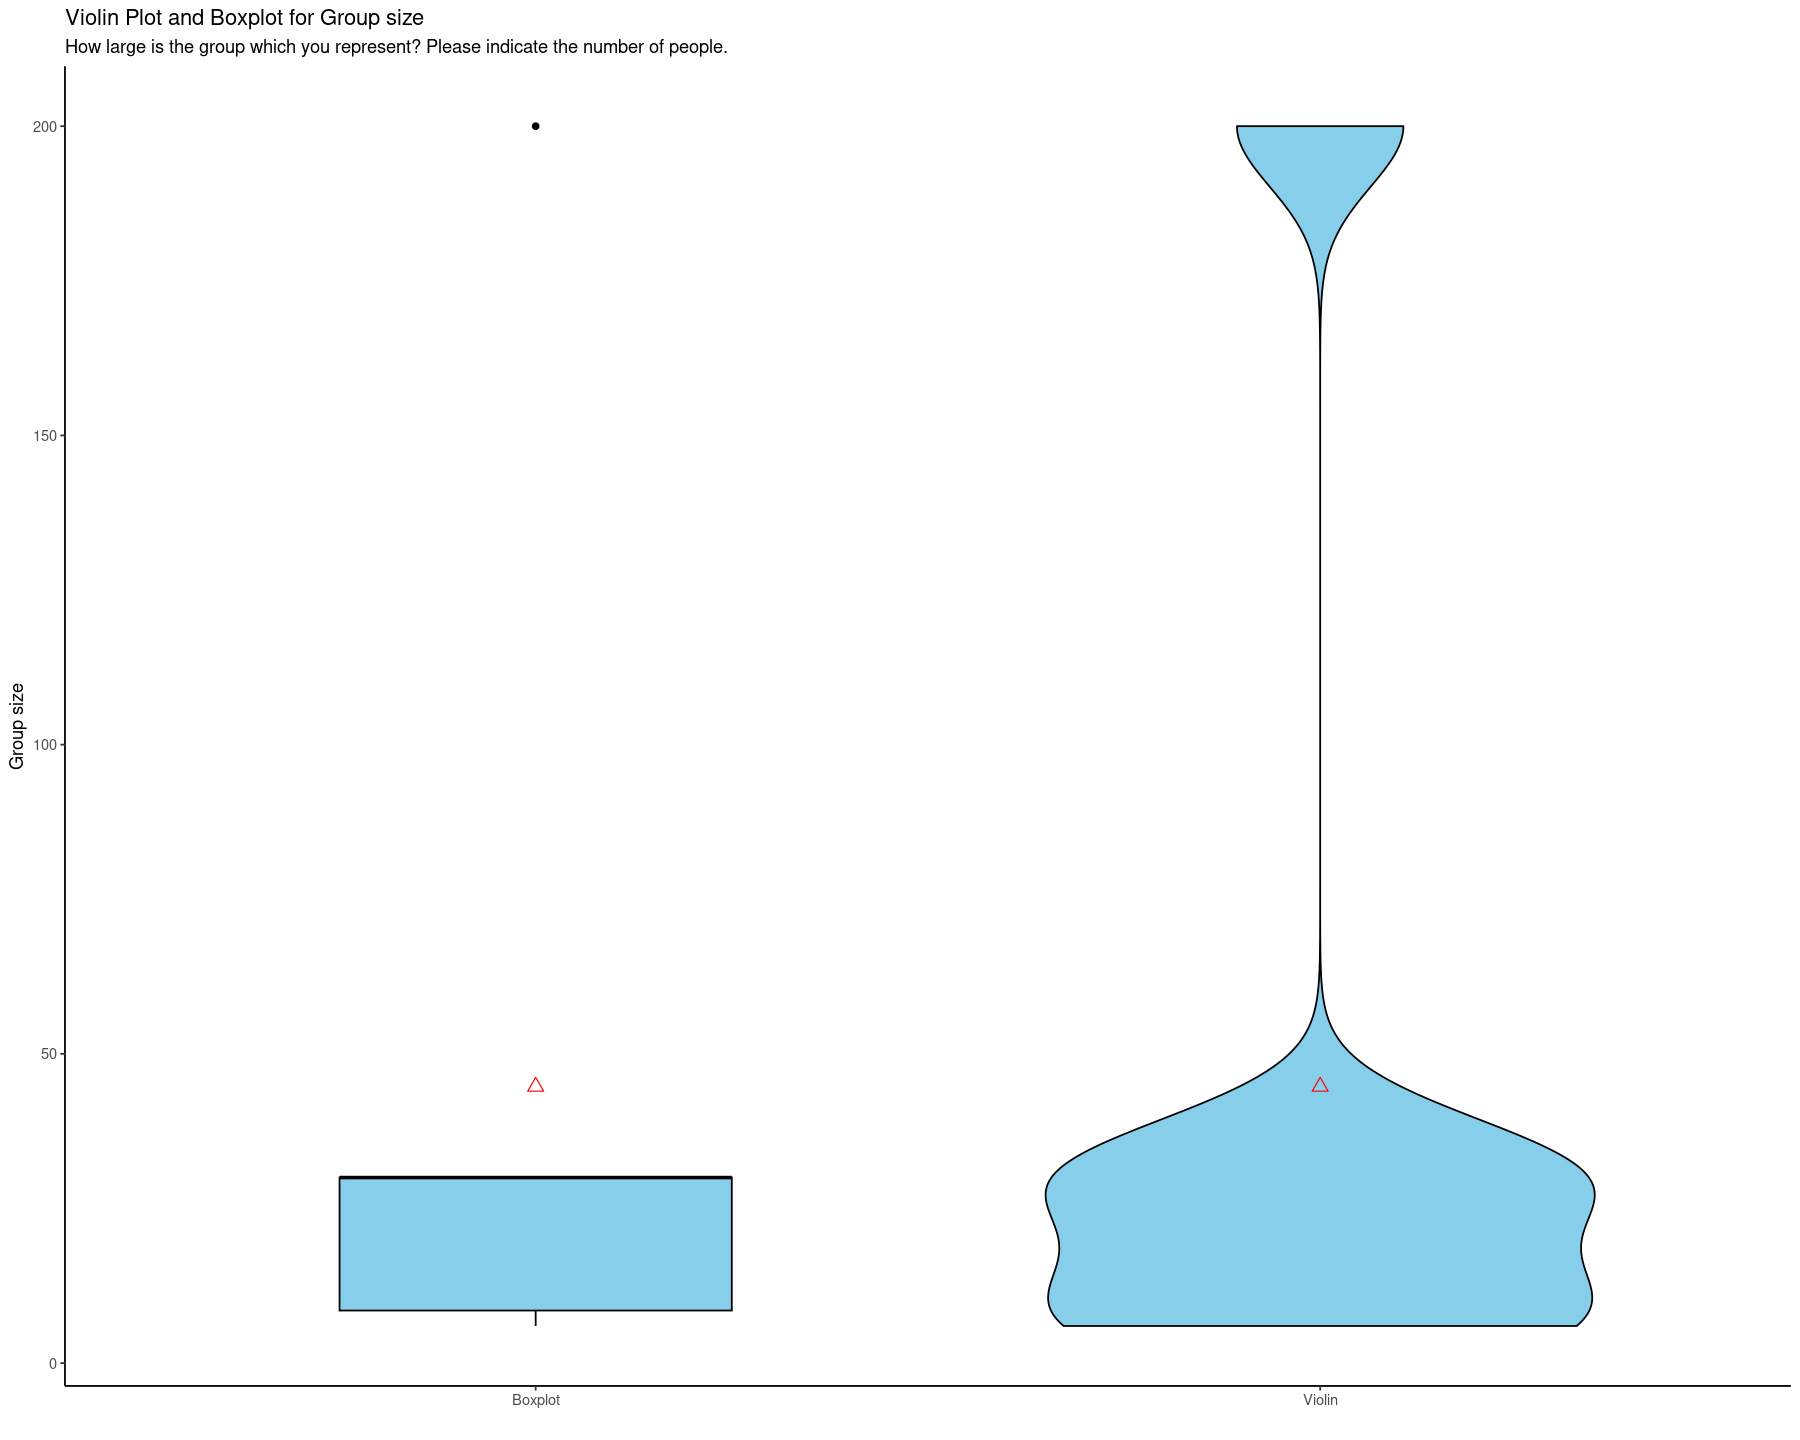

In [64]:
#| fig-align: center
# plot
ggplot(data, aes(x = "Violin", y = group_size)) +
  geom_violin(aes(x = "Violin"), fill = "skyblue", color = "black", width = 0.7) + # Violin
  geom_boxplot(aes(x = "Boxplot"), fill = "skyblue", color = "black", width = 0.5) + # Boxplot
  labs(
    title = "Violin Plot and Boxplot for Group size",
    subtitle = question_info$question_text[22],
    x = "",
    y = "Group size"
  ) +
  stat_summary(
    aes(x = "Violin"), fun = "mean", geom = "point", 
    shape = 2, size = 3, color = "red"
  ) +
  stat_summary(
    aes(x = "Boxplot"), fun = "mean", geom = "point", 
    shape = 2, size = 3, color = "red"
  ) +# Mean point for violin
  theme_classic()


# Dedicated Partners

In [65]:
# dedicated partners
#data$have_dedicated_partners
dedicated_partner_frame <- data.frame(table(data$have_dedicated_partners,useNA = "always"))
dedicated_partner_frame


Var1,Freq
<fct>,<int>
I don't know,1
No,4
Yes,4
NA,66


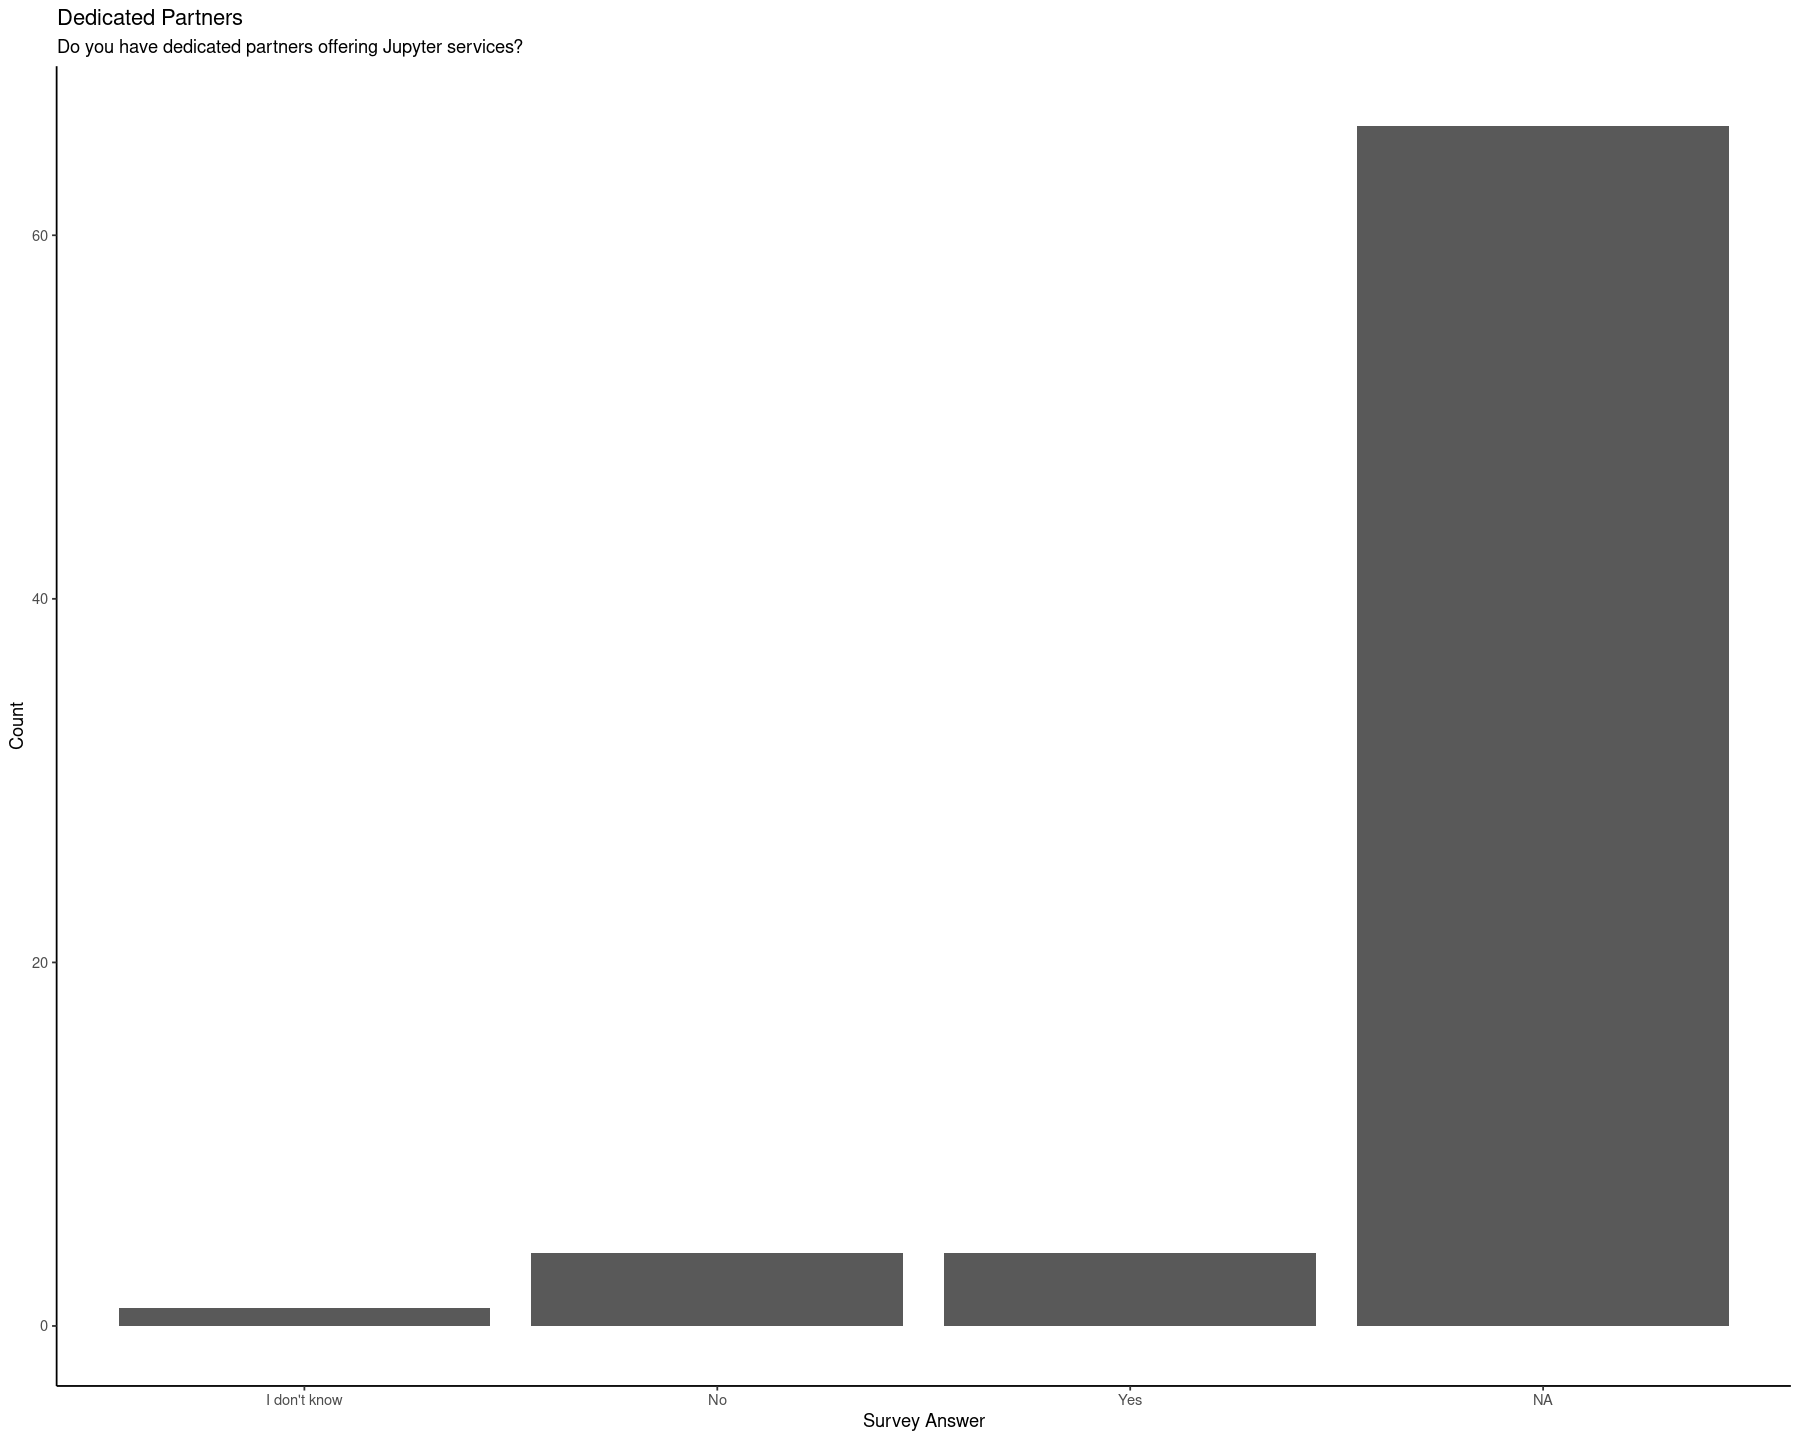

In [66]:
#| fig-align: center
# stacked bar chart
ggplot(data, aes(x = have_dedicated_partners)) + 
  geom_bar() +
  labs(title = "Dedicated Partners",
       subtitle = question_info$question_text[24],
       x = "Survey Answer",
       y = "Count") +
  theme_classic()



In [67]:
# who is partner
data$partner[!is.na(data$partner)]


[1] "Fraunhofer FOKUS / HLRS"                          
[2] "For Max-Jhub, DESY-IT colleagues are reponsible"  
[3] "Departement of Electrical Engineering at the RPTU"

# Jupyter Purpose

In [68]:
invisible(capture.output({
table(data$jupyter_purpose_coding_testing_tutorials,useNA = "always")
prop.table(table(data$jupyter_purpose_coding_testing_tutorials,useNA = "always"))*100

table(data$jupyter_purpose_heavy_computing_analysis,useNA = "always")
prop.table(table(data$jupyter_purpose_heavy_computing_analysis,useNA = "always"))*100

table(data$jupyter_purpose_whenever_possible,useNA = "always")
prop.table(table(data$jupyter_purpose_whenever_possible,useNA = "always"))*100

table(data$jupyter_purpose_workshops_training,useNA = "always")
prop.table(table(data$jupyter_purpose_workshops_training,useNA = "always"))*100

purpose_frame <- rbind.data.frame(table(data$jupyter_purpose_coding_testing_tutorials,useNA = "always"),
                                   table(data$jupyter_purpose_heavy_computing_analysis,useNA = "always"),
                                   table(data$jupyter_purpose_whenever_possible,useNA = "always"),
                                   table(data$jupyter_purpose_workshops_training,useNA = "always"))


purpose_frame <- cbind.data.frame(User = c("Testing and Tutorials","Heavy Computing and Analysis","Whenever possible","Workshops and Training"), purpose_frame)
colnames(purpose_frame) <- c("Purpose","Yes","No","NA")

purpose_frame_long <- tidyr::pivot_longer(
  purpose_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)

}))

In [69]:
purpose_frame_long

Purpose,Response,Count
<chr>,<chr>,<int>
Testing and Tutorials,Yes,6
Testing and Tutorials,No,32
Testing and Tutorials,NA,37
Heavy Computing and Analysis,Yes,18
Heavy Computing and Analysis,No,20
Heavy Computing and Analysis,NA,37
Whenever possible,Yes,28
Whenever possible,No,10
Whenever possible,NA,37


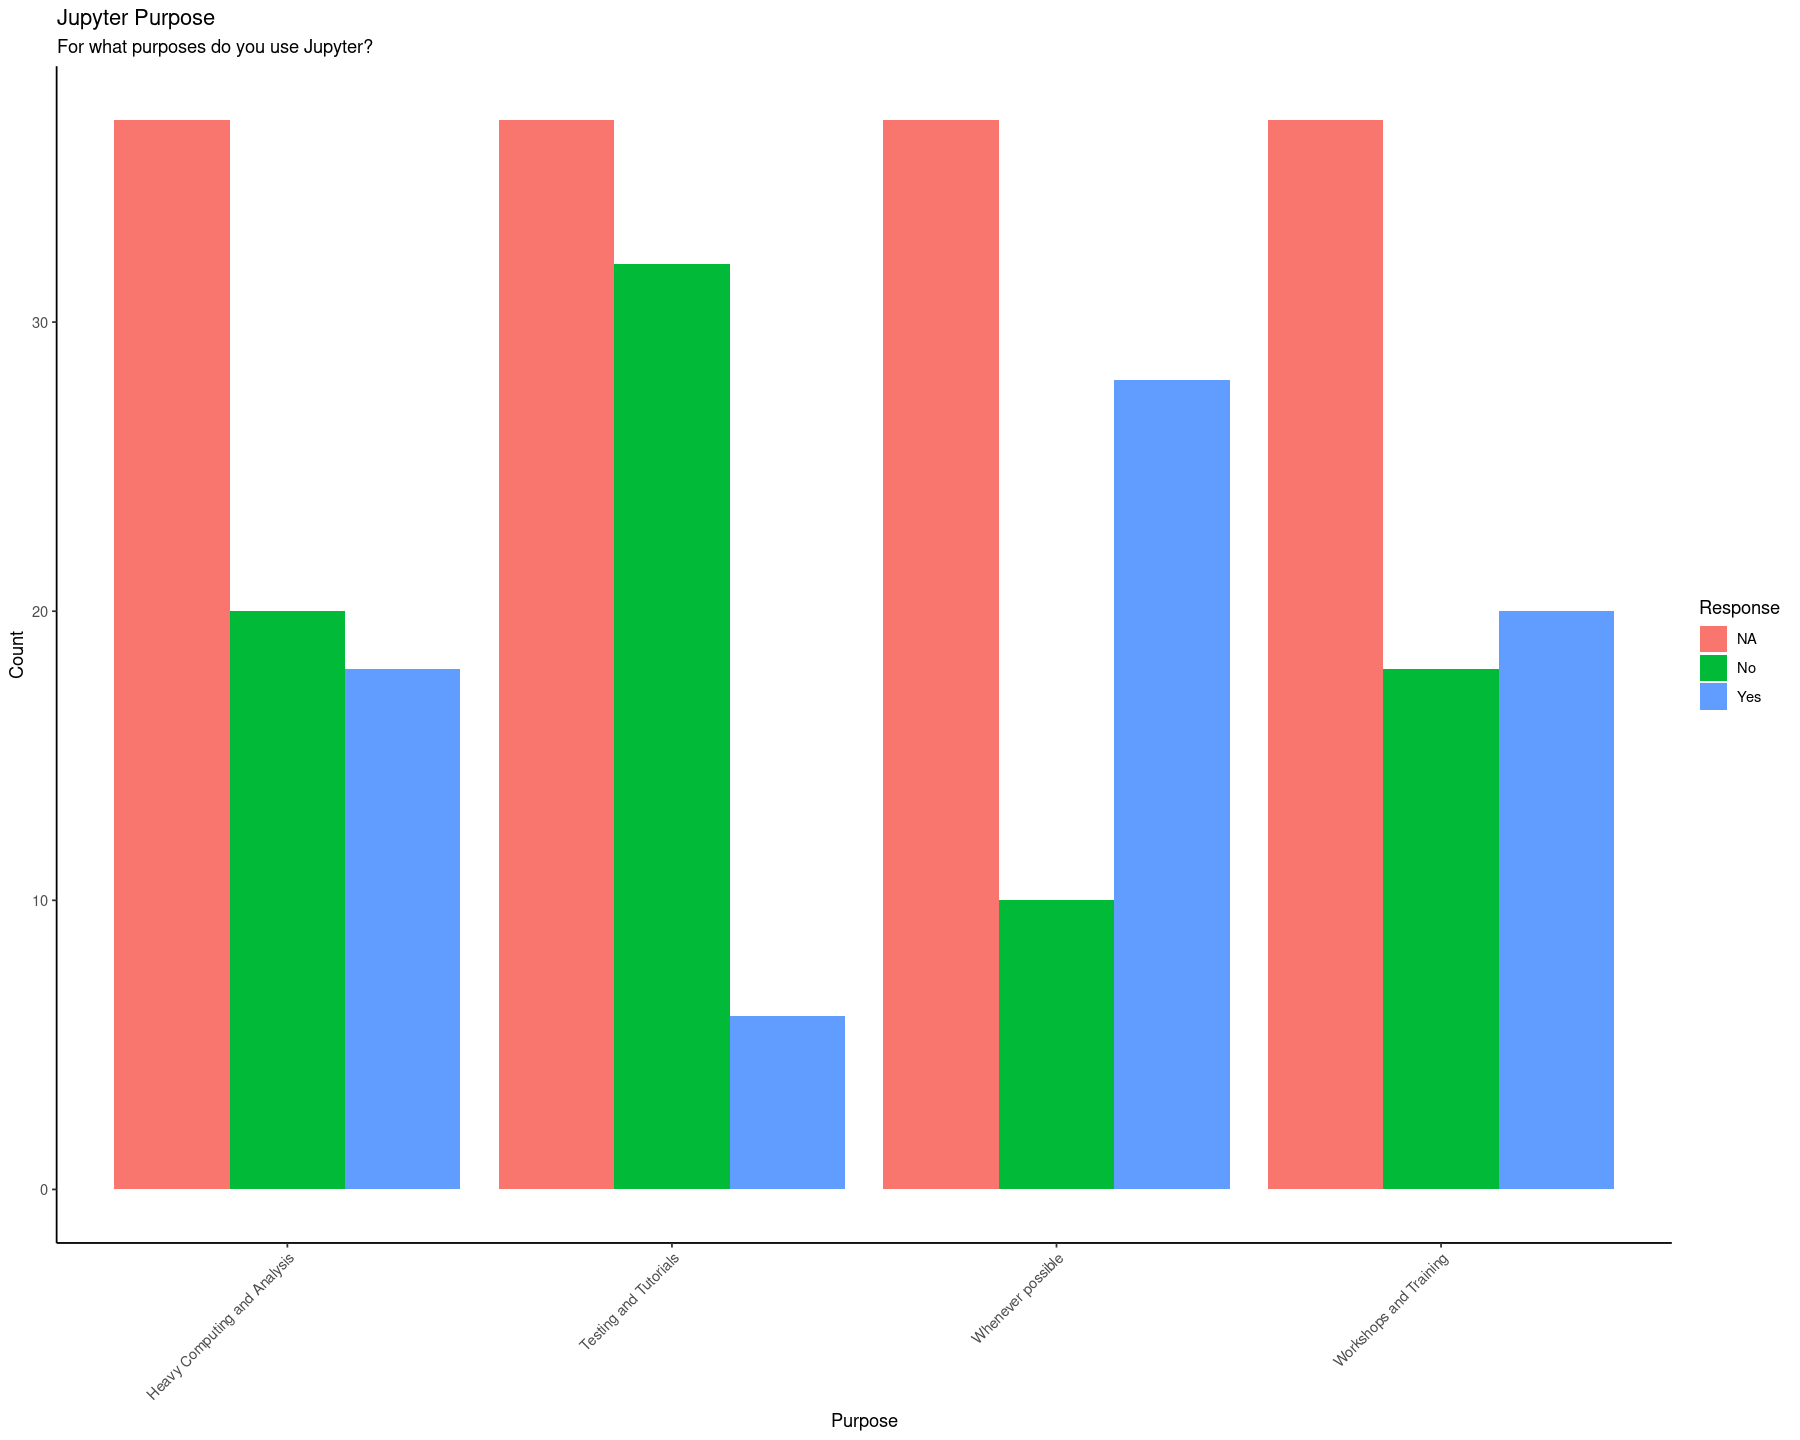

In [70]:
#| fig-align: center
# Create the dodged bar graph
ggplot(purpose_frame_long, aes(x = Purpose, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Jupyter Purpose",
    subtitles = question_info$question_text[26],
    x = "Purpose",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Other Purposes

In [71]:

data$jupyter_purpose_other[!is.na(data$jupyter_purpose_other)]


[1] "when providing our results to others (the actual software is then wrapped into conda packages)"
[2] "Didn't use it yet"

# Current Jupyter Use

In [72]:
invisible(capture.output({
# current jupyter use
table(data$current_jupyter_use_local,useNA = "always")
prop.table(table(data$current_jupyter_use_local,useNA = "always"))*100

table(data$current_jupyter_use_remote,useNA = "always")
prop.table(table(data$current_jupyter_use_remote,useNA = "always"))*100

table(data$current_jupyter_use_jupyterlite,useNA = "always")
prop.table(table(data$current_jupyter_use_jupyterlite,useNA = "always"))*100

table(data$current_jupyter_use_colab,useNA = "always")
prop.table(table(data$current_jupyter_use_colab,useNA = "always"))*100

current_use_frame <- rbind.data.frame(table(data$current_jupyter_use_local,useNA = "always"),
                                  table(data$current_jupyter_use_remote,useNA = "always"),
                                  table(data$current_jupyter_use_jupyterlite,useNA = "always"),
                                  table(data$current_jupyter_use_colab,useNA = "always"))


current_use_frame <- cbind.data.frame(User = c("Local","Remote","Jupyterlite","Colab"), current_use_frame)
colnames(current_use_frame) <- c("Current Use","Yes","No","NA")

current_use_frame_long <- tidyr::pivot_longer(
  current_use_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)

}))

In [73]:
current_use_frame_long

Current Use,Response,Count
<chr>,<chr>,<int>
Local,Yes,9
Local,No,29
Local,NA,37
Remote,Yes,20
Remote,No,18
Remote,NA,37
Jupyterlite,Yes,37
Jupyterlite,No,1
Jupyterlite,NA,37


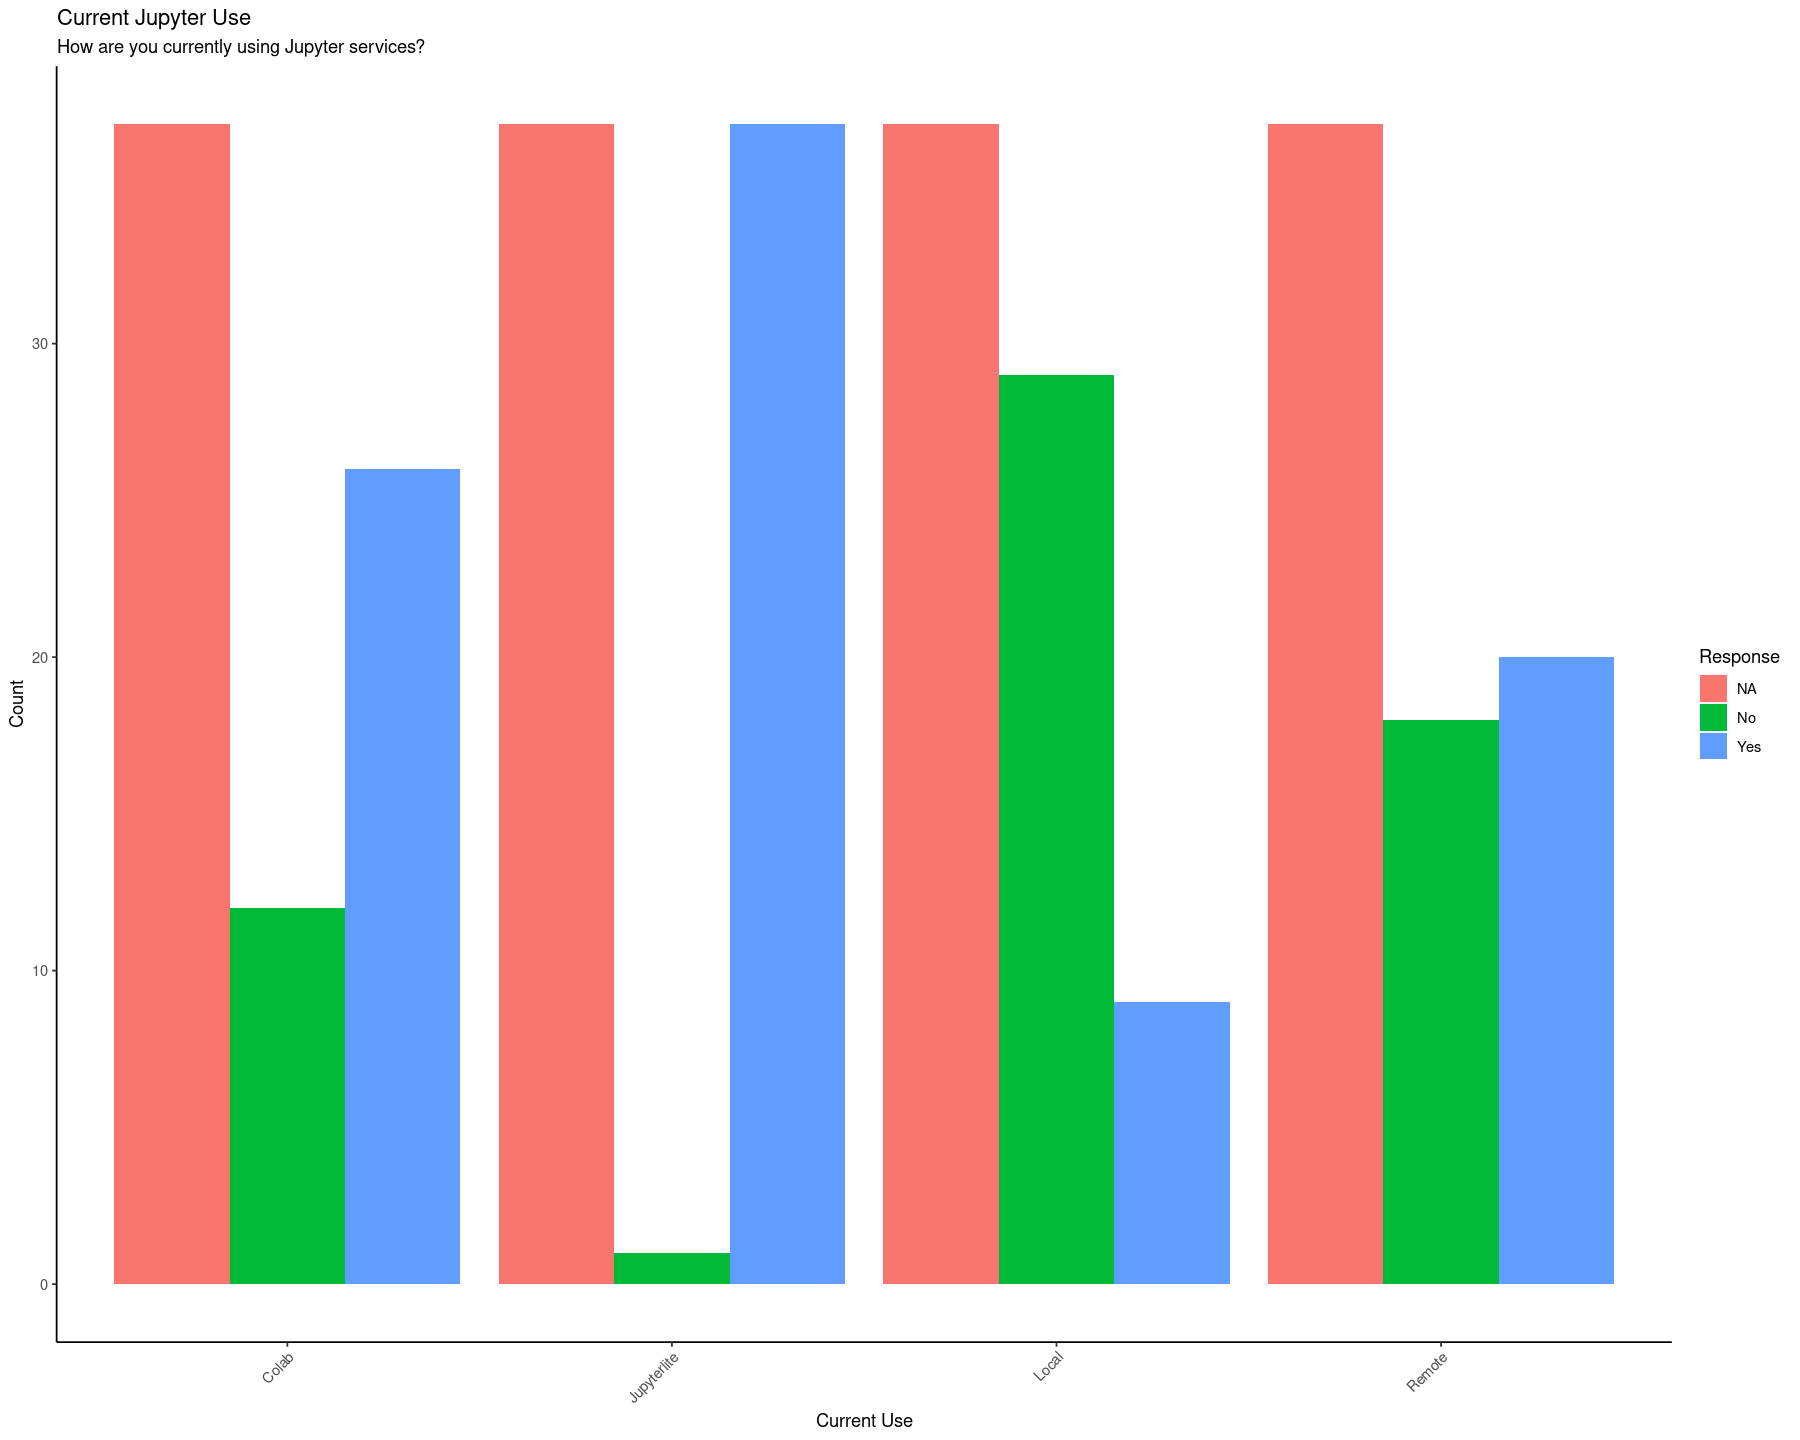

In [74]:
#| fig-align: center

# Create the dodged bar graph
ggplot(current_use_frame_long, aes(x = `Current Use`, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Current Jupyter Use",
    subtitle = question_info$question_text[27],
    x = "Current Use",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Other current use

In [75]:
data$current_jupyter_use_other[!is.na(data$current_jupyter_use_other)]


[1] "jupyterlab on remote virtual  machine s in a cloud"
[2] "Galaxy"                                            
[3] "cocalc"

# Jupyter Provider

In [76]:
# Jupyter Provider
data$jupyter_provider_who[!is.na(data$jupyter_provider_who)]


[1] "Bochum University of Applied Sciences"                         
 [2] "University Muenster, soon jupyterhub.nrw"                      
 [3] "Biender"                                                       
 [4] "Universität Stuttgart"                                         
 [5] "The Physik department at LMU"                                  
 [6] "Wikimedia Foundation"                                          
 [7] "RWTH Aachen University"                                        
 [8] "don't know"                                                    
 [9] "Computing Center of Technische Universität Darmstadt"          
[10] "DESY"                                                          
[11] "AIP, selfhosted"                                               
[12] "The research department where I am employed"                   
[13] "bwJupyterHub"                                                  
[14] "self hosted for research, Academic Cloud for teaching/students"
[15] "bwHPC, SCCKN, Self-Hosted"                                     
[16] "Univ Münster"

# Resource Requirements

In [77]:
invisible(capture.output({
# Resource Requirements
table(data$resource_requirements_concurrenct_session_average,useNA = "always")
prop.table(table(data$resource_requirements_concurrenct_session_average,useNA = "always"))*100

table(data$resource_requirements_concurrent_session_peak,useNA = "always")
prop.table(table(data$resource_requirements_concurrent_session_peak,useNA = "always"))*100

table(data$resource_requirements_user_number,useNA = "always")
prop.table(table(data$resource_requirements_user_number,useNA = "always"))*100

table(data$resource_requirements_gpus_per_session,useNA = "always")
prop.table(table(data$resource_requirements_gpus_per_session,useNA = "always"))*100

table(data$resource_requirements_cpus_per_session,useNA = "always")
prop.table(table(data$resource_requirements_cpus_per_session,useNA = "always"))*100

table(data$resource_requirements_ram_per_session,useNA = "always")
prop.table(table(data$resource_requirements_ram_per_session,useNA = "always"))*100

table(data$resource_requirements_persistent_storage_per_session,useNA = "always")
prop.table(table(data$resource_requirements_persistent_storage_per_session,useNA = "always"))*100

requirements_frame <- rbind.data.frame(table(data$resource_requirements_concurrenct_session_average,useNA = "always"),
                                      table(data$resource_requirements_concurrent_session_peak,useNA = "always"),
                                      table(data$resource_requirements_user_number,useNA = "always"),
                                      table(data$resource_requirements_gpus_per_session,useNA = "always"),
                                      table(data$resource_requirements_cpus_per_session,useNA = "always"),
                                      table(data$resource_requirements_ram_per_session,useNA = "always"),
                                      table(data$resource_requirements_persistent_storage_per_session,useNA = "always"))


requirements_frame <- cbind.data.frame(User = c("Concurrent Session Average","Concurrent Session Peak","User Number","GPUs per Session","CPUS per Session","RAM per Session","Persistent Storage per Session"), requirements_frame)
colnames(requirements_frame) <- c("Requirement","Yes","No","NA")

requirements_frame_long <- tidyr::pivot_longer(
  requirements_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)


}))

In [78]:
requirements_frame_long

Requirement,Response,Count
<chr>,<chr>,<int>
Concurrent Session Average,Yes,23
Concurrent Session Average,No,15
Concurrent Session Average,NA,37
Concurrent Session Peak,Yes,24
Concurrent Session Peak,No,14
Concurrent Session Peak,NA,37
User Number,Yes,25
User Number,No,13
User Number,NA,37


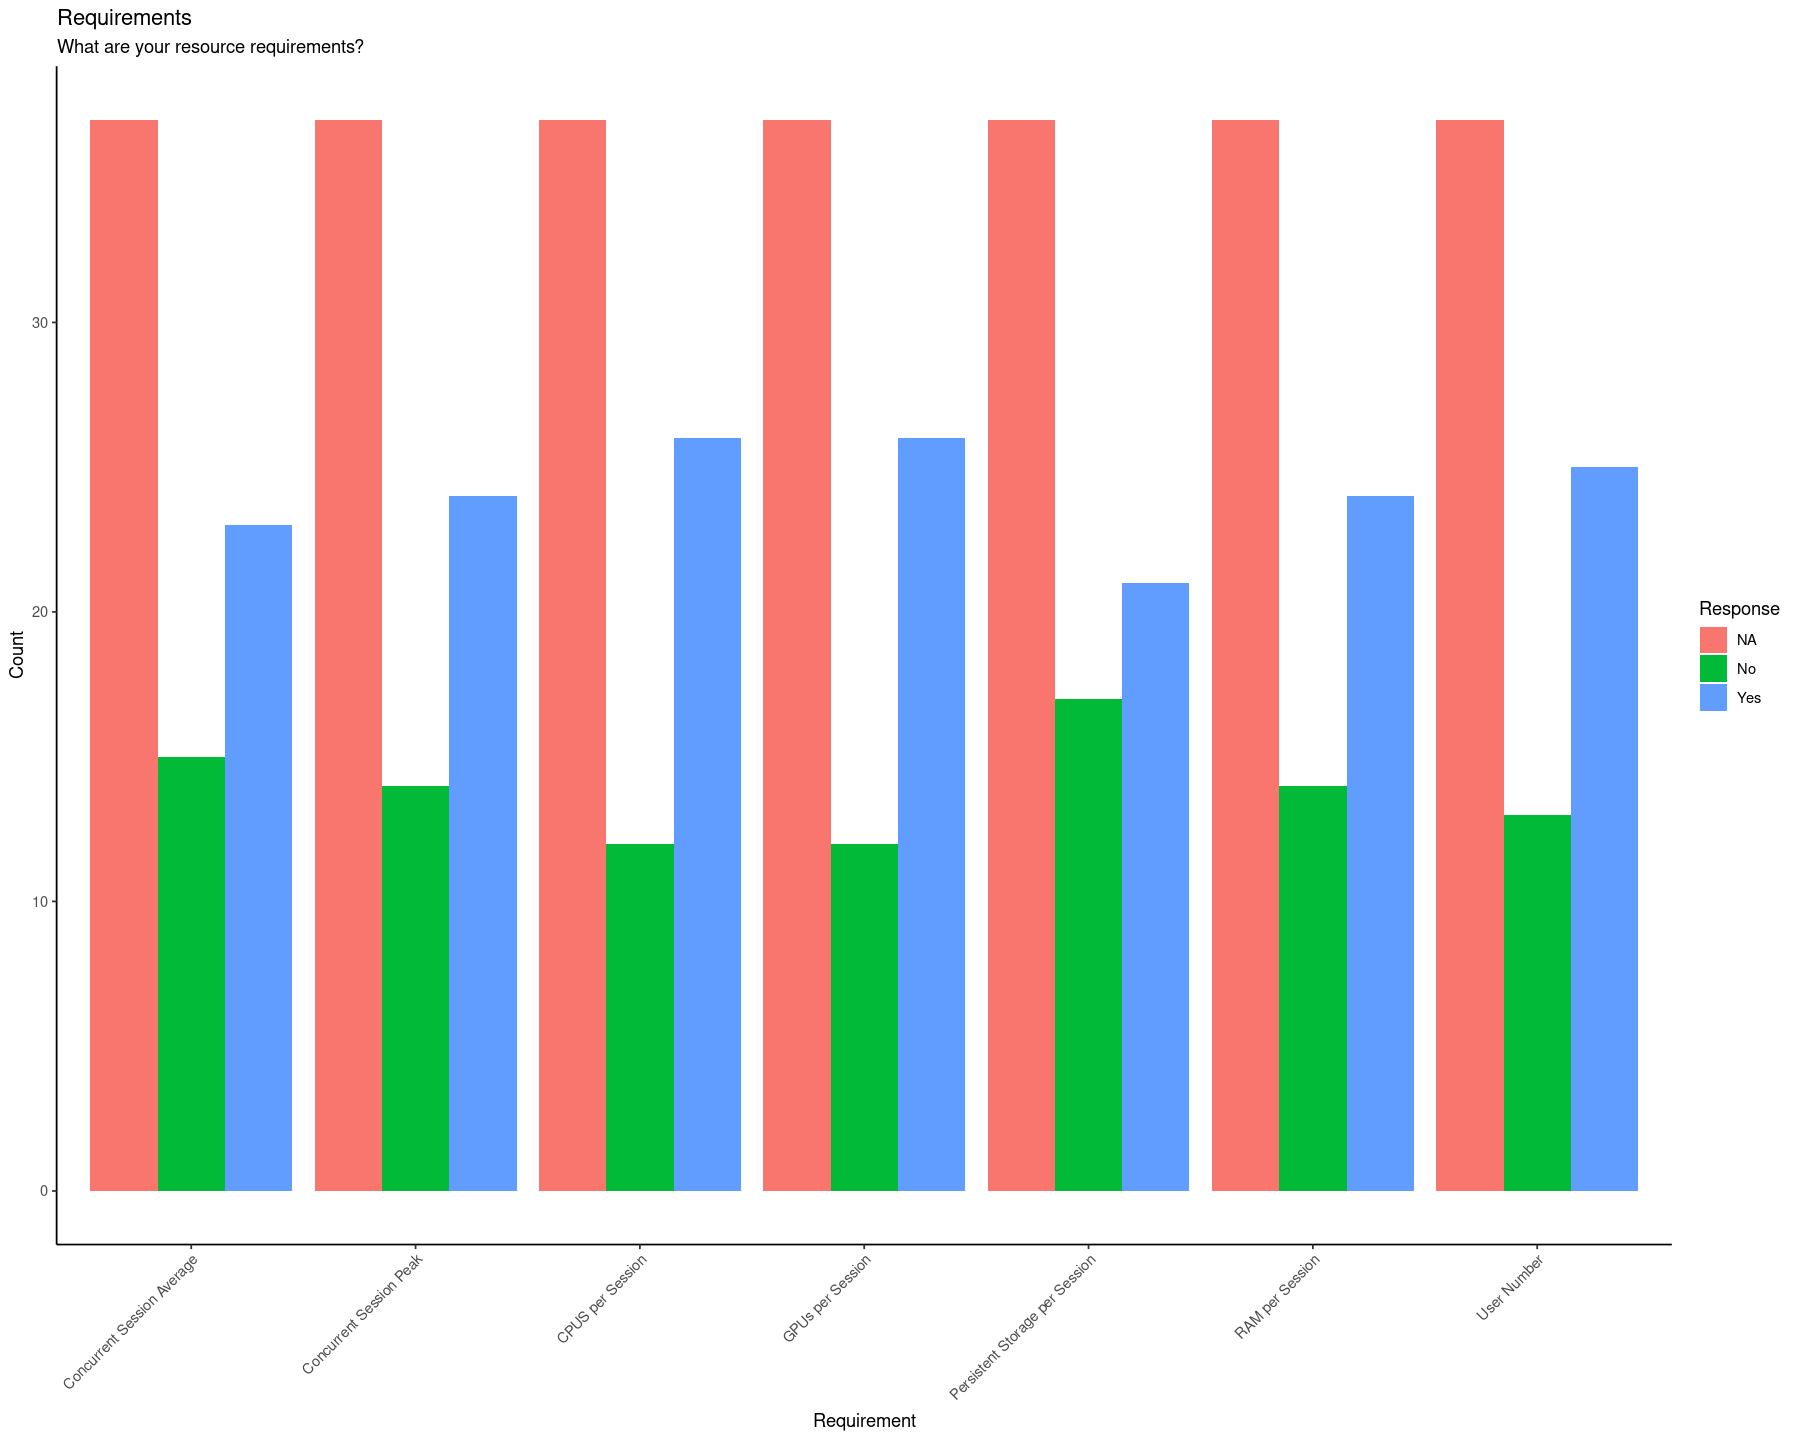

In [79]:
#| fig-align: center

# Create the dodged bar graph
ggplot(requirements_frame_long, aes(x = Requirement, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Requirements",
    subtitle = question_info$question_text[29],
    x = "Requirement",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


## Requirement Comments

In [80]:
invisible(capture.output({
resource_requirements_concurrenct_session_average_comment <- as.numeric(data$resource_requirements_concurrenct_session_average_comment)
resource_requirements_concurrent_session_peak_comment <- as.numeric(data$resource_requirements_concurrent_session_peak_comment)
resource_requirements_user_number_comment <- as.numeric(data$resource_requirements_user_number_comment)
resource_requirements_gpus_per_session_comment <- as.numeric(data$resource_requirements_gpus_per_session_comment)
resource_requirements_cpus_per_session_comment <- as.numeric(data$resource_requirements_cpus_per_session_comment)
resource_requirements_ram_per_session_comment <- as.numeric(data$resource_requirements_ram_per_session_comment)
resource_requirements_persistent_storage_per_session_comment <- as.numeric(data$resource_requirements_persistent_storage_per_session_comment)

resource_frame <- cbind.data.frame(resource_requirements_concurrenct_session_average_comment,
                                   resource_requirements_concurrent_session_peak_comment,
                                   resource_requirements_user_number_comment,
                                   resource_requirements_gpus_per_session_comment,
                                   resource_requirements_cpus_per_session_comment,
                                   resource_requirements_ram_per_session_comment,
                                   resource_requirements_persistent_storage_per_session_comment
                                   )


}))

Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”
Warning message in withVisible(...elt(i)):
“NAs introduced by coercion”


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 63 rows containing non-finite outside the scale range (`stat_bin()`).”


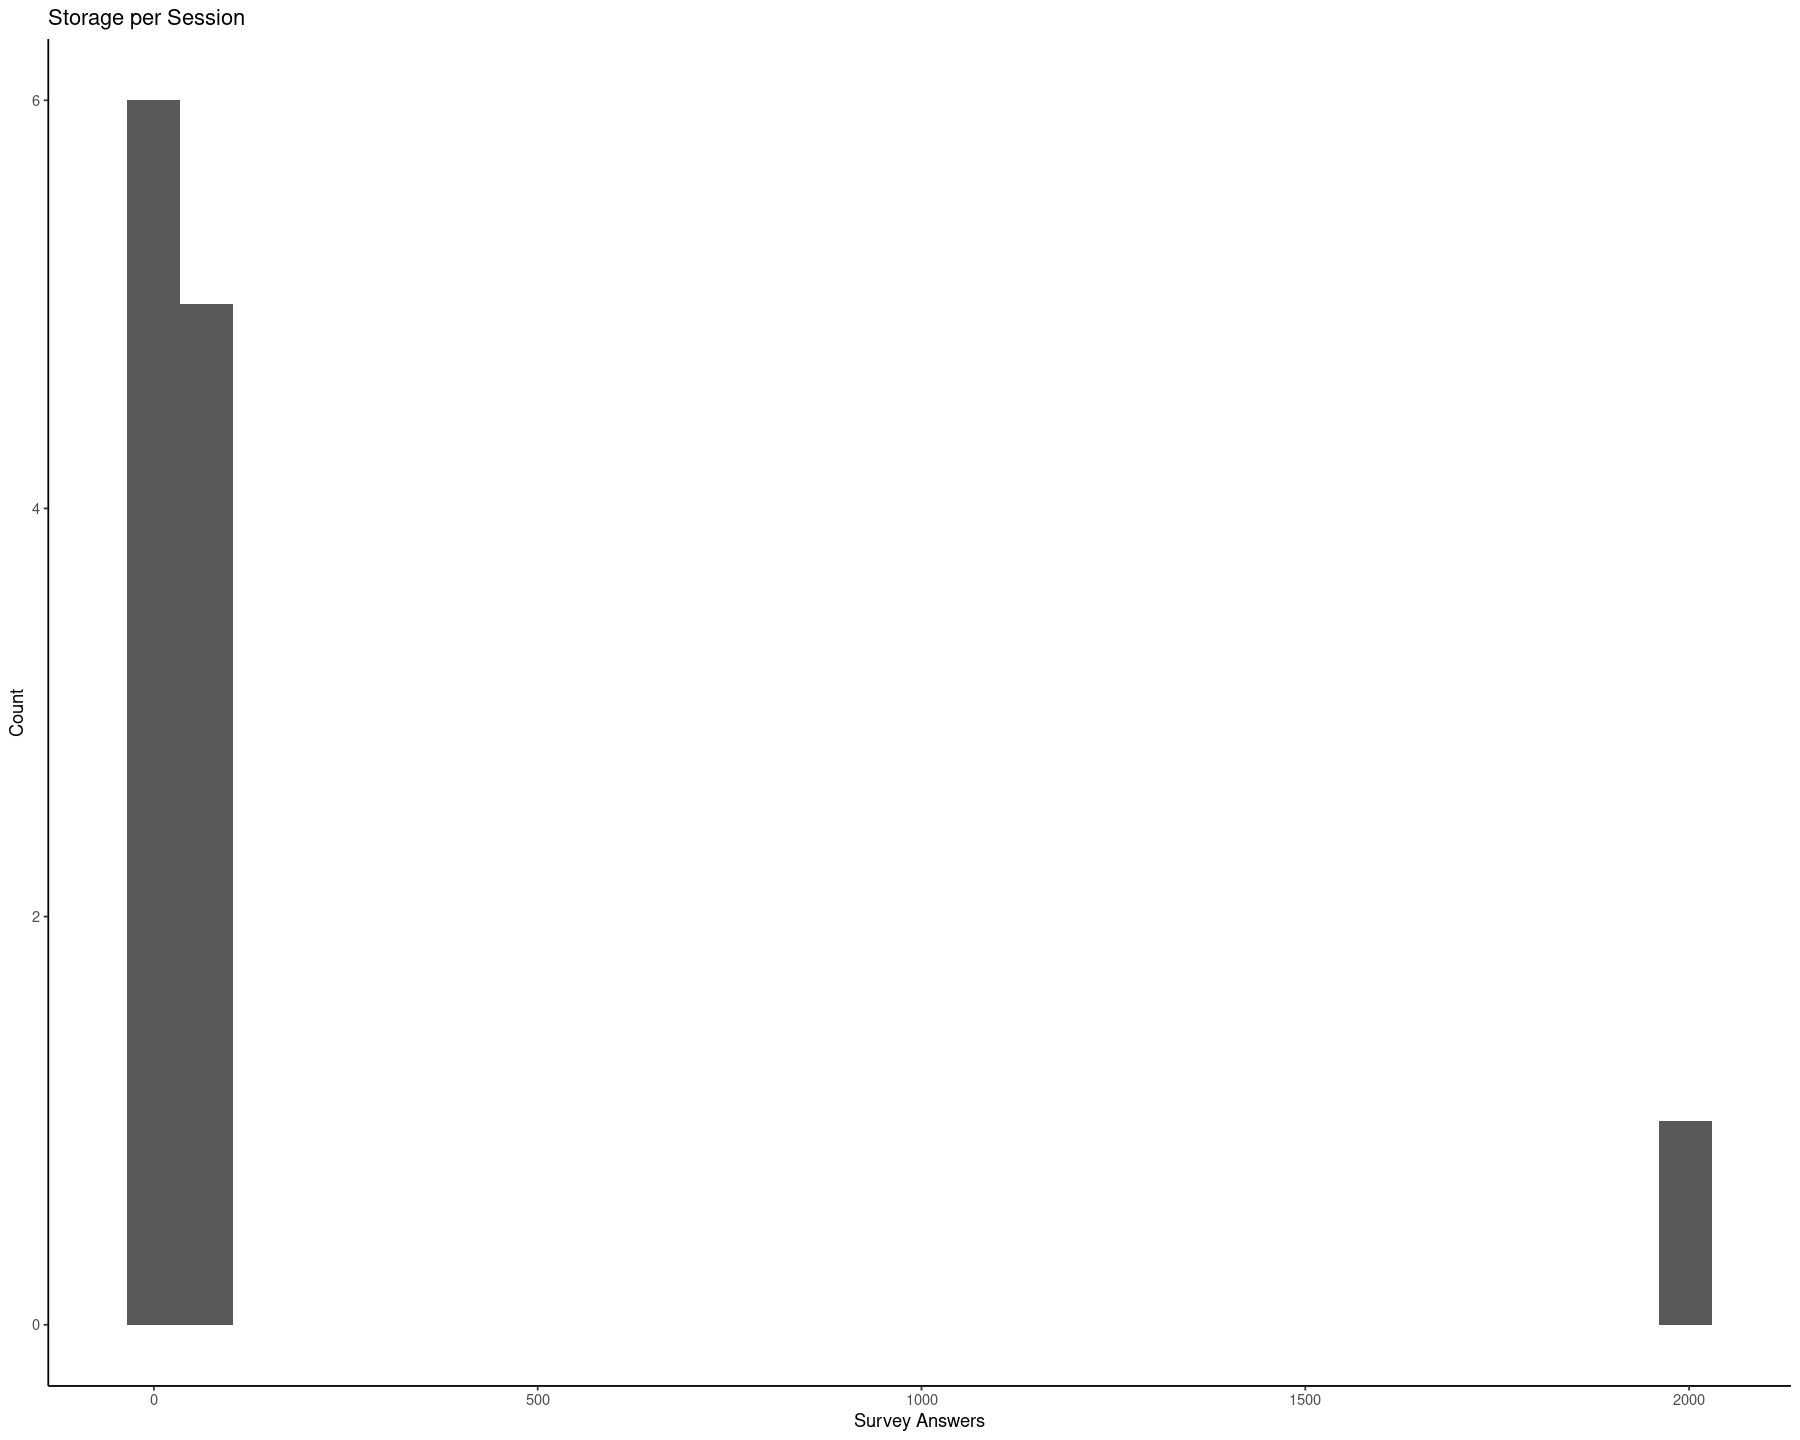

In [81]:
#| fig-align: center

invisible(capture.output({
# geom_boxplot
summary(resource_frame$resource_requirements_concurrenct_session_average_comment)
ggplot(resource_frame, aes(x = resource_requirements_concurrenct_session_average_comment)) + 
  geom_histogram() +
  labs(title = "Average concurrent Sessions",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_concurrent_session_peak_comment)
ggplot(resource_frame, aes(x = resource_requirements_concurrent_session_peak_comment)) + 
  geom_histogram() +
  labs(title = "Peak concurrent Sessions",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_user_number_comment)
ggplot(resource_frame, aes(x = resource_requirements_user_number_comment)) + 
  geom_histogram() +
  labs(title = "User numbers",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_gpus_per_session_comment)
ggplot(resource_frame, aes(x = resource_requirements_gpus_per_session_comment)) + 
  geom_histogram() +
  labs(title = "GPUS per Session",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# sgeom_boxplot
summary(resource_frame$resource_requirements_cpus_per_session_comment)
ggplot(resource_frame, aes(x = resource_requirements_cpus_per_session_comment)) + 
  geom_histogram() +
  labs(title = "CPUs per Session",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_ram_per_session_comment)
ggplot(resource_frame, aes(x = resource_requirements_ram_per_session_comment)) + 
  geom_histogram() +
  labs(title = "Dedicated Partners",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()

# geom_boxplot
summary(resource_frame$resource_requirements_persistent_storage_per_session_comment)
ggplot(resource_frame, aes(x = resource_requirements_persistent_storage_per_session_comment)) + 
  geom_histogram() +
  labs(title = "Storage per Session",
       x = "Survey Answers",
       y = "Count") +
  theme_classic()



}))

# Environment Requirements

In [82]:
invisible(capture.output({
table(data$env_requirements_lab_extension,useNA = "always")
prop.table(table(data$env_requirements_lab_extension,useNA = "always"))*100

table(data$env_requirements_software,useNA = "always")
prop.table(table(data$env_requirements_software,useNA = "always"))*100

table(data$env_requirements_licenses,useNA = "always")
prop.table(table(data$env_requirements_licenses,useNA = "always"))*100

table(data$env_requirements_custom_images,useNA = "always")
prop.table(table(data$env_requirements_custom_images,useNA = "always"))*100

env_requirements_frame <- rbind.data.frame(table(data$env_requirements_lab_extension,useNA = "always"),
                                       table(data$env_requirements_software,useNA = "always"),
                                       table(data$env_requirements_licenses,useNA = "always"),
                                       table(data$env_requirements_custom_images,useNA = "always"))


env_requirements_frame <- cbind.data.frame(User = c("Lab Extension","Software","Licenses","Custom Images"), env_requirements_frame)
colnames(env_requirements_frame) <- c("Env Requirement","Yes","No","NA")

env_requirements_frame_long <- tidyr::pivot_longer(
  env_requirements_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)



}))

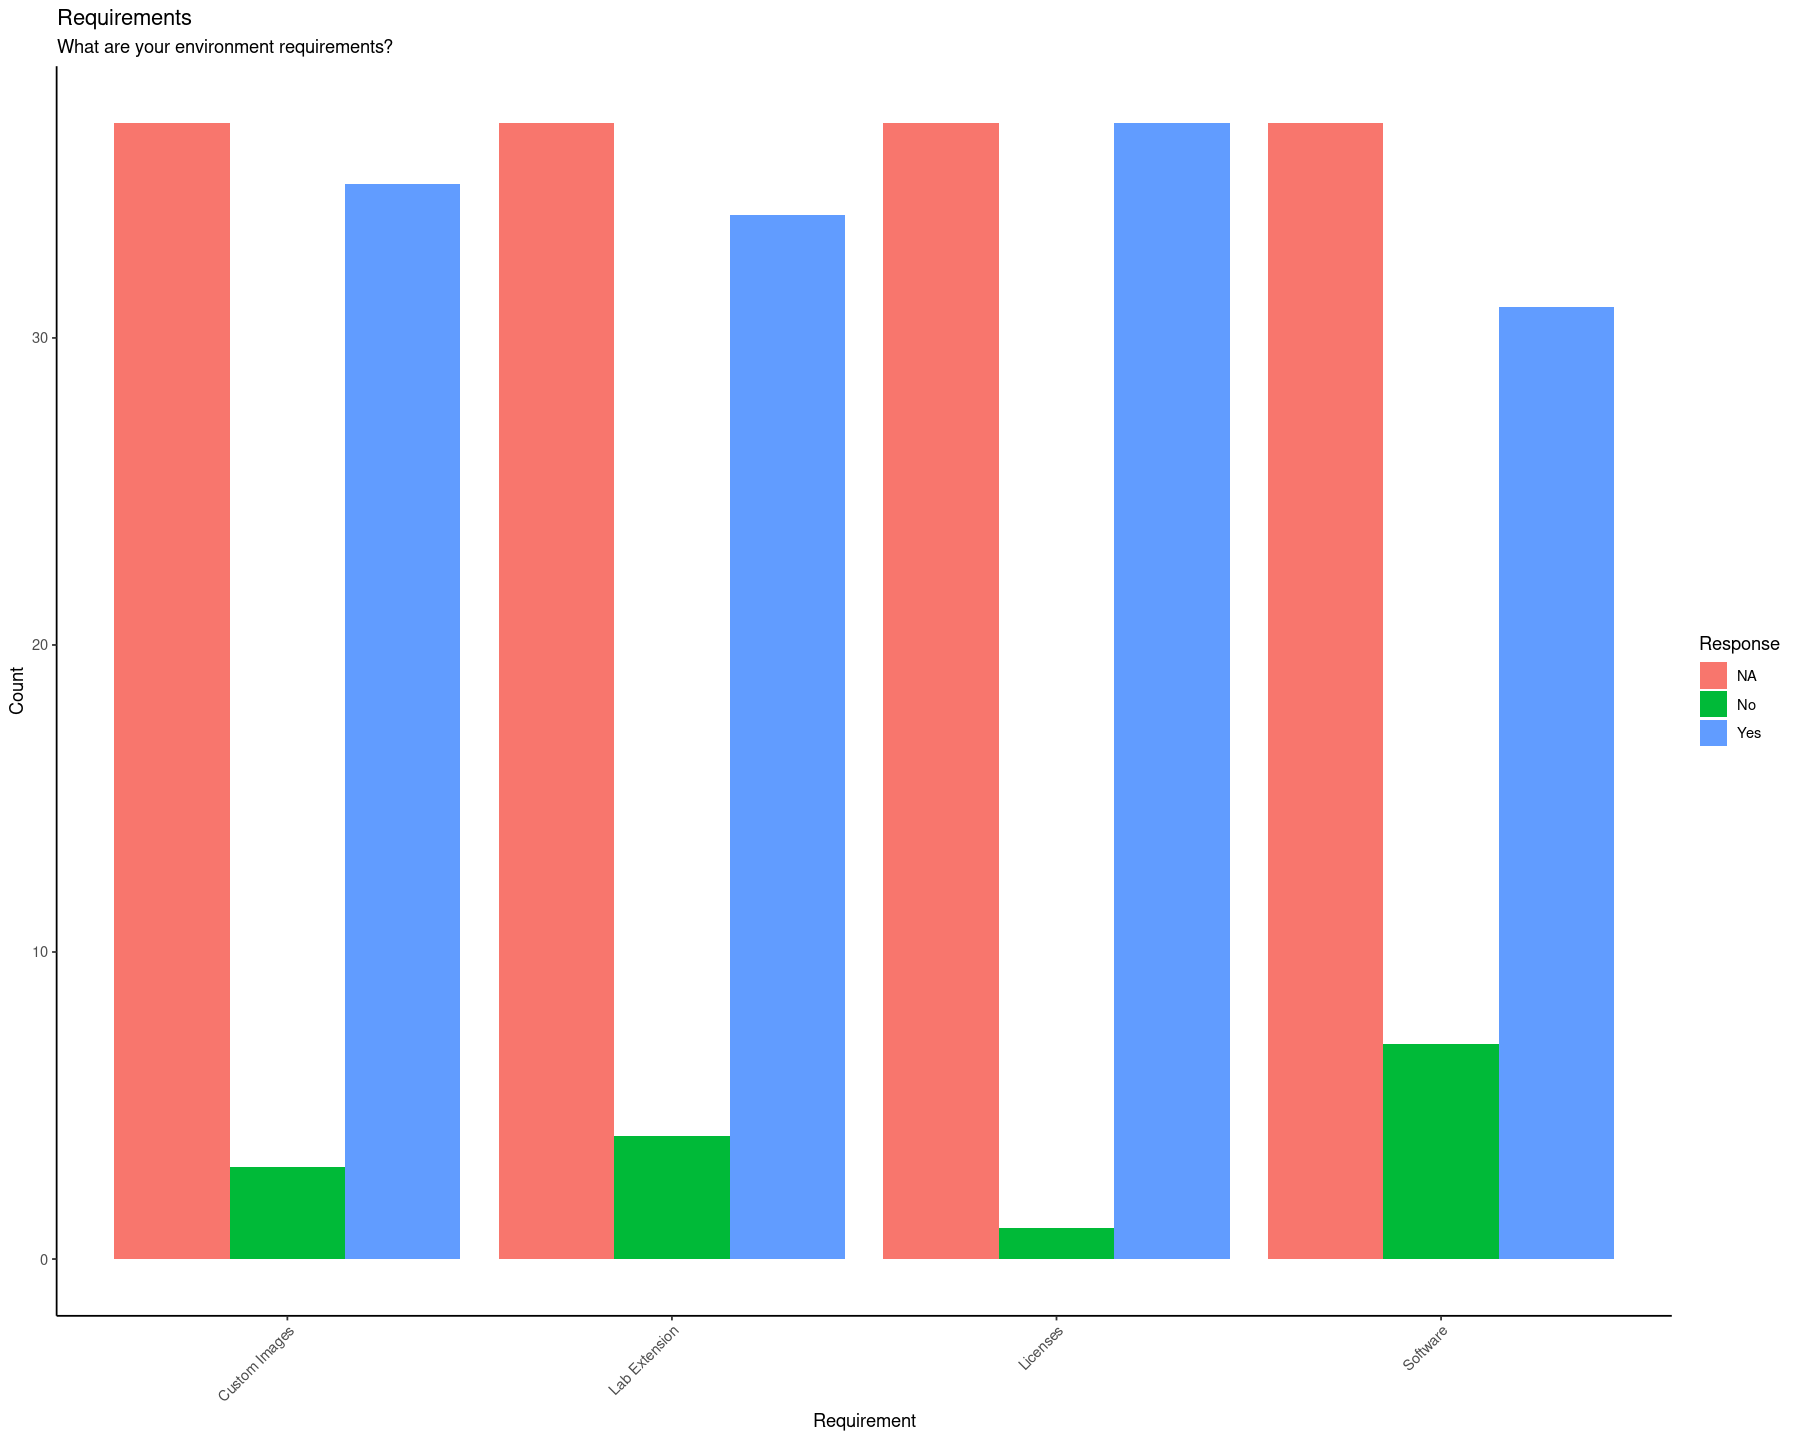

In [83]:
#| fig-align: center
#| 
# Create the dodged bar graph
ggplot(env_requirements_frame_long, aes(x = `Env Requirement`, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Requirements",
    subtitle = question_info$question_text[30],
    x = "Requirement",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [84]:
# env reqs comments
data$env_requirements_lab_extension_comment[!is.na(data$env_requirements_lab_extension_comment)]
data$env_requirements_software_comment[!is.na(data$env_requirements_software_comment)]
data$env_requirements_licenses_comment[!is.na(data$env_requirements_licenses_comment)]
data$env_requirements_custom_images_comment[!is.na(data$env_requirements_custom_images_comment)]


[1] "3"                                                                    
[2] "unsure"                                                               
[3] "interconnection with learning management software (Moodle); nb-grader"
[4] "dask, panel"

[1] "conda with the option to provide own environments"  
[2] "Python (with various python tools getting imported)"
[3] "cuda/gpu/opengl"                                    
[4] "PyPSA, pandapower"                                  
[5] "All kinds of python packes, also self written ones" 
[6] "Pandas, Matplotlib, Scikit-Learn, Tensorflow"

[1] "OSI-approved"

[1] "Python, TensorFlow, PyTorch, CellProfiler, Cellpose, OMERO, Fiji, napari, StarDist, QuPath"
[2] "hosted at gitlab-p4n.aip.de"

# External Data Access

In [85]:
# External data access
data.frame(table(data$external_data_access,useNA = "always"))


Var1,Freq
<fct>,<int>
I dont know yet,8
No,3
Yes,27
NA,37


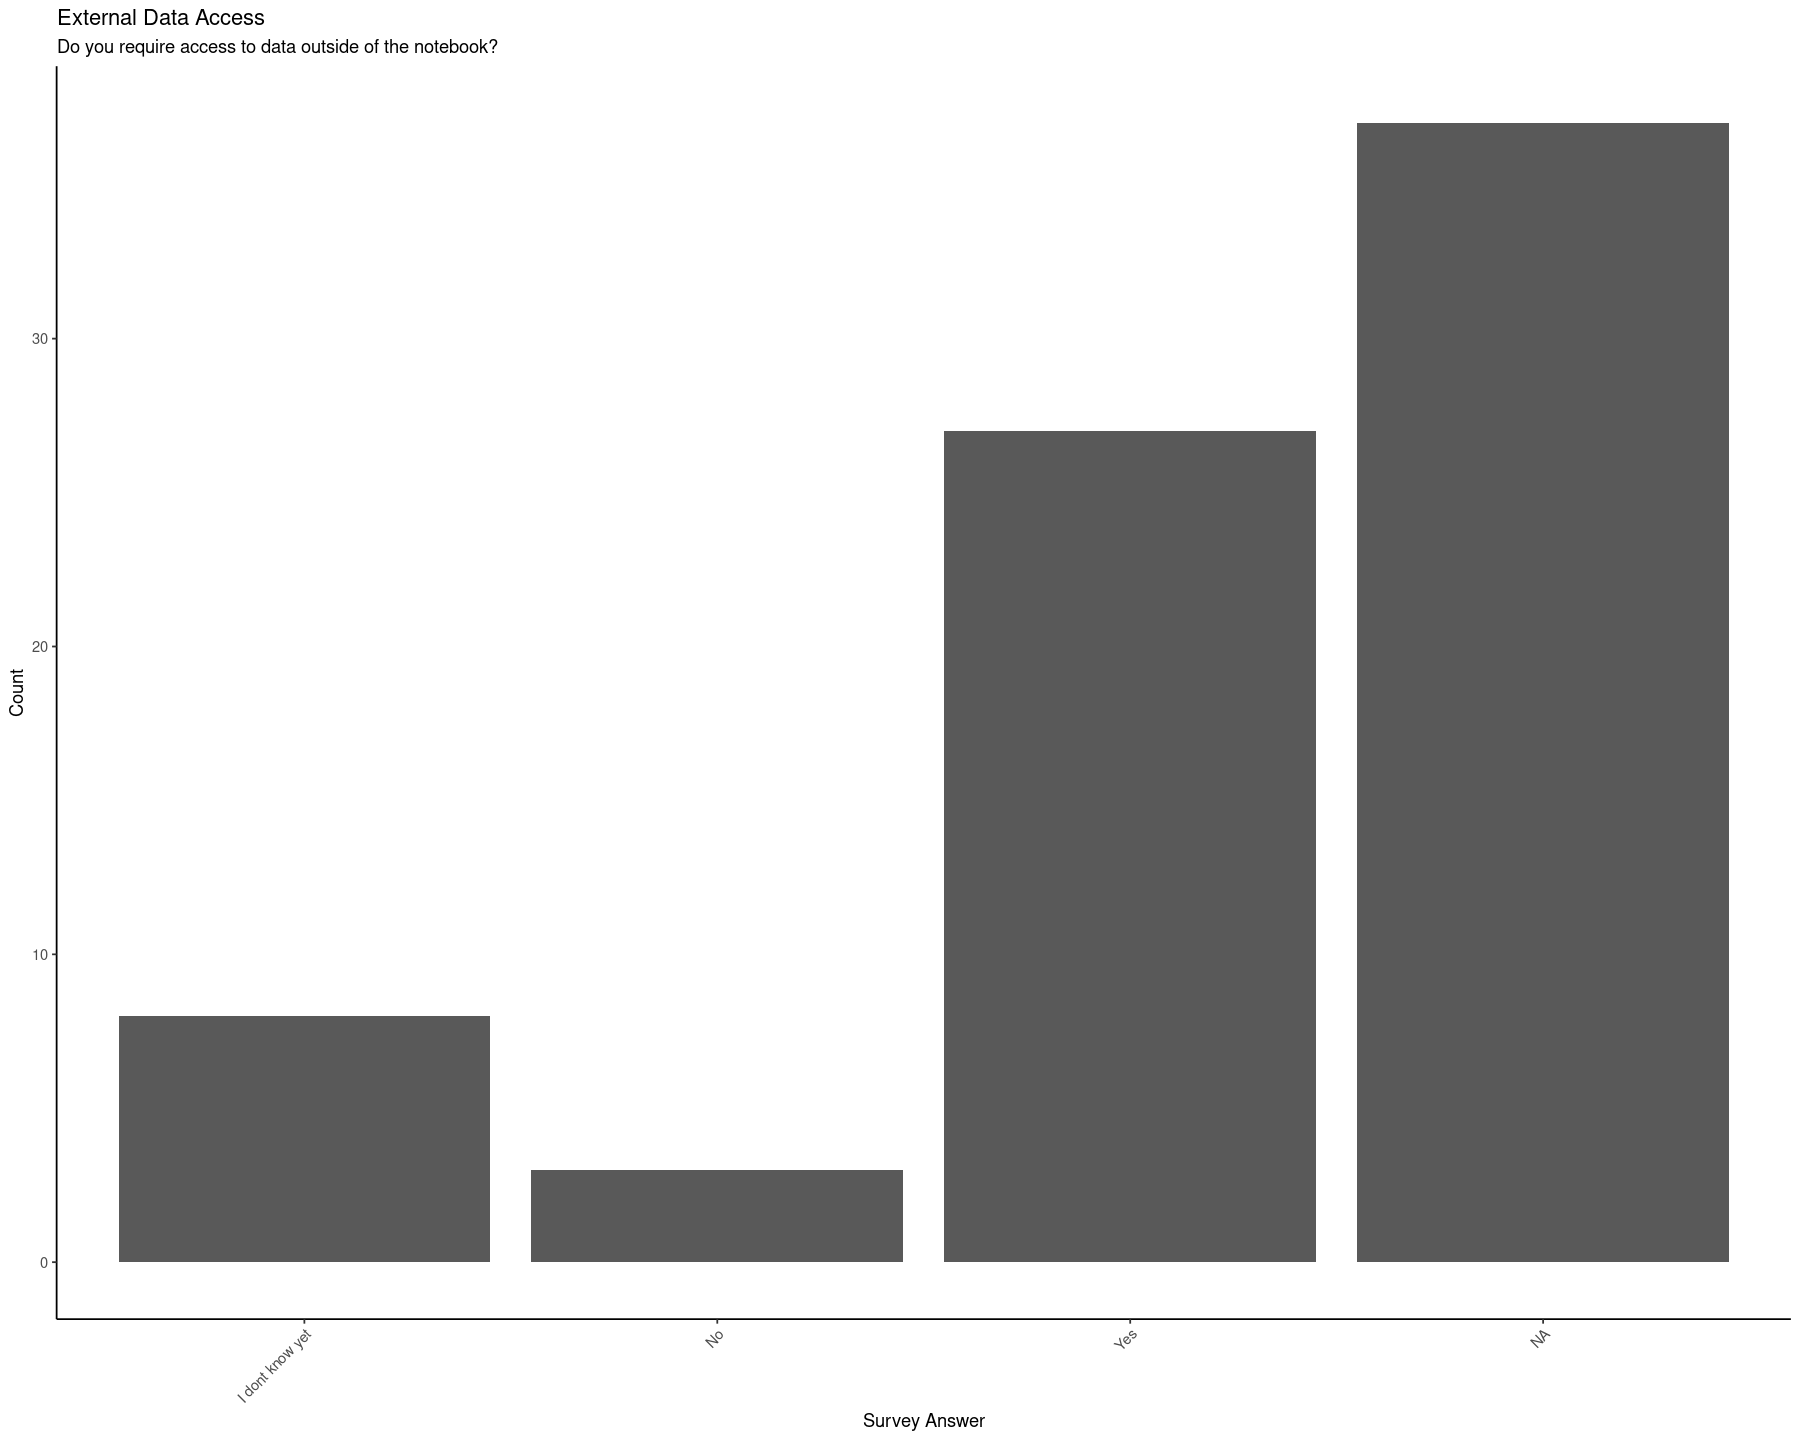

In [86]:
#| fig-align: center

# stacked bar chart
ggplot(data, aes(x = external_data_access)) + 
  geom_bar() +
  labs(title = "External Data Access",
       subtitle = question_info$question_text[32],
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [87]:
# write access
data.frame(table(data$write_access_to_shared_data,useNA = "always"))


Var1,Freq
<fct>,<int>
I dont know yet,7
No,6
Yes,14
NA,48


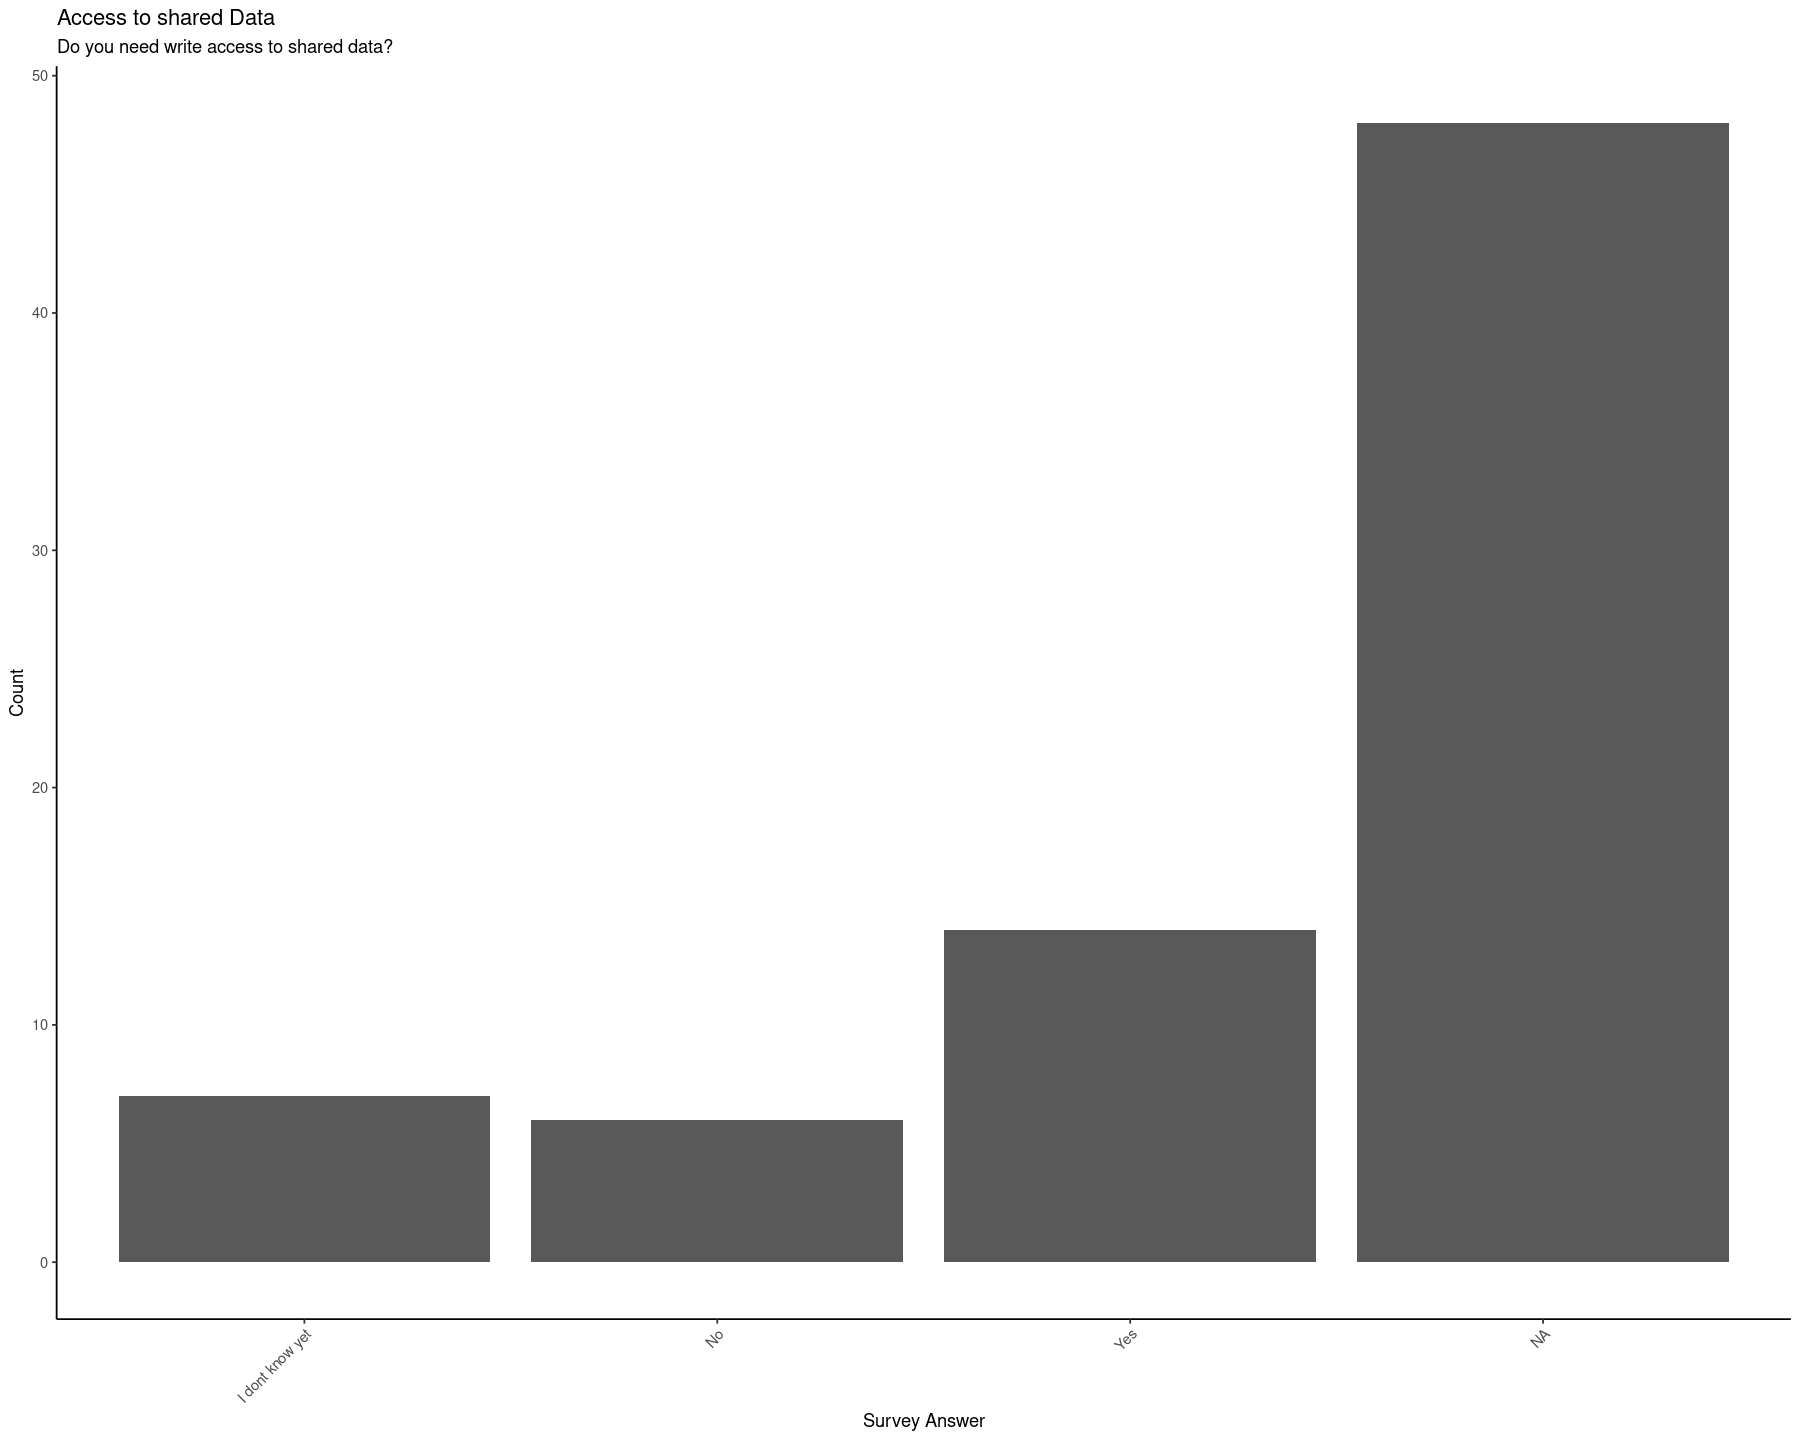

In [88]:
#| fig-align: center

# stacked bar chart
ggplot(data, aes(x = write_access_to_shared_data)) + 
  geom_bar() +
  labs(title = "Access to shared Data",
       subtitle = question_info$question_text[33],
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [89]:
# external_data_sources_link
data$external_data_sources_link[!is.na(data$external_data_sources_link)]


[1] "external triple store (RDF) and file server to query benchmarks input files and store results"
 [2] "This varies a lot."                                                                           
 [3] "https://github.com/echemdb/electrochemistry-data"                                             
 [4] "unsure"                                                                                       
 [5] "data repositories: Zenodo; institutional repository"                                          
 [6] "Raw data from the neutron and X-ray large scale research facilities"                          
 [7] "various HPC data systems"                                                                     
 [8] "local GitLab instance"                                                                        
 [9] "Import from Chemotion would be nice"                                                          
[10] "OpenStack Swift (S3)"                                                                         
[11] "Github"

# Service Offer through Platform

In [90]:
# sservice offer through platform
data.frame(table(data$offer_software_service_through_platform,useNA = "always"))


Var1,Freq
<fct>,<int>
I dont know yet,18
No,11
Yes,9
NA,37


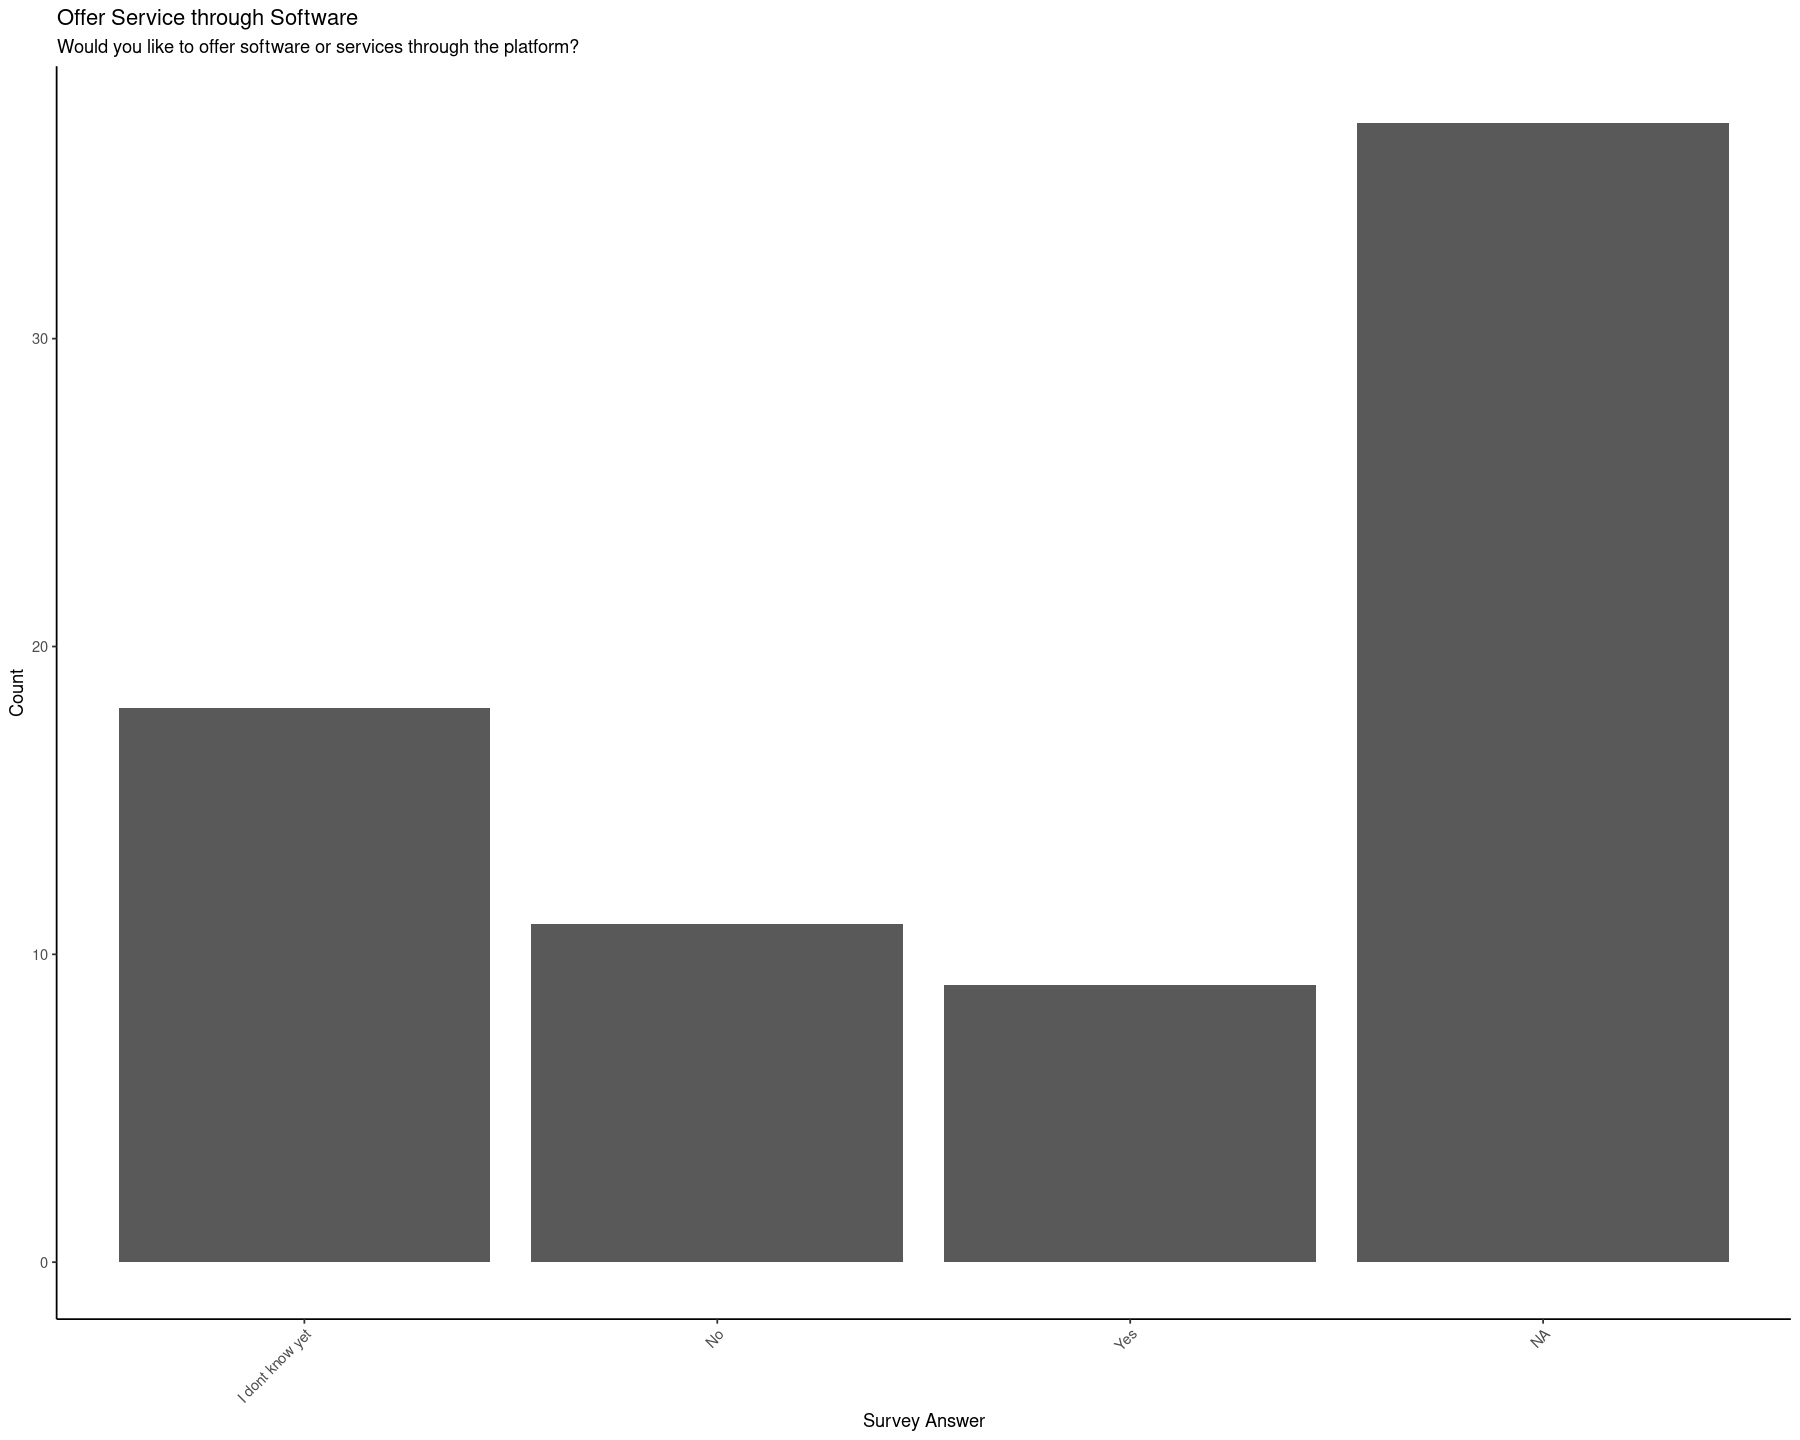

In [91]:
#| fig-align: center

# stacked bar chart
ggplot(data, aes(x = offer_software_service_through_platform)) + 
  geom_bar() +
  labs(title = "Offer Service through Software",
       subtitle = question_info$question_text[35],
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [92]:
# which software service offer
data$which_software_service_offer[!is.na(data$which_software_service_offer)]

[1] "providing benchmark results to other users, compute the benchmarks, and provide parameterized simulation tools to others (such that they can run our models on a platform without to install anything themselves)"
[2] "Public training courses on Python usage and data evaluation"                                                                                                                                                      
[3] "LLMs"                                                                                                                                                                                                             
[4] "Analysis Workflows, open to the public."                                                                                                                                                                          
[5] "training service, eventually user support / consulting service"

Knowing Binder

In [93]:
# Knowing Binder
data.frame(table(data$know_binder,useNA="always"))


Var1,Freq
<fct>,<int>
I already use it,8
I know it and potentially need the functionality,10
I know it but don’t need the functionality,2
Never heard,18
NA,37


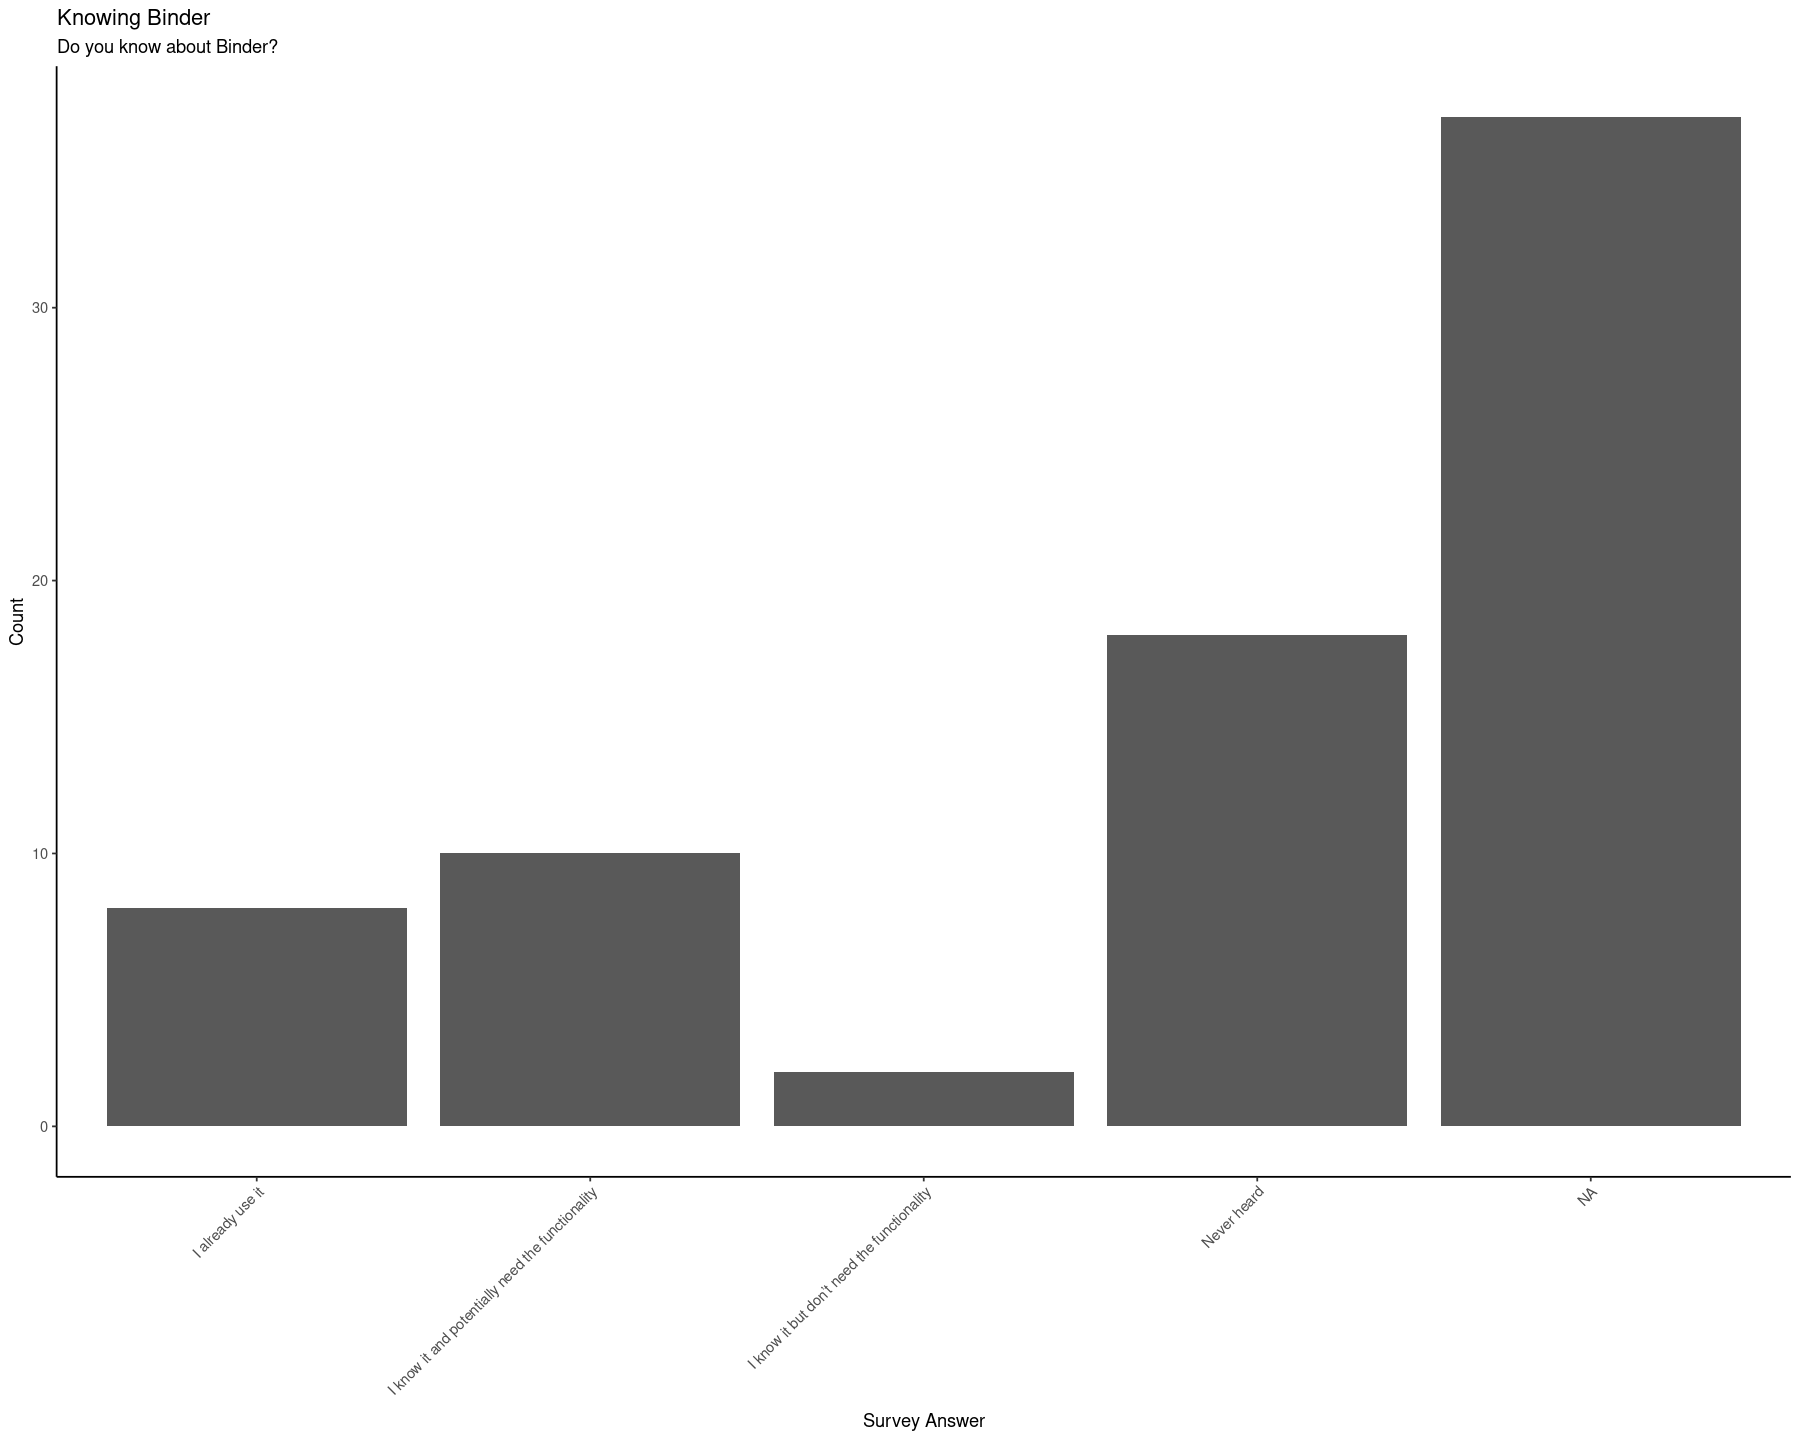

In [94]:
#| fig-align: center

# stacked bar chart
ggplot(data, aes(x = know_binder)) + 
  geom_bar() +
  labs(title = "Knowing Binder",
       subtitle = question_info$question_text[37],
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# Reproducibility needed

In [95]:
data.frame(table(data$reproducibility_needed, useNA = "always"))


Var1,Freq
<fct>,<int>
I dont know yet,11
No,3
Yes,24
NA,37


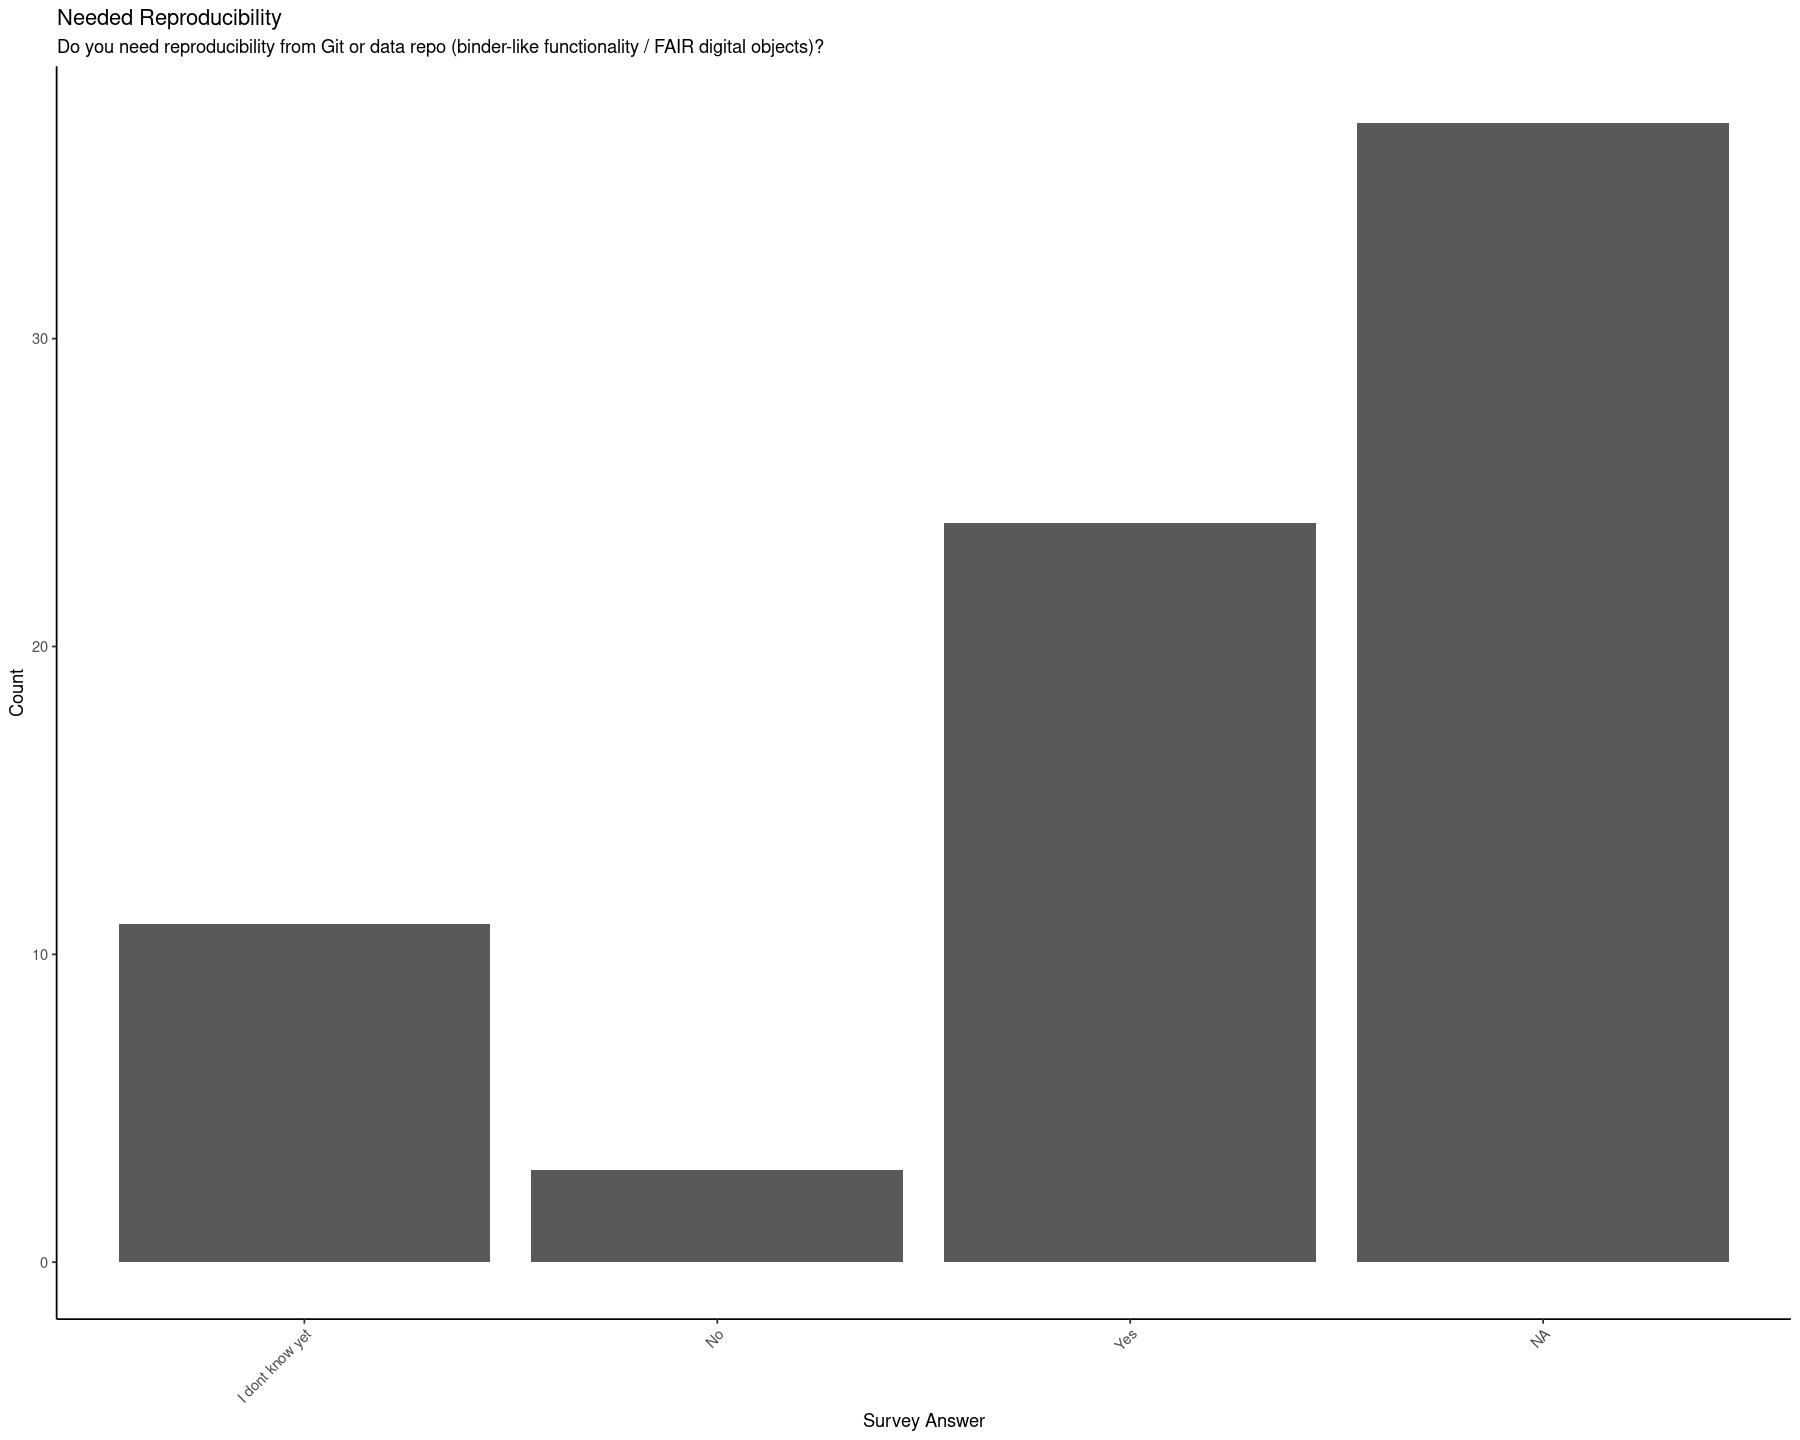

In [96]:
#| fig-align: center

# stacked bar chart
ggplot(data, aes(x = reproducibility_needed)) + 
  geom_bar() +
  labs(title = "Needed Reproducibility",
       subtitle = question_info$question_text[38],
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# Knowing Jupyterlite

In [97]:
# knowing jupyterlite
data.frame(table(data$know_jupyterlite, useNA = "always"))

Var1,Freq
<fct>,<int>
I already use it,3
I know it and potentially need the functionality,7
I know it but don’t need the functionality,3
Never heard,25
NA,37


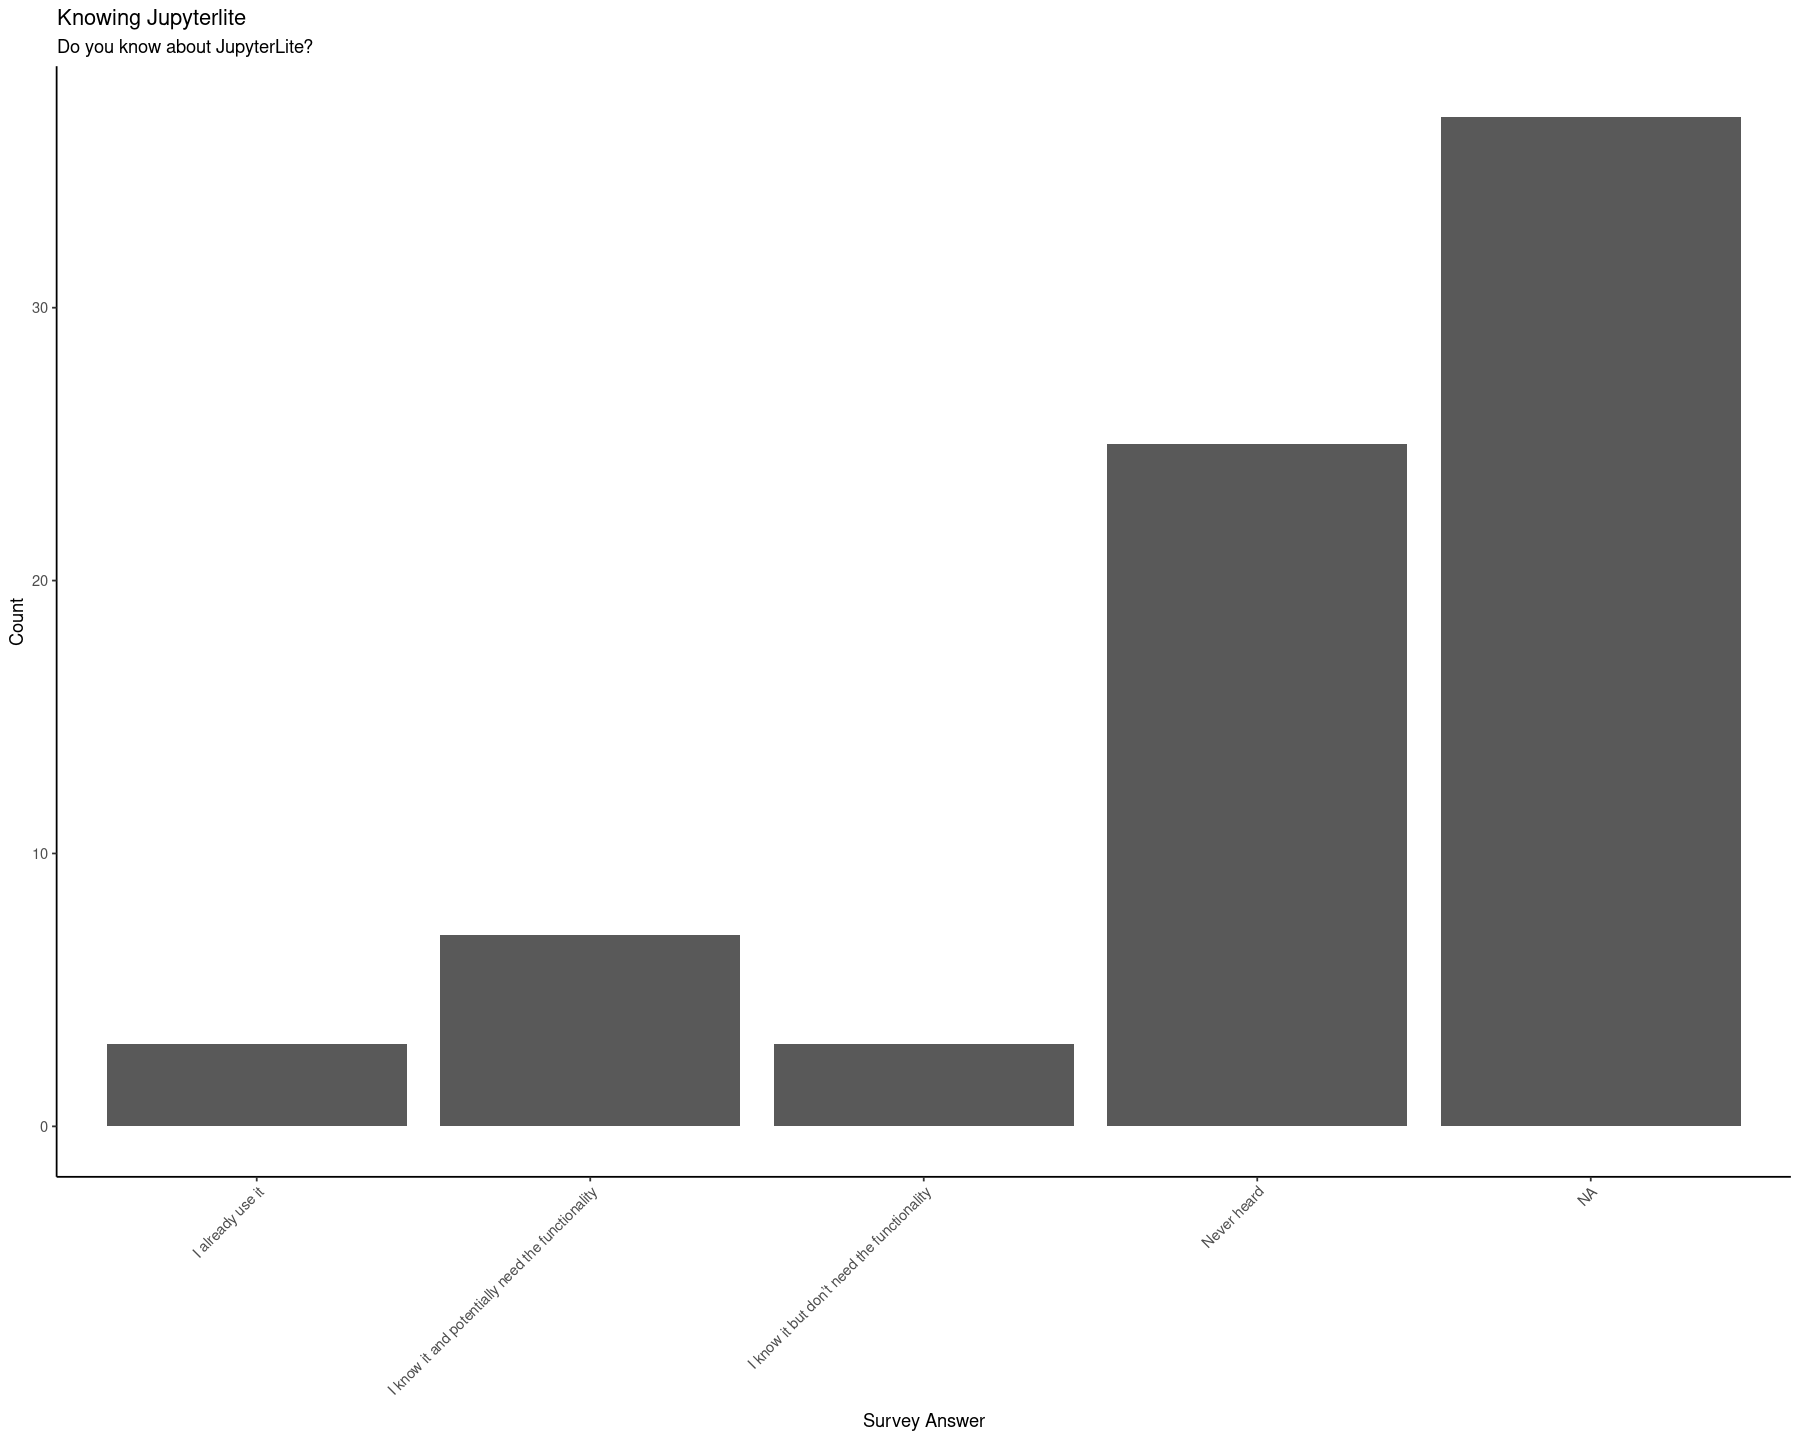

In [98]:
#| fig-align: center

# stacked bar chart
ggplot(data, aes(x = know_jupyterlite)) + 
  geom_bar() +
  labs(title = "Knowing Jupyterlite",
       subtitle = question_info$question_text[39],
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))




# Knowing Google Colab

In [99]:
# knowing Colab
data.frame(table(data$know_colab, useNA = "always"))


Var1,Freq
<fct>,<int>
I already use it,14
I know it and potentially need the functionality,12
I know it but don’t need the functionality,5
Never heard,7
NA,37


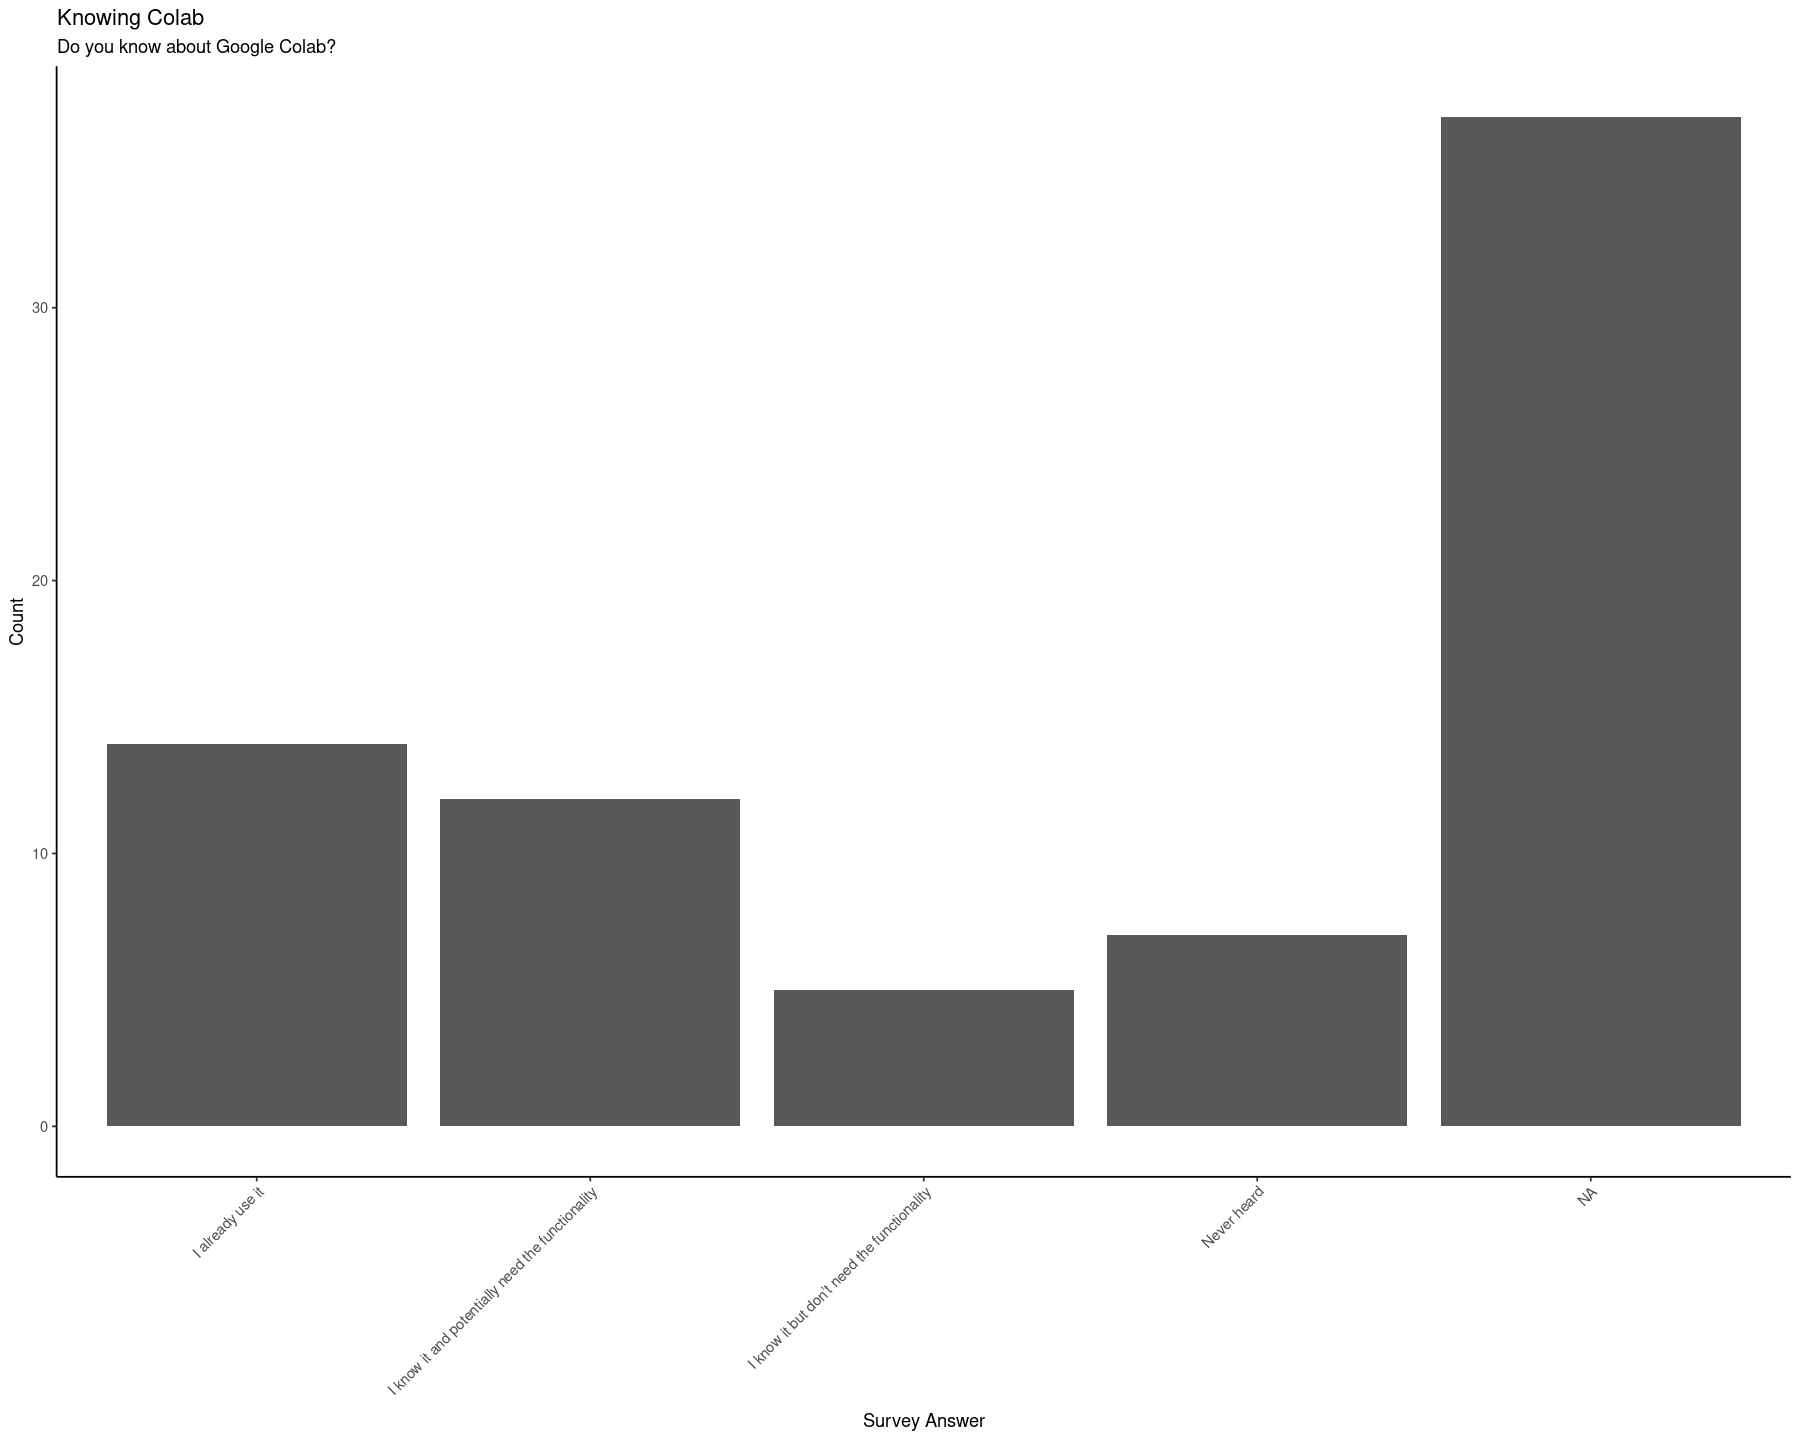

In [100]:
#| fig-align: center

# stacked bar chart
ggplot(data, aes(x = know_colab)) + 
  geom_bar() +
  labs(title = "Knowing Colab",
       subtitle = question_info$question_text[40],
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# Interest in other Services

In [101]:
table(data$interest_in_other_service_vscode,useNA = "always")
prop.table(table(data$interest_in_other_service_vscode,useNA = "always"))*100

table(data$interest_in_other_service_rstudio,useNA = "always")
prop.table(table(data$interest_in_other_service_rstudio,useNA = "always"))*100

other_interest_frame <- rbind.data.frame(table(data$interest_in_other_service_vscode,useNA = "always"),
                                           table(data$interest_in_other_service_rstudio,useNA = "always"))


other_interest_frame <- cbind.data.frame(Service = c("VScode","RStudio"), other_interest_frame)
colnames(other_interest_frame) <- c("Service","Yes","No","NA")

other_interest_frame_long <- tidyr::pivot_longer(
  other_interest_frame, 
  cols = c(Yes, No, `NA`), 
  names_to = "Response", 
  values_to = "Count"
)



  No  Yes <NA> 
  12   26   37 


      No      Yes     <NA> 
16.00000 34.66667 49.33333 


  No  Yes <NA> 
  34    4   37 


       No       Yes      <NA> 
45.333333  5.333333 49.333333 

In [102]:
other_interest_frame_long


Service,Response,Count
<chr>,<chr>,<int>
VScode,Yes,12
VScode,No,26
VScode,NA,37
RStudio,Yes,34
RStudio,No,4
RStudio,NA,37


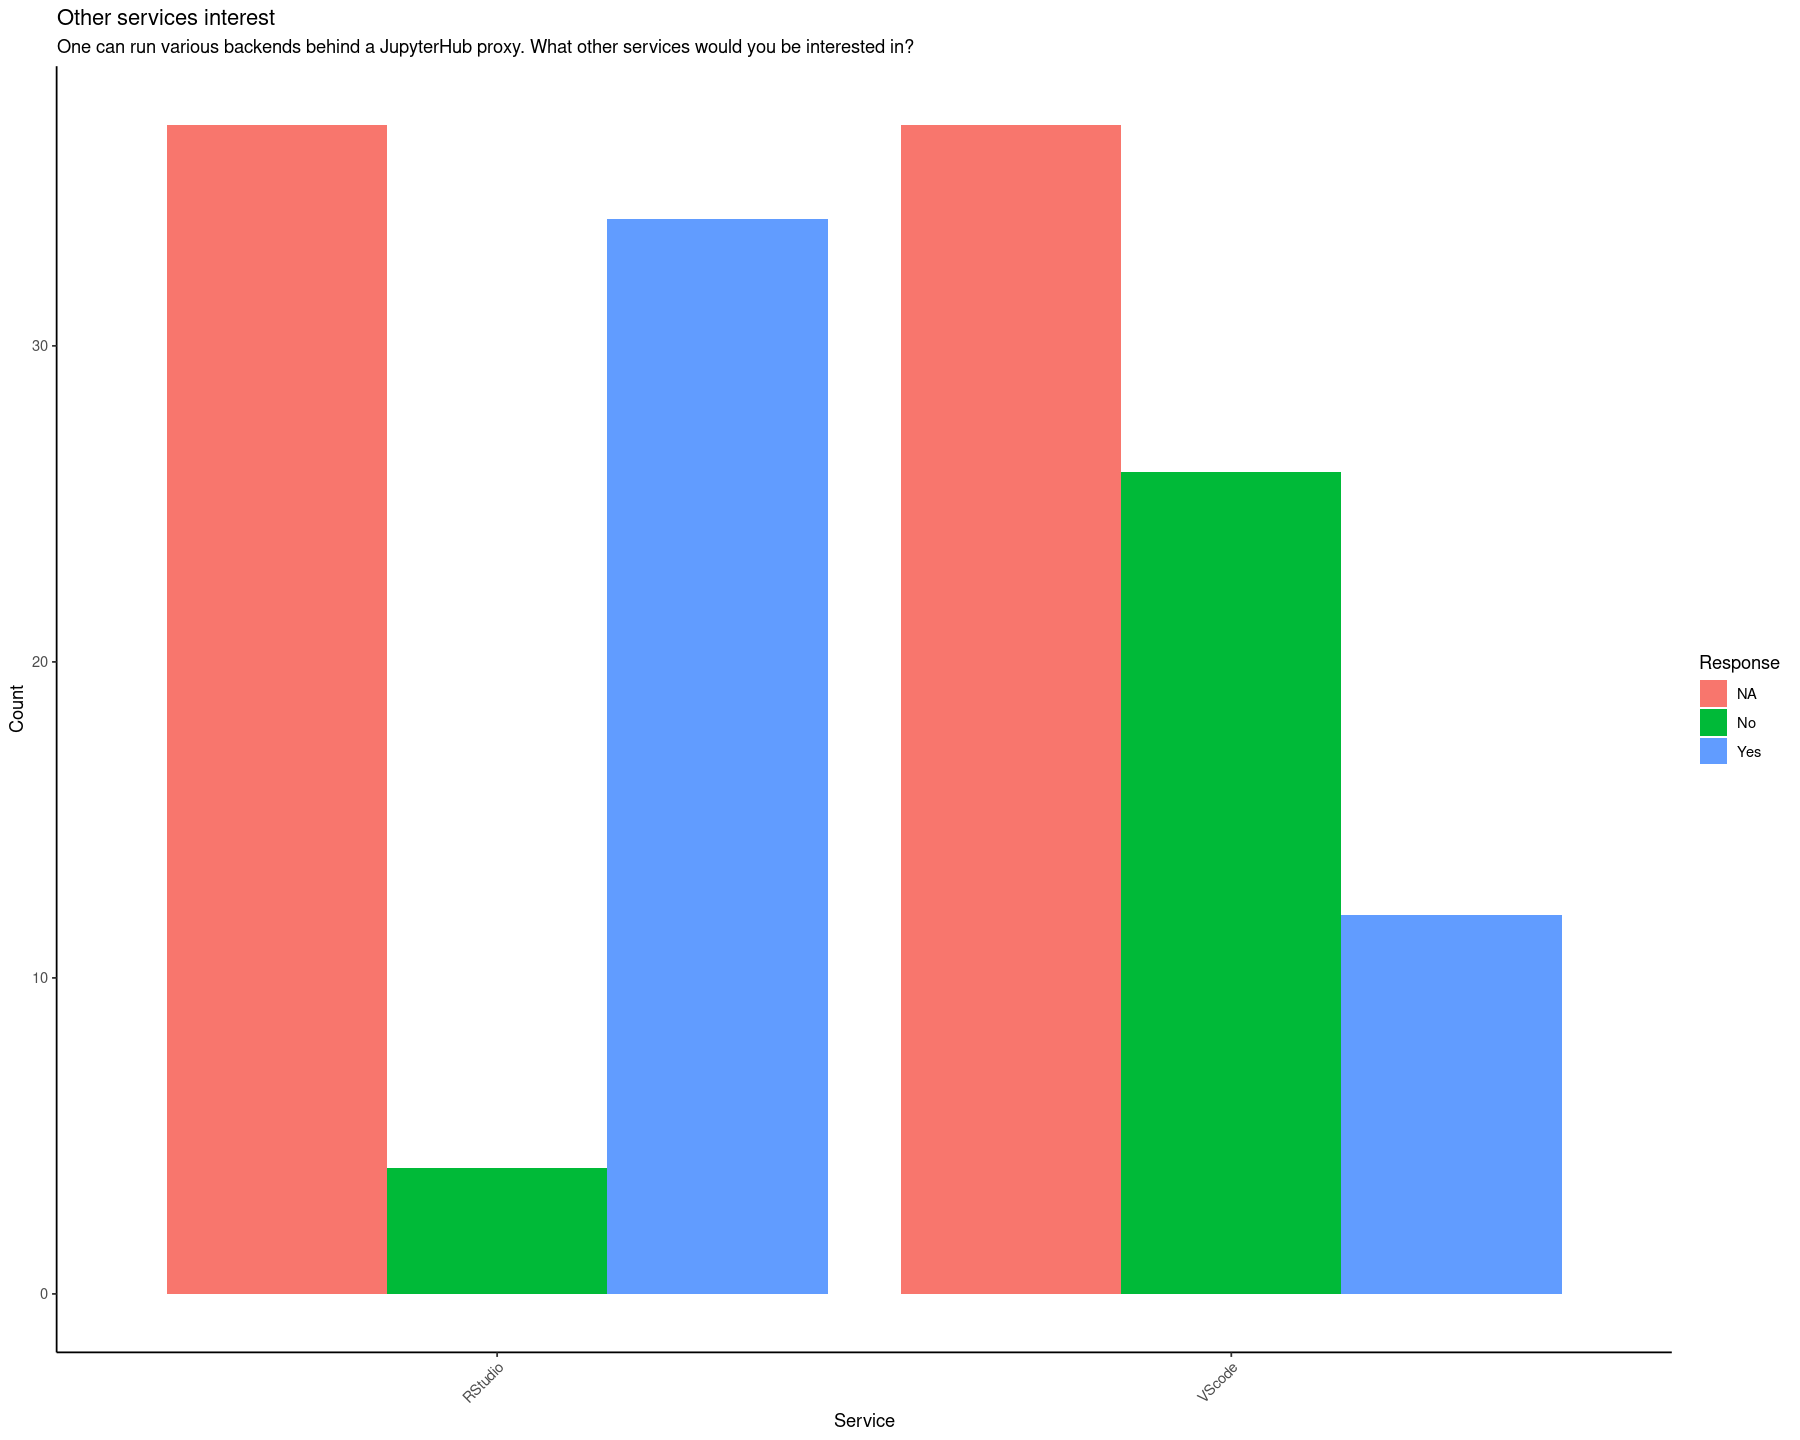

In [103]:
#| fig-align: center

# Create the dodged bar graph
ggplot(other_interest_frame_long, aes(x = Service, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Other services interest",
    subtitle = question_info$question_text[43],
    x = "Service",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [104]:
# Other service interest
data$interest_in_other_service_other[!is.na(data$interest_in_other_service_other)]

[1] "MATLAB"     "test"       "JupyterLab" "xpre"

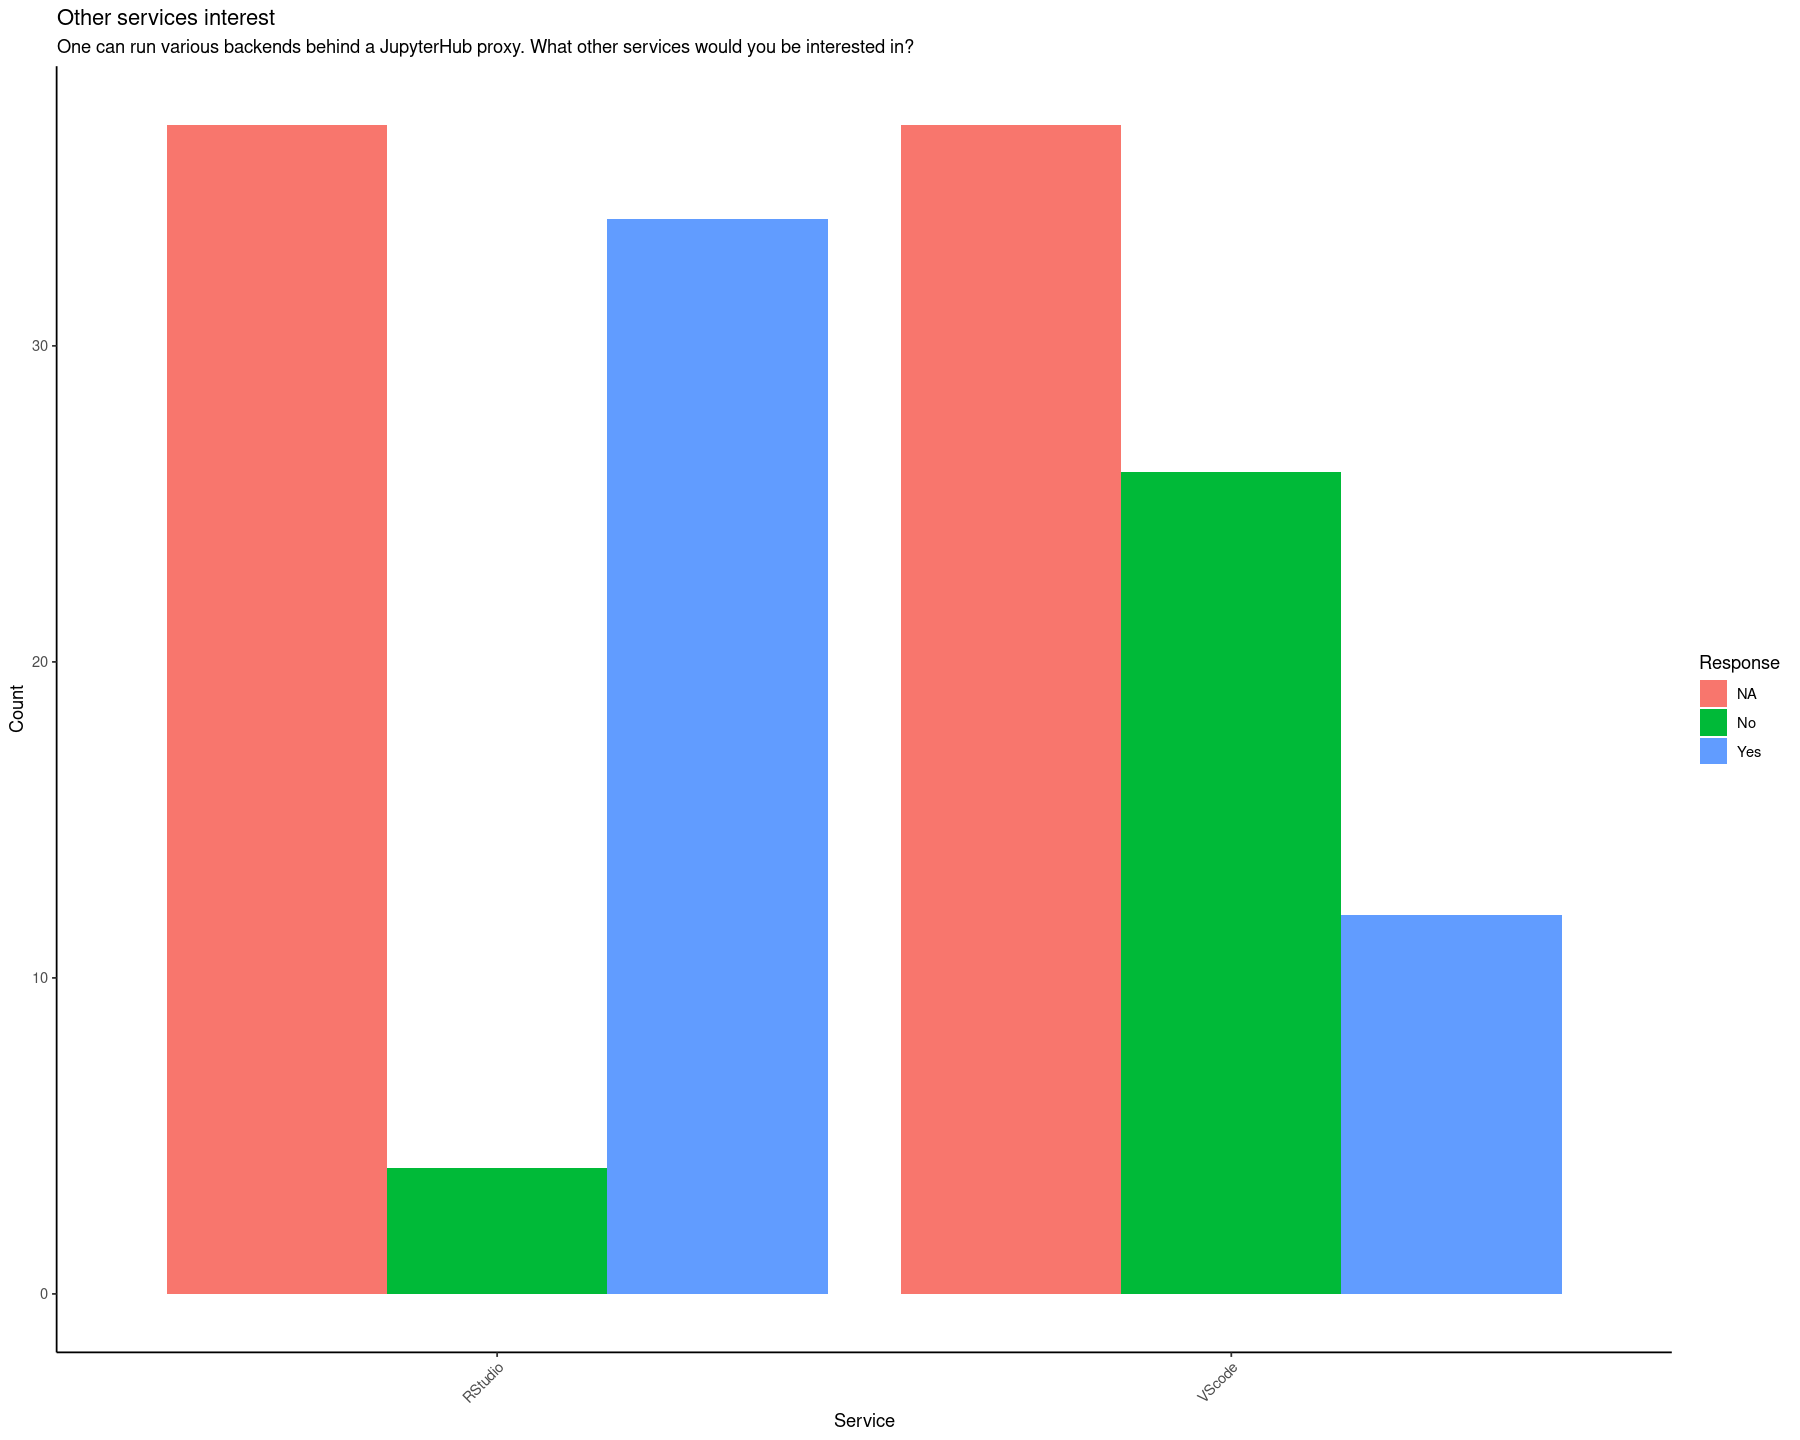

In [105]:
#| fig-align: center

# Create the dodged bar graph
ggplot(other_interest_frame_long, aes(x = Service, y = Count, fill = Response)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(
    title = "Other services interest",
    subtitle = question_info$question_text[43],
    x = "Service",
    y = "Count",
    fill = "Response"
  ) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Further Contact

In [106]:
# further contact
#data$further_contact
#table(data$further_contact,useNA = "always")
#prop.table(table(data$further_contact,useNA = "always"))*100
data.frame(table(data$further_contact,useNA = "always"))

Var1,Freq
<fct>,<int>
No,22
Yes,35
NA,18


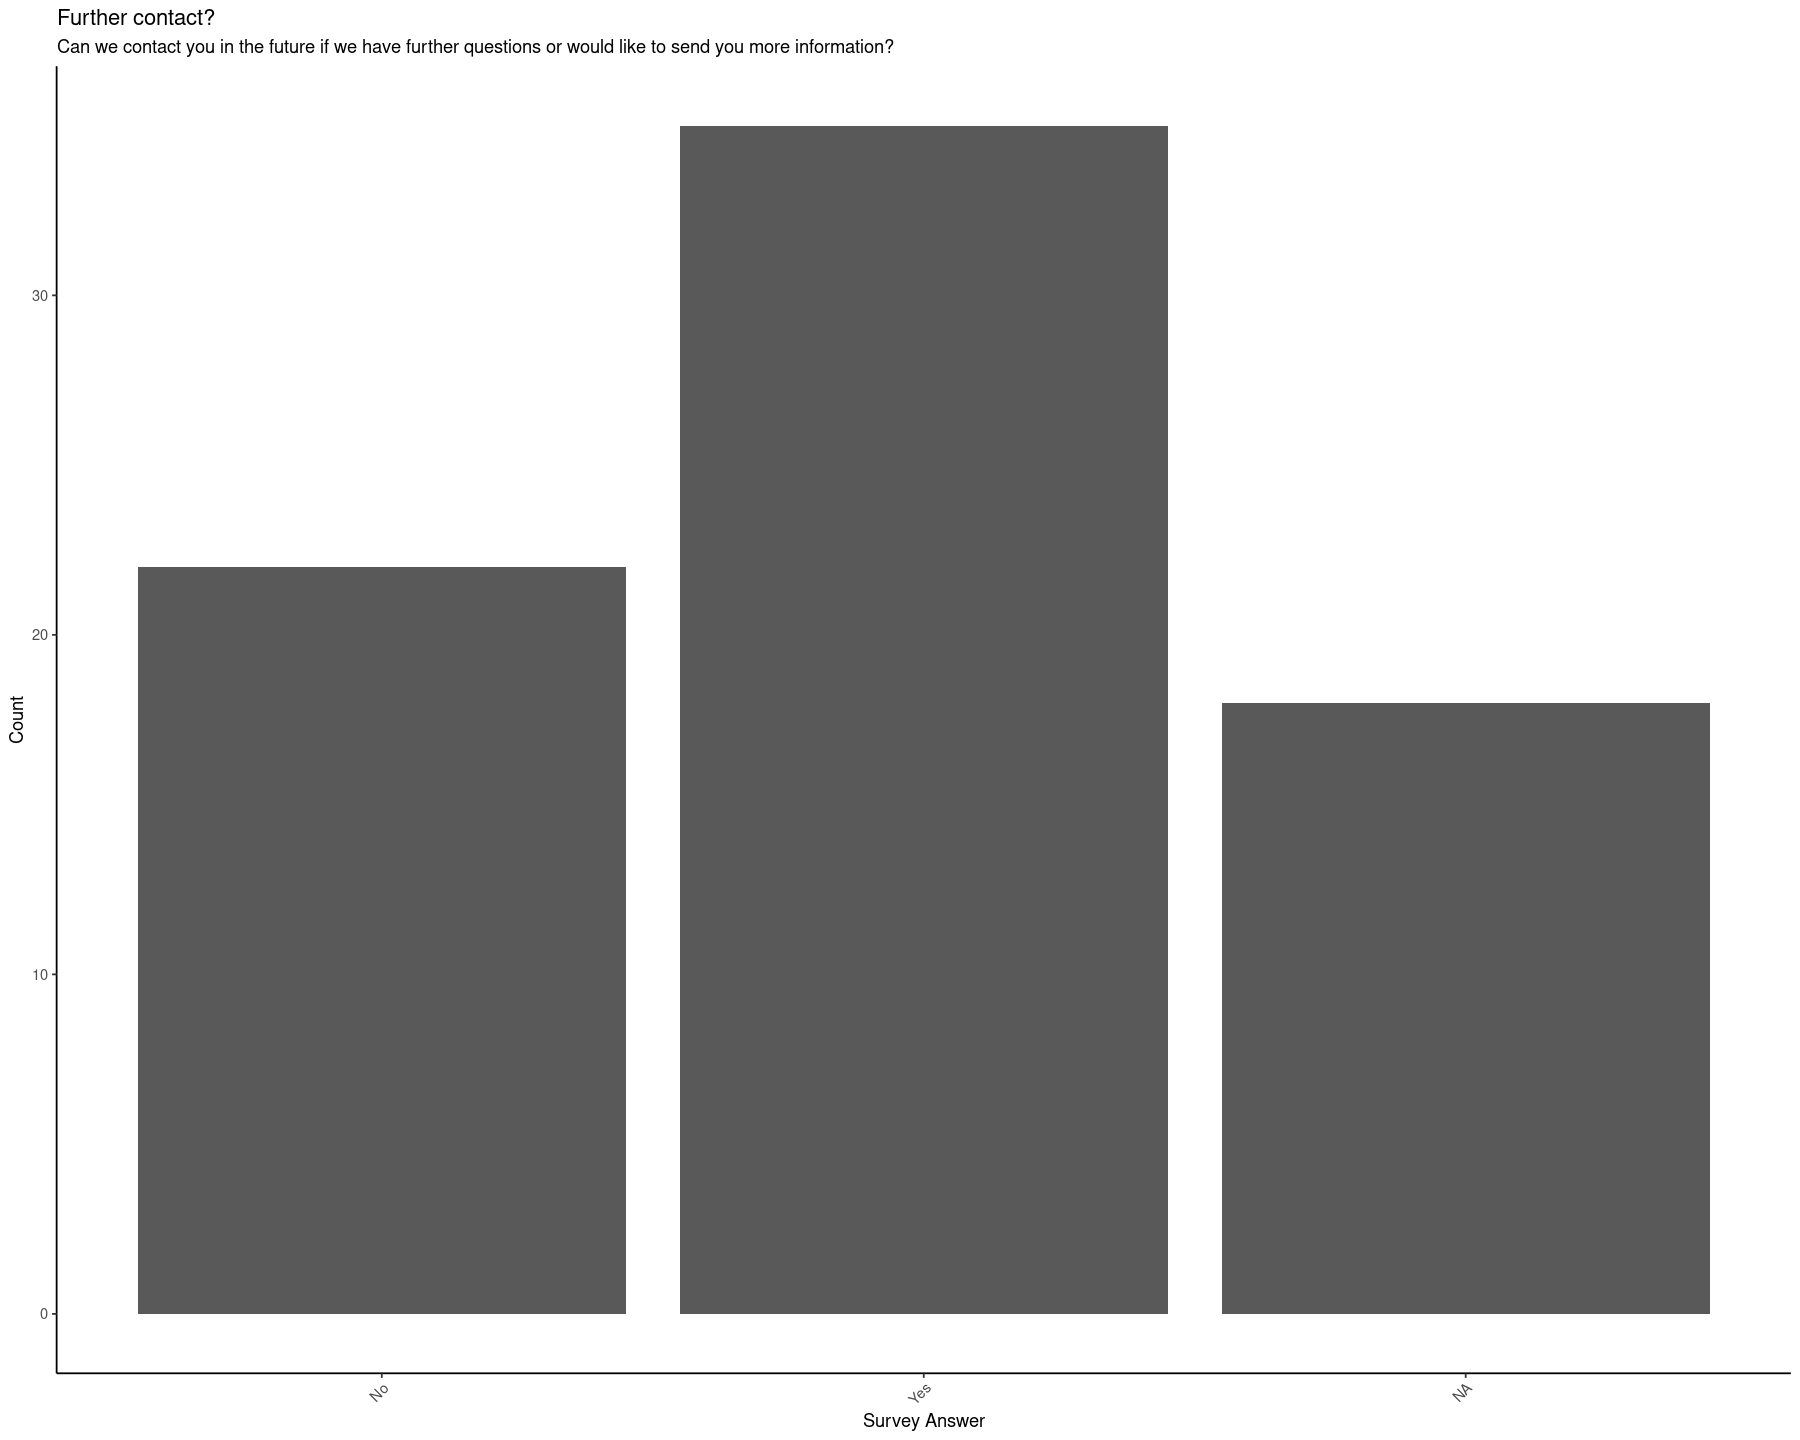

In [107]:
#| fig-align: center

# stacked bar chart
ggplot(data, aes(x = further_contact)) + 
  geom_bar() +
  labs(title = "Further contact?",
       subtitle = question_info$question_text[44],
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



# User Study Willingness

In [108]:
# user study willingness
#data$user_study_willingness
#table(data$user_study_willingness,useNA = "always")
#prop.table(table(data$user_study_willingness,useNA = "always"))*100
data.frame(table(data$user_study_willingness,useNA = "always"))


Var1,Freq
<fct>,<int>
No,4
Yes,23
NA,48


[1] "Would you be willing to participate in a user study? By participating in a user study, you will be asked to use a tool developed for the Jupyter services and provide your feedback on how you like the functionality, how easy it is to use, what can be improved upon etc. The user study experts in Base4NFDI, which in turn supervises Jupyer4NFDI, would use your contact details for these purposes."

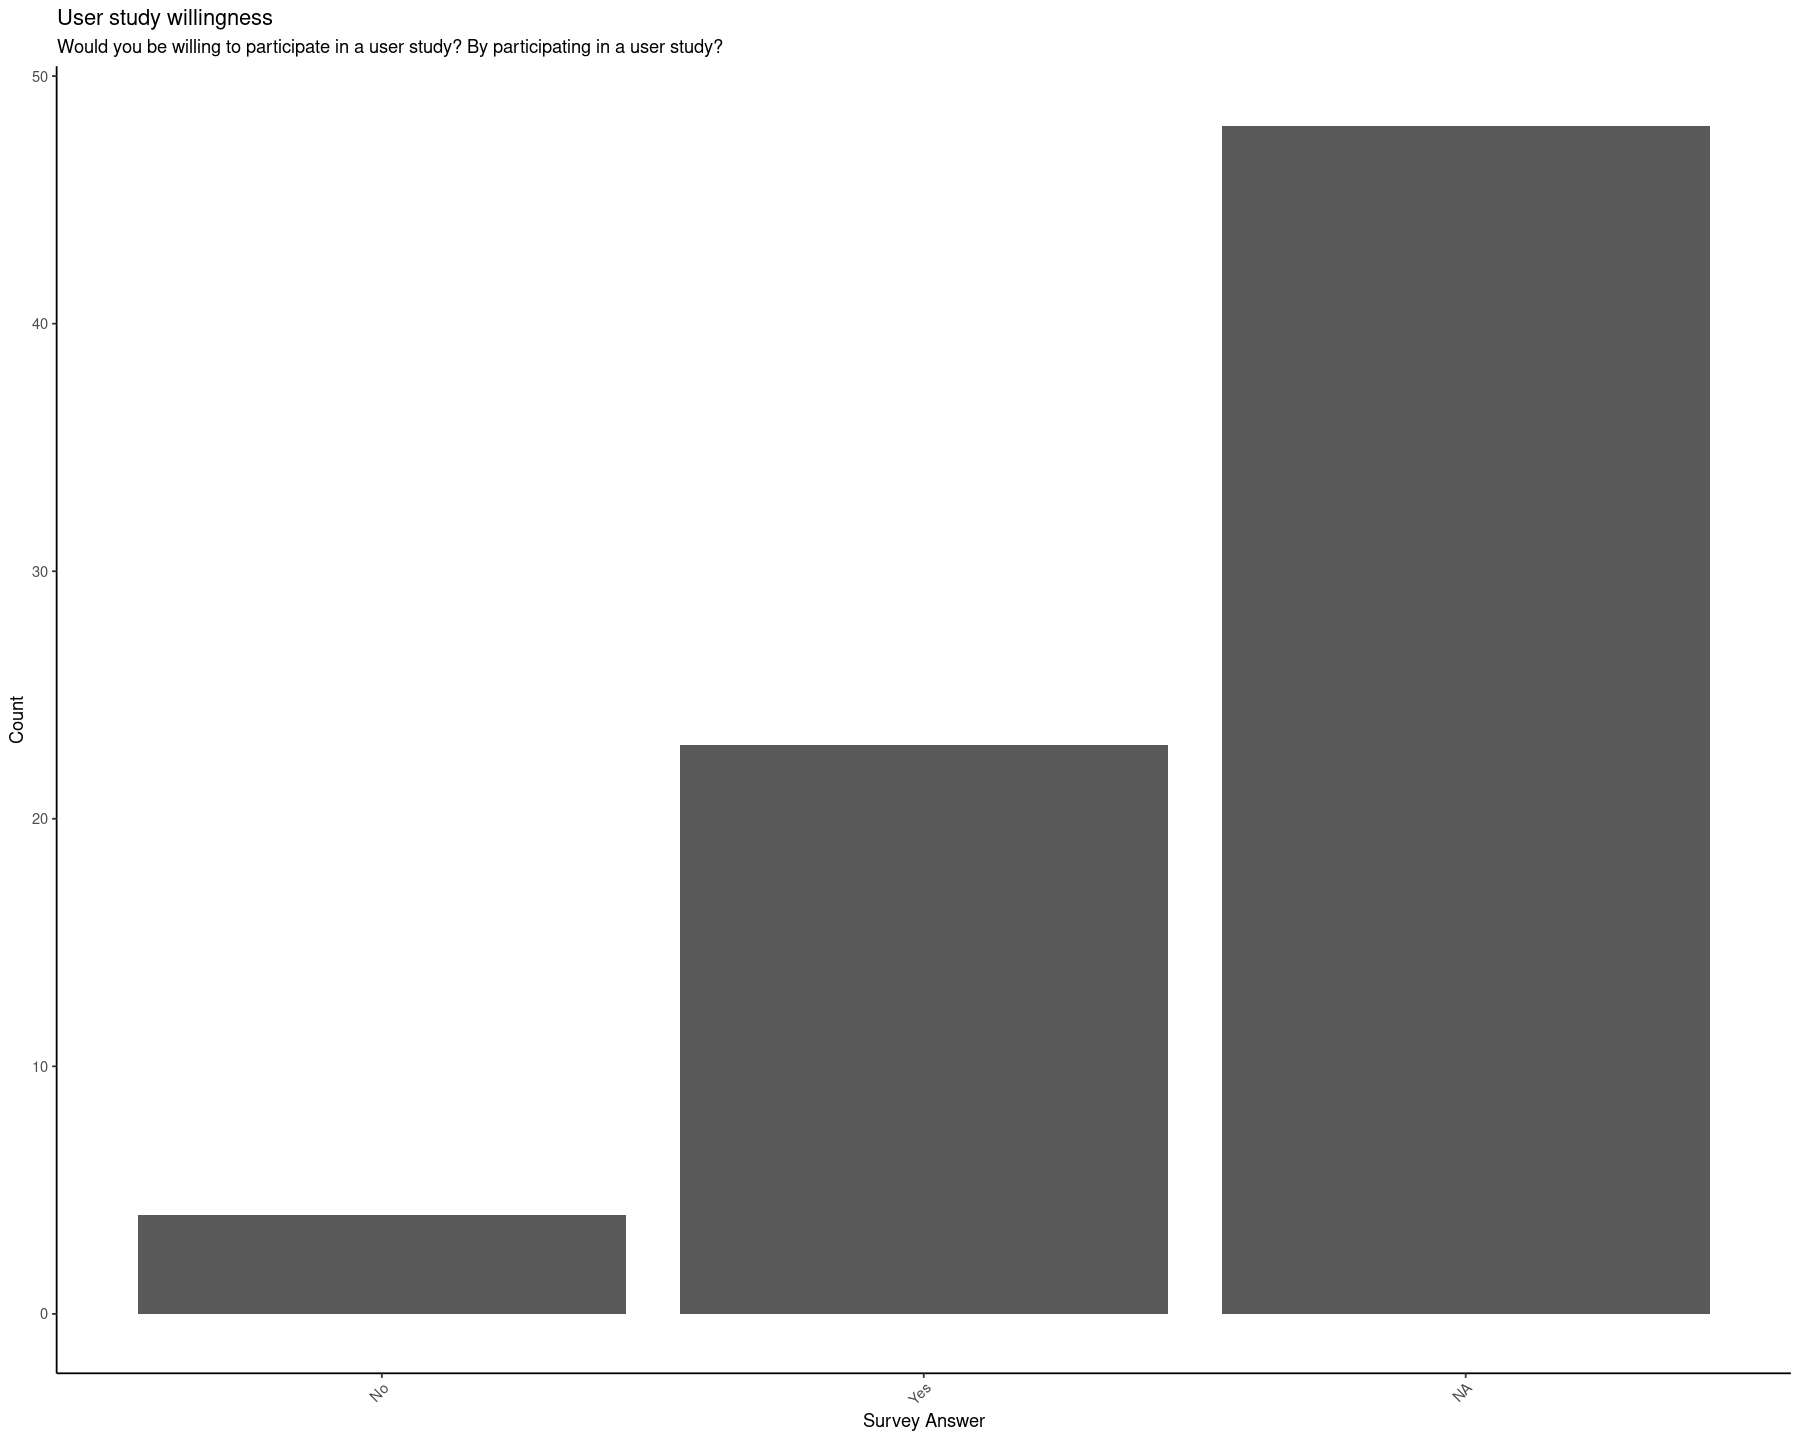

In [109]:
#| fig-align: center

question_info$question_text[48]
q_text2 <- "Would you be willing to participate in a user study? By participating in a user study?"

# stacked bar chart
ggplot(data, aes(x = user_study_willingness)) + 
  geom_bar() +
  labs(title = "User study willingness",
       subtitle = q_text2,
       x = "Survey Answer",
       y = "Count") +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Open ended Questions

<div class="alert alert-info" role="alert">
  <strong>LLM-supported analysis of open-ended questions</strong><br>
  We provide code and results here for analyzing open-ended survey responses using the ChatGPT API. Because the API requires an API key, we cannot provide a ready-to-run code example here. If you have an OpenAI API key, you can paste it here, uncomment the corresponding code lines, and rerun them. We do provide the results of us running the code here.
</div>


In [110]:
# TODO: To execute remotely, replace with your own API key for chatGPT
api_key <- "OPENAI_API_KEY"

In [111]:
send_chatgpt_request <- function(prompt, api_key, max_toks = 5000, temp = 0.0) {
  url <- "https://api.openai.com/v1/chat/completions"
  
  headers <- add_headers(
    `Authorization` = paste("Bearer", api_key),
    `Content-Type` = "application/json"
  )
  
  body <- list(
    model = "gpt-4o", 
    messages = list(
      list(role = "system", content = "You are a helpful assistant."),
      list(role = "user", content = prompt)
    ),
    temperature = temp, 
    max_tokens = max_toks 
  )
  
  response <- POST(url, headers, body = body, encode = "json")
  
  if (status_code(response) == 200) {
    content <- content(response, as = "parsed")
    return(content$choices[[1]]$message$content)
  } else {
    stop("Request failed: ", status_code(response), "\n", content(response, as = "text"))
  }
}


## How is Jupyter used

In [112]:
data$jupyter_use_how[!is.na(data$jupyter_use_how)]
answer_collection <- paste(data$jupyter_use_how[!is.na(data$jupyter_use_how)],collapse = " | ")

[1] "we would like to provide our simulations to partners that can use the compute environment provided by us via the jupyterhub"                                                                                                                                                                                                                                                                                                                                                                                                                                            
 [2] "I do not use Jupyter at the moment"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
 [3] "Have not been able to get in yet with my university account :("                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
 [4] "JupyterHub integrate as one component in the overall architecture of NFDI4Cat. JupyterHub used to write scripts to process and analyze domain-specific data. "                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "Right now I'm not using Jupyter that often. In my experience in the energy domain, jupyter notebooks are used for:\n- Analysis / Plotting of results\n- Optimization problems and energy system design with packages like https://www.pandapower.org/ or https://pypsa.org/\n- Some deep learning applications"                                                                                                                                                                                                                                                         
 [6] "I use Jupyter for coding in Python (Google Colab and Jupyter Notebook run locally on PC)."                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
 [7] "utilizing jupyter notebooks for (batch) image analysis on performant hardware \noften needs custom images / python environments due to dependencies. (TensorFlow vs. PyTorch, jpype, etc.)\n"                                                                                                                                                                                                                                                                                                                                                                           
 [8] "On a daily basis for testing and/or finalizing"                                   

In [113]:
# send request
#jupyter_use_how_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about how participants are currently using #Jupyter. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
#                                                 api_key,
#                                                 max_toks = 5000,
#                                                 temp = 0.0)


In [114]:
#message(jupyter_use_how_summary)

The survey responses reveal several key themes regarding the use of Jupyter:

1. **Data Analysis and Visualization**: Many respondents use Jupyter for data analysis, often in conjunction with Python and R. This includes processing geospatial, genomic, transcriptomic, and experimental data, as well as neutron and X-ray measurements. Visualization tools like Plotly are also mentioned.

2. **Education and Teaching**: Jupyter is widely used in educational settings, from teaching university courses to providing hands-on learning opportunities through data analysis courses. It is used for teaching programming, data science, and specific scientific domains.

3. **Prototyping and Development**: Jupyter is frequently used for quick prototyping and exploratory coding. It allows users to rapidly script code and develop data analysis solutions.

4. **Collaboration and Sharing**: Jupyter facilitates collaboration by enabling easy sharing of notebooks and workflows. It is used to discuss and share analysis results with colleagues and partners.

5. **Infrastructure and Deployment**: Several institutions deploy JupyterHub or similar services to provide a compute environment for users. This includes hosting on Kubernetes, OpenShift, and other cloud or local infrastructures.

6. **Domain-Specific Applications**: Jupyter is used in various domain-specific applications, such as energy system design, machine learning pipelines for pulsar analysis, cheminformatics workflows, and computational chemistry.

7. **Integration with Other Tools**: Jupyter is integrated with other tools and environments, such as Google Colab, Galaxy, and ArcGIS Notebookserver. It supports multiple programming languages and can serve as a general login hub for web-based services.

8. **Challenges and Future Plans**: Some respondents mention challenges in accessing Jupyter or not currently using it but planning to adopt it for future projects. There is interest in exploring Jupyter's potential for enhancing workflows and promoting reproducible research.

Overall, Jupyter is a versatile tool used across various fields for data analysis, education, prototyping, and collaboration, supported by robust infrastructure and integration capabilities.

## Expected benefits of jupyter4NFDI

In [115]:
# Expected Benefits of Jupyter4NFDI
data$jupyter_nfdi_expected_benefits[!is.na(data$jupyter_nfdi_expected_benefits)]
answer_collection <- data$jupyter_nfdi_expected_benefits[!is.na(data$jupyter_nfdi_expected_benefits)]
answer_collection <- paste(answer_collection,collapse = " | ")


[1] "not that much as the Jupyter concept is not used in HPC centers due to security concerns. Therefore, we have to develop alternative solutions for HPC TIER-1 access (our task within NFDI)."                                                                                                                                                                                                                                                                                                                                                                  
[2] "Access to JupyterHub instance for research and teaching. "                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
[3] "possibility to integrate and share own tools in a FAIR manner.\nuse existing tools from community and apply these tools to own data"                                                                                                                                                                                                                                                                                                                                                                                                                          
[4] "No need to set things up for yourself. "                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
[5] "The group I am coordinating consists mainly of software developers resp. software developing scientists, both from the photon-source facility field (close to service providers) and from the academic sector (close to service users). The latter could directly benefit from a Jupyter service to run/test/apply their code/notebooks - in particular if data sharing/transfer is linked to compute resources - the former could get inspiration for the Jupyter services of their facility an/or starting points to connect with / integrate to  the NFDI."
[6] "I have no clear idea.\nMaybe some service desk where one could email for specific questions that one cannot solve with ChatGPT or other agents"                                                                                                                                                                                                                                                                                                                                                                                                               
[7] "facilitation of knowledge"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
[8] "Simplified and more secure setup for our in-house Jupyterhub. First-class SLURM support."

In [116]:
# send request
#jupyter_NFDI_benefits_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about the expected benefits of using the #Jupyter NFDI Hub. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
#                                                       api_key,
#                                                       max_toks = 5000,
#                                                       temp = 0.0)

In [117]:
#message(jupyter_NFDI_benefits_summary)

The survey responses highlight several key themes regarding the expected benefits of using the Jupyter NFDI Hub:

1. **Access and Integration**: Many respondents see value in having access to a JupyterHub instance for both research and teaching purposes. There is also an emphasis on the ability to integrate and share tools in a FAIR (Findable, Accessible, Interoperable, and Reusable) manner, as well as using existing community tools on their own data.

2. **Ease of Use and Setup**: A significant benefit mentioned is the reduced need for individual setup, which simplifies the process for users.

3. **Support for Software Development**: The hub is seen as beneficial for software developers and scientists, particularly in facilitating the running, testing, and application of code and notebooks. This is especially relevant when data sharing and transfer are linked to compute resources.

4. **Inspiration and Connectivity**: The hub could serve as a source of inspiration for facilities to develop their own Jupyter services and as a starting point for integration with the NFDI.

5. **Security and HPC Concerns**: There are concerns about the use of Jupyter in high-performance computing (HPC) centers due to security issues, indicating a need for alternative solutions for HPC access.

6. **Support and Facilitation**: There is a desire for a service desk or support system to address specific questions that cannot be resolved through automated agents like ChatGPT.

7. **Technical Enhancements**: Respondents express a need for a simplified and more secure setup for in-house JupyterHub instances, with specific mention of first-class SLURM support.

Overall, the responses reflect a mix of enthusiasm for the potential benefits of the Jupyter NFDI Hub, alongside concerns about security and the need for robust support and integration features.

## Jupyter4NFDI Advantages over other services

In [118]:
# JupyterNFDI advantages over others
data$jupyter4NFDI_advantages_over_others[!is.na(data$jupyter4NFDI_advantages_over_others)]
answer_collection <- data$jupyter4NFDI_advantages_over_others[!is.na(data$jupyter4NFDI_advantages_over_others)]
answer_collection <- paste(answer_collection,collapse = " | ")

[1] "as far as I know, it is difficult to install new conda packages in Colab, and we can't build docker images for binder due to restrictions from our IT (docker is not allowed), flexible allocation of ressoruces (if needed), "
 [2] "Faster than Binder (esp. starting), more powerful then JupyterLite, more secure/private than Colab"                                                                                                                            
 [3] "1. Use case: Special resources (large GPU, RAM) for selected users, 2. Use case: Tutorials in jupyter integrated in lectures "                                                                                                 
 [4] "Safe and easy collaberation within and across NFDI consortia"                                                                                                                                                                  
 [5] "cannot judge this"                                                                                                                                                                                                             
 [6] "Easy connections to PUNCH4NFDI tools and data"                                                                                                                                                                                 
 [7] "lower maintenance overhead on my end"                                                                                                                                                                                          
 [8] "A predefined environment for courses/teaching for people from various Universities/Research Institutes."                                                                                                                       
 [9] "unsure"                                                                                                                                                                                                                        
[10] "allocation of large processing ressources"                                                                                                                                                                                     
[11] "Institutional control and support; customisation w/r/t requirements for teaching, interface with LMS and institutional data repositories"                                                                                      
[12] "A single platform that unifies the NFDI consortias work and knowledge, to possibly collaborate, copy and adapt existing workflows or similar."                                                                                 
[13] "Easy / direct access to my research data"                                                                                                                                                                                      
[14] "Free to use, no issues with data security"                                                                                                                                                                                     
[15] "Digital Sovereignty, GDPR-compliance"                                                                                                                                                                                          
[16] "Guidance and options to create FAIR output"                                                                                                                                                                                    
[17] "unified ressources, secure data storage, easy access through my university"                                                                                                                                                    
[18] "Researchers could publish the datasets and data processing workflow of their research

In [119]:
# send request
#jupyter_NFDI_advantages_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about the advanatages of Jupyter4NFDI #over other similar services. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
#                                                      api_key,
#                                                      max_toks = 5000,
#                                                      temp = 0.0)

In [120]:
#message(jupyter_NFDI_advantages_summary)

The survey responses highlight several key advantages of Jupyter4NFDI over other similar services:

1. **Resource Flexibility and Allocation**: Jupyter4NFDI offers flexible allocation of resources, including large GPUs and RAM, which is beneficial for specific use cases and selected users. This is contrasted with limitations in other platforms like Colab and Binder.

2. **Performance and Efficiency**: Users noted that Jupyter4NFDI is faster than Binder, especially in terms of startup time, and more powerful than JupyterLite.

3. **Security and Privacy**: The platform is perceived as more secure and private than alternatives like Colab, with a focus on data security, digital sovereignty, and GDPR compliance.

4. **Collaboration and Integration**: Jupyter4NFDI facilitates safe and easy collaboration within and across NFDI consortia. It also offers easy connections to tools and data specific to PUNCH4NFDI and other digital services, enhancing integration and data autonomy.

5. **Institutional Support and Customization**: The platform provides institutional control and support, allowing for customization to meet specific teaching and research requirements. It interfaces well with learning management systems (LMS) and institutional data repositories.

6. **Unified Platform for NFDI**: Jupyter4NFDI serves as a single platform that unifies the work and knowledge of NFDI consortia, enabling collaboration, workflow adaptation, and knowledge sharing.

7. **Ease of Use and Maintenance**: Users appreciate the lower maintenance overhead and the predefined environments for courses and teaching, which are beneficial for people from various universities and research institutes.

8. **Data Access and FAIR Principles**: The platform provides easy and direct access to research data, supports the publication and reproduction of research workflows, and offers guidance for creating FAIR (Findable, Accessible, Interoperable, Reusable) outputs.

Overall, Jupyter4NFDI is valued for its resource flexibility, performance, security, collaborative capabilities, institutional support, and alignment with FAIR principles.

## Jupyter4NFDI Missing Features

In [121]:
# Jupyter4NFDI missing
data$jupyter4NFDI_missing[!is.na(data$jupyter4NFDI_missing)]
answer_collection <- data$jupyter4NFDI_missing[!is.na(data$jupyter4NFDI_missing)]
answer_collection <- paste(answer_collection,collapse = " | ")


[1] "A good collection of examples showcasing what Jupyter/ JupyterHub / JupyterLite / Jupyter4NFDI can do"                                                                                                                                                                                                         
[2] "Some kind of \"package shop\" to make it easy for the user to install additional packages."                                                                                                                                                                                                                    
[3] "unsure"                                                                                                                                                                                                                                                                                                        
[4] "Galaxy integration to schedule workflows or import data from Galaxy."                                                                                                                                                                                                                                          
[5] "The community functionality, where it can be discussed and support can be given if help is needed."                                                                                                                                                                                                            
[6] "I tried the service and was not able to install PyPSA or pandapower and i also was not able to find a solution on how to do it. "                                                                                                                                                                              
[7] "no idea"                                                                                                                                                                                                                                                                                                       
[8] "Currently an easy way to collaborate"                                                                                                                                                                                                                                                                          
[9] "Researchers could publish the datasets and data processing workflows of their research on NFDI infrastructure, and the others in the community could run the workflow to reproduce the research via Jupyter4NFDI. It would be ideal if the documentations of the datasets and the workflows could be attached."

In [122]:
# send request
#jupyter_NFDI_missing_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about whats still missing from the #Jupyter4NFDI. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
#                                                        api_key,
#                                                        max_toks = 5000,
#                                                        temp = 0.0)

In [123]:
#message(jupyter_NFDI_missing_summary)

The survey responses highlight several key themes regarding what is still missing from Jupyter4NFDI:

1. **Examples and Documentation**: There is a need for a comprehensive collection of examples that demonstrate the capabilities of Jupyter, JupyterHub, JupyterLite, and Jupyter4NFDI. This would help users understand the potential applications and functionalities of these tools.

2. **Package Management**: Users desire a simplified method for installing additional packages, akin to a "package shop," to enhance usability and accessibility.

3. **Integration with Other Platforms**: Integration with platforms like Galaxy is requested to facilitate workflow scheduling and data import, which would enhance the interoperability of Jupyter4NFDI with other research tools.

4. **Community and Support**: There is a call for community features that allow for discussion, support, and collaboration among users. This would help users share knowledge and solve problems collectively.

5. **Collaboration and Reproducibility**: An easy way to collaborate on projects is needed. Additionally, there is interest in enabling researchers to publish datasets and workflows on the NFDI infrastructure, allowing others to reproduce research findings. Proper documentation of datasets and workflows is also emphasized.

6. **Technical Support and Troubleshooting**: Some users have experienced difficulties installing specific packages (e.g., PyPSA, pandapower) and have been unable to find solutions, indicating a need for better technical support and troubleshooting resources.

## Additional Information

In [124]:
# additional info
data$additional_info[!is.na(data$additional_info)]
answer_collection <- data$additional_info[!is.na(data$additional_info)]
answer_collection <- paste(answer_collection,collapse = " | ")


[1] "No questions concerning the use of federated compute infrastructures which is neglected in Jupyter4NFDI for now (just a frontend for individual resources). "                                                                                                                                  
 [2] "At a quick glimpse on the current hub at https://hub.nfdi-jupyter.de/hub/home there are no kernels in the default image besides a remote access tool."                                                                                                                                         
 [3] "i would like to know if it runs on de.NBI infrastructure?\nis de.KCD involved,\nwhere can i find your training materials? \nand are they sustainable as in updated and maintained?\nplease describe how you make your training material sustainable, (given that the tech is updated so often)"
 [4] "Sharing of resources with Jupyter4NFDI might change in the future"                                                                                                                                                                                                                             
 [5] "information about security of sharing/accessing local data with Jupyter notebook."                                                                                                                                                                                                             
 [6] "No"                                                                                                                                                                                                                                                                                            
 [7] "how to bug report?"                                                                                                                                                                                                                                                                            
 [8] "Infrastructure is currently being  commissioned"                                                                                                                                                                                                                                               
 [9] "Not at this point, but exchange on such information may naturally result from the user study participation"                                                                                                                                                                                    
[10] "sure"

In [125]:
# send request
#additional_info_summary <- send_chatgpt_request(paste("Attached, you will find survey answers to an open ended question about what additional information people would #like to have about Jupyter4NFDI. Answers are separated by a ` | `. Summarize the main themes from these answers: ", answer_collection),
#                                                     api_key,
#                                                     max_toks = 5000,
#                                                     temp = 0.0)

In [126]:
#message(additional_info_summary)

The survey responses reveal several key themes regarding the information people would like about Jupyter4NFDI:

1. **Infrastructure and Resource Use**: There is interest in understanding the use of federated compute infrastructures and whether Jupyter4NFDI utilizes platforms like de.NBI or de.KCD. Respondents are curious about the current infrastructure and any future changes in resource sharing.

2. **Technical Features and Availability**: Some respondents noted the lack of kernels in the default image on the Jupyter hub, indicating a need for more information on available technical features and tools.

3. **Training Materials**: There is a desire for information on the availability, location, and sustainability of training materials. Respondents want to know how these materials are maintained and updated to keep pace with technological changes.

4. **Security Concerns**: Information about the security of sharing and accessing local data through Jupyter notebooks is a concern for some users.

5. **Support and Feedback Mechanisms**: Respondents are interested in knowing how to report bugs and provide feedback on the platform.

6. **General Updates and Communication**: Some responses indicate a need for ongoing communication about the commissioning of infrastructure and potential changes that may arise from user studies or other developments.